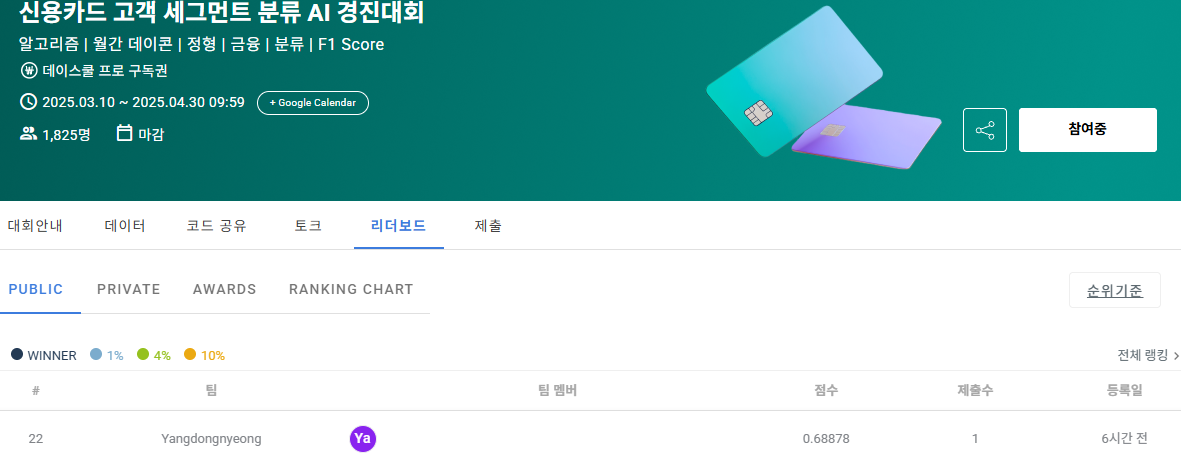

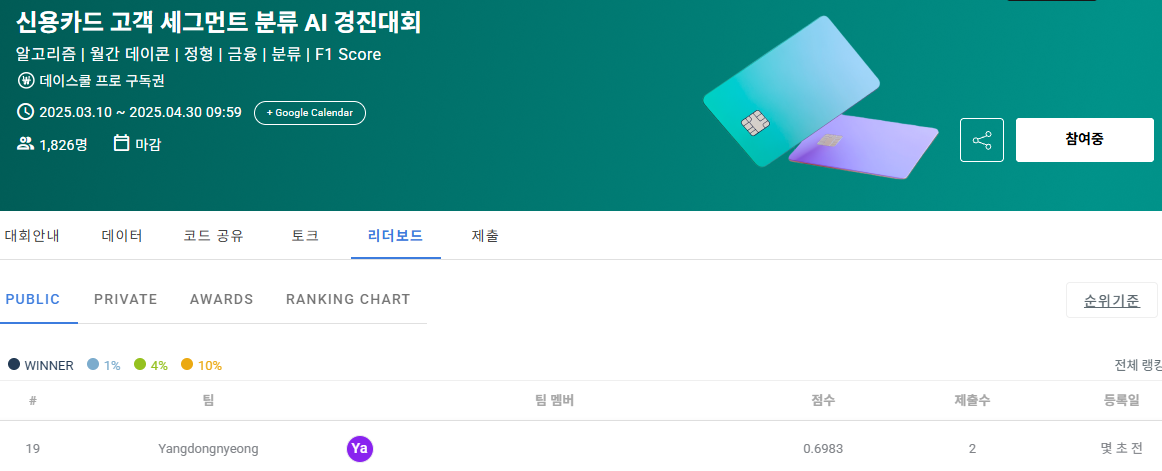

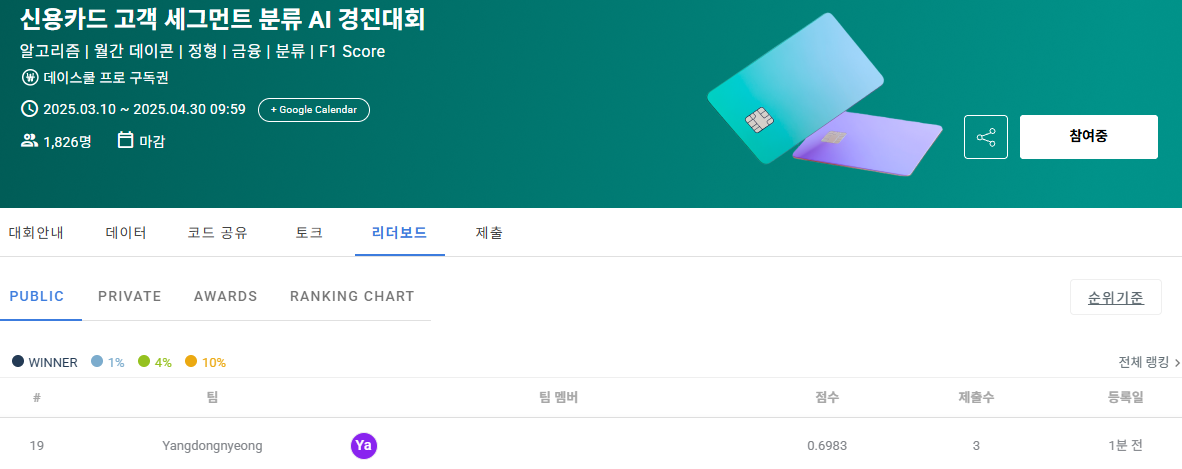

# 1. Import

In [1]:
import platform
import sys
print(f"개발환경 (OS) : {platform.platform()}")
print(f"Python Version : {sys.version}")
# T4 GPU, 고용량 RAM 설정

# import platform / import sys : 파이썬에 기본적으로 내장된 라이브러리를 불러오는 것
# platform.platform() : 현재 코드가 실행되고 있는 운영체제(OS)의 종류와 버전을 문자열로 반환
# sys.version : 설치된 파이썬의 상세 버전을 보여줌

개발환경 (OS) : Windows-10-10.0.26200-SP0
Python Version : 3.11.14 | packaged by Anaconda, Inc. | (main, Oct 21 2025, 18:30:03) [MSC v.1929 64 bit (AMD64)]


In [2]:
import pandas as pd
import numpy as np
import gc

# from google.colab import drive
# drive.mount('/content/drive')

# import pandas as pd : 파이썬에서 가장 많이 쓰이는 데이터 분석 라이브러리
# import numpy as np : 역할: 수치 계산을 위한 핵심 라이브러리
# import gc : 가비지 컬렉터(Garbage Collector) 인터페이스

In [3]:
# LightGBM을 위한 GPU driver 설치 코드
# !mkdir -p /etc/OpenCL/vendors && echo "libnvidia-opencl.so.1" > /etc/OpenCL/vendors/nvidia.icd
# !sudo apt install nvidia-driver-460 nvidia-cuda-toolkit clinfo
# !apt-get update --fix-missing
# !pip install -q  lightgbm==4.1.0 \
#   --config-settings=cmake.define.USE_GPU=ON \
#   --config-settings=cmake.define.OpenCL_INCLUDE_DIR="/usr/local/cuda/include/" \
#   --config-settings=cmake.define.OpenCL_LIBRARY="/usr/local/cuda/lib64/libOpenCL.so"
# LightGBM GPU 가속 설정 : 이 복잡한 코드들은 LightGBM이라는 알고리즘이 컴퓨터의 CPU 대신 GPU(그래픽 카드)를 사용하여 계산하게 만드는 설정
# mkdir ... nvidia.icd : 시스템에 NVIDIA 그래픽 카드가 있다는 것을 알려주는 통로(OpenCL 드라이버)를 설정
# apt install nvidia-driver... : 그래픽 카드를 구동하기 위한 드라이버와 CUDA(NVIDIA의 연산 최적화 도구)를 설치
# pip install lightgbm... --config-settings... : 일반적인 설치와 달리, "나 GPU 쓸 거니까 GPU 연산 기능을 넣어서 새로 빌드해줘"라고 명령하며 설치하는 방식

# CatBoost 라이브러리를 설치 : Categorical(범주형) 데이터를 처리하는 데 강점이 있는 머신러닝 라이브러리
# !pip install catboost

# imbalanced-learn 라이브러리를 설치 : 불균형 데이터셋을 다루기 위한 다양한 기법들을 제공하는 파이썬 라이브러리
# !pip install imbalanced-learn

In [4]:
# 데이터 불균형 해결 도구
# compute_class_weight (sklearn) : 클래스 불균형을 해결하기 위해 각 클래스에 가중치를 부여
# SMOTE (imblearn) : 소수 클래스의 데이터를 합성하여 데이터 불균형을 해결하는 오버샘플링 기법
# 머신러닝 모델
# XGBClassifier (xgboost) : 과적합(Overfitting)을 방지하는 다양한 기능을 제공하는 XGBoost 알고리즘을 사용한 분류 모델
# CatBoostClassifier (catboost) : Categorical Data(범주형)를 처리하는 능력이 뛰어난 CatBoost 알고리즘을 사용한 분류 모델
# LGBMClassifier (lightgbm) : 속도가 매우 빠르고 메모리를 적게 사용하여 대용량 데이터 처리에 가장 적합한 LightGBM 알고리즘을 사용한 분류 모델

import sklearn
from sklearn.utils.class_weight import compute_class_weight
import imblearn
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from xgboost import XGBClassifier
import catboost
from catboost import CatBoostClassifier
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation, LGBMClassifier

In [5]:
# 각 라이브러리의 버전(Version)을 출력하는 코드
print(f"pandas version: {pd.__version__}")
print(f"numpy version: {np.__version__}")
print(f"lightgbm version: {lgb.__version__}")
print(f"catboost version: {catboost.__version__}")
print(f"xgboost version: {xgb.__version__}")
print(f"sklearn version: {sklearn.__version__}")
print(f"imblearn version: {imblearn.__version__}")

pandas version: 3.0.0
numpy version: 2.1.3
lightgbm version: 4.6.0
catboost version: 1.2.8
xgboost version: 3.1.3
sklearn version: 1.7.2
imblearn version: 0.14.1


# 2. Data load & Preprocessing (1) - train data

## 회원정보 (customer)

- customer_train_df 생성

In [6]:
# Google Drive에 있는 데이터 경로
base_dir = "./data"

# 데이터 분할(폴더) 구분
data_splits = ["train"] # train 만!

# 각 데이터 유형별 폴더명, 파일 접미사, 변수 접두어 설정
data_categories = {
    "회원정보": {"folder": "1.회원정보", "suffix": "회원정보", "var_prefix": "customer"}
}

# 2018년 7월부터 12월까지의 월 리스트
months = ['07', '08', '09', '10', '11', '12']

for split in data_splits:
    for category, info in data_categories.items():
        folder = info["folder"]
        suffix = info["suffix"]
        var_prefix = info["var_prefix"]

        for month in months:
            # 파일명 형식: 2018{month}_{split}_{suffix}.parquet
            file_path = f"{base_dir}/{split}/{folder}/2018{month}_{split}_{suffix}.parquet"

            # 변수명 형식: {var_prefix}_{split}_{month}
            variable_name = f"{var_prefix}_{split}_{month}"

            globals()[variable_name] = pd.read_parquet(file_path)
            print(f"{variable_name} is loaded from {file_path}")

gc.collect()

# globals()[variable_name] : 루프(for문) 안에서 만들어진 문자열(예: "customer_train_07")을 실제 변수 이름으로 사용하여 데이터프레임을 할당
# file_path = f"{base_dir}/{split}/{folder}/2018{month}_{split}_{suffix}.parquet" : 
# 부분은 파일이 저장된 규칙적인 구조를 활용하여 7월부터 12월까지 폴더와 파일명을 일일이 치지 않고, {month} 변수만 바꿔가며 경로를 완성
# pd.read_parquet(file_path) : Parquet은 CSV보다 용량이 훨씬 작고 읽는 속도가 매우 빠릅니다. 금융권 대용량 데이터를 다룰 때 가장 선호되는 형식
# gc.collect() : 루프를 돌면서 파일 경로를 만들거나 문자열을 합칠 때 발생한 임시 쓰레기 메모리를 즉시 비워줍니다.

customer_train_07 is loaded from ./data/train/1.회원정보/201807_train_회원정보.parquet
customer_train_08 is loaded from ./data/train/1.회원정보/201808_train_회원정보.parquet
customer_train_09 is loaded from ./data/train/1.회원정보/201809_train_회원정보.parquet
customer_train_10 is loaded from ./data/train/1.회원정보/201810_train_회원정보.parquet
customer_train_11 is loaded from ./data/train/1.회원정보/201811_train_회원정보.parquet
customer_train_12 is loaded from ./data/train/1.회원정보/201812_train_회원정보.parquet


14

In [7]:
# 데이터 유형별 설정
info_categories = ["customer"]

# 월 설정
months = ['07', '08', '09', '10', '11', '12']

# 각 유형별로 월별 데이터를 합쳐서 새로운 변수에 저장
# train_dfs = {}: 결과물을 전역 변수로 마구 생성하는 대신, train_dfs라는 딕셔너리에 담아 관리
# 나중에 "신용정보(credit)", "매출정보(sales)" 등이 추가되더라도 info_categories만 늘려주면 루프를 돌며 train_dfs['credit_train_df'] 같은 식으로 차곡차곡 정리
train_dfs = {}

# pd.concat(df_list, axis=0): 여러 개의 데이터프레임을 세로 방향(행 기준)으로 합치는 함수. 7월부터 12월까지의 모든 회원 정보가 담긴 거대한 customer_train_df가 생성
# 루프 내부의 gc.collect(): 루프가 한 번 돌 때마다 임시 메모리를 비워줌으로써 메모리 사용량을 최적화
for prefix in info_categories:
    # globals()에서 동적 변수명으로 데이터프레임들을 가져와 리스트에 저장
    df_list = [globals()[f"{prefix}_train_{month}"] for month in months]
    train_dfs[f"{prefix}_train_df"] = pd.concat(df_list, axis=0)
    gc.collect()
    print(f"{prefix}_train_df is created with shape: {train_dfs[f'{prefix}_train_df'].shape}")


customer_train_df = train_dfs["customer_train_df"]
gc.collect()

# 추가한점
# 인덱스 초기화 및 시계열 정렬 : 데이터를 단순히 합치기만 하면 인덱스가 0~N, 0~N 식으로 중복될 수 있고, 시간 순서가 섞여 있을 수 있으므로 합친 후에 아래 코드를 실행해 주는 것이 좋음.
customer_train_df = customer_train_df.sort_values(by=['ID', '기준년월']).reset_index(drop=True)

customer_train_df is created with shape: (2400000, 78)


- 전처리

In [8]:
##### 1. 결측치 처리
# '_1순위신용체크구분', '_2순위신용체크구분’
#    → 결측치 '기타'로 채우기
#    → '_1순위신용체크구분_인코딩', '_2순위신용체크구분_인코딩’
# 결측치 처리 및 인코딩 (Mapping & Imputation) : _1순위신용체크구분 컬럼의 비어있는 값(NaN)을 '기타'로 정의한 뒤, {신용: 1, 체크: 0, 기타: -1}로 수치화
# 모델은 '신용'이라는 글자보다 '1'이라는 숫자의 크기 차이를 통해 패턴을 더 잘 학습
customer_train_df['_1순위신용체크구분'] = customer_train_df['_1순위신용체크구분'].fillna('기타')
customer_train_df['_2순위신용체크구분'] = customer_train_df['_2순위신용체크구분'].fillna('기타')
mapping = {'신용': 1, '체크': 0, '기타': -1}
customer_train_df['1순위신용체크구분_인코딩'] = customer_train_df['_1순위신용체크구분'].map(mapping)
customer_train_df['2순위신용체크구분_인코딩'] = customer_train_df['_2순위신용체크구분'].map(mapping)
customer_train_df.drop(columns=['_1순위신용체크구분','_2순위신용체크구분'], inplace=True)

# 가입통신회사코드 → 가입통신회사_S사여부
# customer_train_df['가입통신회사_S사여부'] = (customer_train_df['가입통신회사코드'] == 'S사').astype(int) : '가입통신회사코드' 컬럼에서 'S사'에 해당하는 값을 찾아서 True/False로 반환한 후, astype(int)를 사용하여 True는 1로, False는 0으로 변환
# customer_train_df = customer_train_df.drop(columns=['가입통신회사코드']) : '가입통신회사코드' 컬럼은 더 이상 필요하지 않으므로 drop 함수를 사용하여 삭제
customer_train_df['가입통신회사_S사여부'] = (customer_train_df['가입통신회사코드'] == 'S사').astype(int)
customer_train_df = customer_train_df.drop(columns=['가입통신회사코드'])

# 직장시도명 → 직장_수도권여부
# customer_train_df['직장_수도권여부'] = customer_train_df['직장시도명'].isin(['서울', '경기']).astype(int) : '직장시도명' 컬럼에서 '서울' 또는 '경기'에 해당하는 값을 찾아서 True/False로 반환한 후, astype(int)를 사용하여 True는 1로, False는 0으로 변환
# 수도권 여부: 직장시도명과 거주시도명에서 '서울', '경기'인 경우만 1로 추출
# customer_train_df = customer_train_df.drop(columns=['직장시도명']) : '직장시도명' 컬럼은 더 이상 필요하지 않으므로 drop 함수를 사용하여 삭제
customer_train_df['직장_수도권여부'] = customer_train_df['직장시도명'].isin(['서울', '경기']).astype(int)
customer_train_df = customer_train_df.drop(columns=['직장시도명'])

# 결측치 많은 변수 삭제!
# 정보 손실 최소화: 결측치가 너무 많았던 최종카드발급일자 등 3개 변수를 삭제하여 데이터셋을 가볍게 만듬.
customer_train_df = customer_train_df.drop(columns=['최종카드발급일자','최종유효년월_신용_이용가능', '최종유효년월_신용_이용'])


##### 2. 자료형 변환
# 거주시도명 → 거주지_수도권여부
# customer_train_df['거주지_수도권여부'] = customer_train_df['거주시도명'].isin(['서울', '경기']).astype(int) : '거주시도명' 컬럼에서 '서울' 또는 '경기'에 해당하는 값을 찾아서 True/False로 반환한 후, astype(int)를 사용하여 True는 1로, False는 0으로 변환
# 수도권 여부: 직장시도명과 거주시도명에서 '서울', '경기'인 경우만 1로 추출
# customer_train_df = customer_train_df.drop(columns=['거주시도명']) : '거주시도명' 컬럼은 더 이상 필요하지 않으므로 drop 함수를 사용하여 삭제
customer_train_df['거주지_수도권여부'] = customer_train_df['거주시도명'].isin(['서울', '경기']).astype(int)
customer_train_df = customer_train_df.drop(columns=['거주시도명'])

# 연회비발생카드수_B0M → 연회비발생카드수_B0M_이진
customer_train_df['연회비발생카드수_B0M_이진'] = customer_train_df['연회비발생카드수_B0M'].isin(['1개이상']).astype(int)
customer_train_df = customer_train_df.drop(columns=['연회비발생카드수_B0M'])

# 데이터 다 동일한 변수 4개 삭제!
# 상수 변수(Constant Columns): 상품관련면제카드수_B0M처럼 모든 행의 값이 동일한 변수는 학습에 아무런 정보도 주지 못하므로 삭제
# columns_drop = ['상품관련면제카드수_B0M','임직원면제카드수_B0M', '우수회원면제카드수_B0M', '기타면제카드수_B0M'] : 삭제할 변수명을 리스트로 저장
# customer_train_df = customer_train_df.drop(columns=columns_drop) : drop 함수를 사용하여 상수 변수를 삭제
columns_drop = ['상품관련면제카드수_B0M','임직원면제카드수_B0M', '우수회원면제카드수_B0M', '기타면제카드수_B0M']
customer_train_df = customer_train_df.drop(columns=columns_drop)

# Life_Stage: 파생변수(Life_Stage_자녀성장_여부) 생성 후 변수 삭제
customer_train_df['Life_Stage_자녀성장_여부'] = customer_train_df['Life_Stage'].isin(['자녀성장(1)', '자녀성장(2)']).astype(int)
customer_train_df = customer_train_df.drop(columns=['Life_Stage'])

# 연령에서 숫자만 추출 후 int형으로 변환
# customer_train_df['연령'] = customer_train_df['연령'].str.extract(r'(\d+)').astype(float).astype('Int64') : '연령' 컬럼에서 숫자만 추출하여 float형으로 변환한 뒤, 결측치를 허용하는 Int64형으로 다시 변환
customer_train_df['연령'] = customer_train_df['연령'].str.extract(r'(\d+)').astype(float).astype('Int64')

##### 3.상관관계 분석
# 데이터 다 동일한 변수 4개 삭제
columns_drop = ['이용금액_R3M_체크_가족','연회비할인카드수_B0M','할인금액_기본연회비_B0M','할인금액_제휴연회비_B0M']
customer_train_df = customer_train_df.drop(columns=columns_drop)

##### 4. 변수 별로 확인
# 4개의 변수 삭제
# '입회일자_신용' 삭제 (입회경과개월수_신용 있음)
# 데이터 다 동일한 변수 '이용카드수_체크_가족' 삭제
# '청구금액_기본연회비_B0M','청구금액_제휴연회비_B0M’삭제 (의미 같은 변수 있음)
# 입회일자_신용 대신 입회경과개월수_신용처럼 이미 수치화된 변수가 있다면, 중복되는 날짜 변수는 삭제하는 것이 모델의 해석력을 높임.
# columns_drop = ['입회일자_신용','이용카드수_체크_가족','청구금액_기본연회비_B0M','청구금액_제휴연회비_B0M'] : 삭제할 변수명을 리스트로 저장
# customer_train_df = customer_train_df.drop(columns=columns_drop) : drop 함수를 사용하여 불필요한 변수를 삭제
columns_drop = ['입회일자_신용','이용카드수_체크_가족','청구금액_기본연회비_B0M','청구금액_제휴연회비_B0M']
customer_train_df = customer_train_df.drop(columns=columns_drop)

- 파일 저장

In [9]:
# int64 -> int32로 변경 (메모리 줄이기 위함)
# 모든 정수형(int64) 컬럼을 검사하여, 해당 컬럼의 최댓값이 약 21억(2,147,483,647)보다 작은지 확인
# 메모리 사용량이 즉시 절반으로 감소
for col in customer_train_df.select_dtypes(include='int64').columns:
    if customer_train_df[col].max() < 2_147_483_647:
        customer_train_df[col] = customer_train_df[col].astype('int32')

# float64 -> float 32로 변경 (메모리 줄이기 위함)
# 소수점이 있는 실수 데이터를 64비트에서 32비트로 변환
# 메모리 효율이 좋아지며, 나중에 LightGBM이나 XGBoost 같은 모델을 학습시킬 때 속도가 훨씬 빨라짐.
for col in customer_train_df.select_dtypes(include='float64').columns:
    customer_train_df[col] = customer_train_df[col].astype('float32')

#customer_train_df = customer_train_df.drop(columns=['Segment'])
# 가공된 최종 데이터를 .parquet 확장자로 저장 : CSV 대비 용량이 1/4 이상 작음.
customer_train_df.to_parquet("./data/train/customer_train_cleaned.parquet")

## 신용정보 (credit)

- credit_train_df 생성

In [10]:
# Google Drive에 있는 데이터 경로
base_dir = "./data"

# 데이터 분할(폴더) 구분
data_splits = ["train"] # train 만!

# 각 데이터 유형별 폴더명, 파일 접미사, 변수 접두어 설정
# data_categories : 딕셔너리를 사용하여 로드할 데이터의 정보를 정의
# folder : 실제 파일이 저장된 폴더 이름
# suffix : 파일명 끝에 붙는 구분자(신용정보 등)
# var_prefix : 불러온 뒤 파이썬 안에서 사용할 변수의 이름표(credit)
# 나중에 "매출정보"나 "연체정보"를 추가하고 싶을 때, 이 딕셔너리에 설정값 한 줄만 추가하면 아래의 복잡한 for 루프 코드를 전혀 건드리지 않고도 데이터를 불러올 수 있음.
data_categories = {
    "신용정보": {"folder": "2.신용정보", "suffix": "신용정보", "var_prefix": "credit"}
}

# 2018년 7월부터 12월까지의 월 리스트
months = ['07', '08', '09', '10', '11', '12']

for split in data_splits:
    for category, info in data_categories.items():
        folder = info["folder"]
        suffix = info["suffix"]
        var_prefix = info["var_prefix"]

        for month in months:
            # 파일명 형식: 2018{month}_{split}_{suffix}.parquet
            # base_dir(./data), split(train), folder(2.신용정보), month(07~12) 등 흩어져 있는 정보들을 조합하여 완벽한 파일 경로를 만듬.
            # ./data/train/2.신용정보/201807_train_신용정보.parquet
            file_path = f"{base_dir}/{split}/{folder}/2018{month}_{split}_{suffix}.parquet"

            # 변수명 형식: {var_prefix}_{split}_{month}
            variable_name = f"{var_prefix}_{split}_{month}"

            # globals() : 파이썬의 전역 변수 관리 시스템. 루프를 돌면서 credit_train_07, credit_train_08 ... credit_train_12라는 이름의 실제 변수들을 실시간으로 생성하고 데이터를 담음.
            globals()[variable_name] = pd.read_parquet(file_path)
            print(f"{variable_name} is loaded from {file_path}")

# gc.collect() : 파일 로딩 과정에서 발생한 문자열 연산 결과나 임시 캐시 데이터 등 불필요해진 메모리 파편을 강제로 정리
gc.collect()

credit_train_07 is loaded from ./data/train/2.신용정보/201807_train_신용정보.parquet
credit_train_08 is loaded from ./data/train/2.신용정보/201808_train_신용정보.parquet
credit_train_09 is loaded from ./data/train/2.신용정보/201809_train_신용정보.parquet
credit_train_10 is loaded from ./data/train/2.신용정보/201810_train_신용정보.parquet
credit_train_11 is loaded from ./data/train/2.신용정보/201811_train_신용정보.parquet
credit_train_12 is loaded from ./data/train/2.신용정보/201812_train_신용정보.parquet


0

In [11]:
# 데이터 유형별 설정
info_categories = ["credit"]

# 월 설정
months = ['07', '08', '09', '10', '11', '12']

# 각 유형별로 월별 데이터를 합쳐서 새로운 변수에 저장
train_dfs = {}

for prefix in info_categories:
    # globals()에서 동적 변수명으로 데이터프레임들을 가져와 리스트에 저장
    # df_list = [globals()[f"{prefix}_train_{month}"] for month in months] : 메모리에 개별적으로 존재하는 credit_train_07부터 credit_train_12까지의 변수들을 순서대로 찾아내어 하나의 리스트(df_list)에 저장
    # train_dfs[f"{prefix}_train_df"] = pd.concat(df_list, axis=0) : df_list에 담긴 6개의 데이터프레임을 세로 방향(행 기준)으로 합쳐서 credit_train_df라는 하나의 거대한 데이터프레임으로 만듬.
    # train_dfs : 결과물을 전역 변수로 마구 생성하는 대신, train_dfs라는 딕셔너리에 담아 관리
    df_list = [globals()[f"{prefix}_train_{month}"] for month in months]
    train_dfs[f"{prefix}_train_df"] = pd.concat(df_list, axis=0)
    gc.collect()
    print(f"{prefix}_train_df is created with shape: {train_dfs[f'{prefix}_train_df'].shape}")

credit_train_df = train_dfs["credit_train_df"]

# gc.collect() : 메모리 정리
gc.collect()

credit_train_df is created with shape: (2400000, 42)


0

In [12]:
# customer_train_df = pd.read_parquet('./data/train/customer_train_cleaned.parquet') : 앞서 저장한 전처리 완료된 회원정보 데이터를 다시 불러옴
customer_train_df = pd.read_parquet('./data/train/customer_train_cleaned.parquet')
# customer_train_df_seg = customer_train_df[['기준년월','ID','Segment']] : '기준년월', 'ID', 'Segment' 컬럼만 추출하여 customer_train_df_seg라는 새로운 데이터프레임 생성
customer_train_df_seg = customer_train_df[['기준년월','ID','Segment']]

# credit_with_seg = customer_train_df_seg.merge(credit_train_df, on=['기준년월', 'ID'], how='left') :
# 회원정보 데이터프레임(customer_train_df_seg)과 신용정보 데이터프레임(credit_train_df)을 '기준년월'과 'ID' 컬럼을 기준으로 왼쪽 조인(left join)하여 credit_with_seg라는 새로운 데이터프레임 생성
# on=['기준년월', 'ID'] : 두 데이터프레임을 결합할 때 기준이 되는 컬럼들
# how='left' : 왼쪽 데이터프레임(customer_train_df_seg)의 모든 행을 유지하고, 오른쪽 데이터프레임(credit_train_df)에서 일치하는 행만 추가
# credit_with_seg 생성
credit_with_seg = customer_train_df_seg.merge(credit_train_df, on=['기준년월', 'ID'], how='left') # segment 변수 추가
#credit_with_seg.to_parquet('/content/drive/MyDrive/DACON/rawdata/credit_with_seg.parquet')

- 전처리

In [13]:
##### 1. 결측치 처리
# 'RV신청일자' 변수 삭제 : 날짜 데이터는 그 자체로 모델에 넣기 어렵고, 분석 목적에 따라 불필요할 경우 과감히 삭제하여 메모리를 확보
credit_with_seg = credit_with_seg.drop(columns=['RV신청일자'])

# 'RV전환가능여부' → 'RV전환불가능여부'
# credit_with_seg['RV_전환가능여부_이진'] = (credit_with_seg['RV전환가능여부'] == 'N').astype(int) : 'RV전환가능여부' 컬럼에서 'N'인 경우를 True로, 나머지를 False로 반환한 후, astype(int)를 사용하여 True는 1로, False는 0으로 변환
# credit_with_seg = credit_with_seg.drop(columns='RV전환가능여부') : 'RV전환가능여부' 컬럼은 더 이상 필요하지 않으므로 drop 함수를 사용하여 삭제
credit_with_seg['RV_전환가능여부_이진'] = (credit_with_seg['RV전환가능여부'] == 'N').astype(int)
credit_with_seg = credit_with_seg.drop(columns='RV전환가능여부')

##### 2. 자료형 변환
# 자발한도감액횟수_R12M: '0회' → 0, '1회' → 1, '2회' → 2
# 자발한도감액횟수_R12M: str.replace('회', '')를 사용하여 "1회", "2회" 같은 문자열에서 숫자 부분만 남기고 int로 변환
credit_with_seg['자발한도감액횟수_R12M'] = (
    credit_with_seg['자발한도감액횟수_R12M']
    .str.replace('회', '', regex=False)  # '회' 제거
    .astype(int)  # 바로 int로 변환!
)

#‘한도증액횟수_R12M’ → '한도증액_R12M_여부': '0회' → 0, '1회이상' → 1
# 한도증액횟수, 한도심사요청건수: .map()을 사용하여 '0회'는 0으로, '1회이상'은 1로 묶어 데이터를 단순화
credit_with_seg['한도증액_R12M_여부'] = credit_with_seg['한도증액횟수_R12M'].map({
    '0회': 0,
    '1회이상': 1
    }).astype(int)
credit_with_seg.drop(columns=['한도증액횟수_R12M'], inplace=True)

# '카드론동의여부': 'Y' → 1, 'N' → 0
# 카드론동의여부: 컴퓨터는 'Y/N'을 계산할 수 없으므로, 이를 머신러닝의 표준인 1과 0으로 매핑
credit_with_seg['카드론동의여부'] = credit_with_seg['카드론동의여부'].map({
    'Y': 1,
    'N': 0
    }).astype(int)

# '한도심사요청건수' → '한도심사요청여부': '0회' → 0, '1회이상' → 1
credit_with_seg['한도심사요청여부'] = credit_with_seg['한도심사요청건수'].map({
    '0회': 0,
    '1회이상': 1
    }).astype(int)
credit_with_seg.drop(columns=['한도심사요청건수'], inplace=True)

In [14]:
##### 3. 상관관계 분석
# 데이터 모두 동일한 변수 1개 삭제
credit_with_seg = credit_with_seg.drop(columns=['시장연체상환여부_R3M'])

##### 4. 변수 별로 확인
# 'RV실사용여부' 변수 추가
credit_with_seg['RV실사용여부'] = (credit_with_seg['RV약정청구율'] > 0).astype(int)

# '강제한도감액횟수_2회이상여부' 변수 추가
credit_with_seg['강제한도감액횟수_2회이상여부'] = (credit_with_seg['강제한도감액횟수_R12M'] > 1).astype(int)

# '강제한도감액금액_R12M_3이상여부' 변수 추가
credit_with_seg['강제한도감액금액_R12M_3이상여부'] = (credit_with_seg['강제한도감액금액_R12M'] > 2).astype(int)

# '상향가능CA한도금액_1여부' 변수 추가
credit_with_seg['상향가능CA한도금액_1여부'] = (credit_with_seg['상향가능CA한도금액'] == 1).astype(int)

# '카드이용한도금액_A수준복합' 변수 추가
a_limit = credit_with_seg[credit_with_seg['Segment'] == 'A']['카드이용한도금액_B1M']
q1 = a_limit.quantile(0.25)
q3 = a_limit.quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
a_no_outlier = a_limit[(a_limit >= lower_bound) & (a_limit <= upper_bound)]
a_B1M = a_no_outlier.min()
print(f"A의 이상치 제외 후 최솟값: {a_B1M:,}")  # 170,344

a_limit = credit_with_seg[credit_with_seg['Segment'] == 'A']['카드이용한도금액_B2M']
q1 = a_limit.quantile(0.25)
q3 = a_limit.quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
a_no_outlier = a_limit[(a_limit >= lower_bound) & (a_limit <= upper_bound)]
a_B2M = a_no_outlier.min()
print(f"A의 이상치 제외 후 최솟값: {a_B2M:,}")  # 170,344

def classify_dual_limit(row):
    b1 = row['카드이용한도금액_B1M'] >= a_B1M
    b2 = row['카드이용한도금액_B2M'] >= a_B2M
    if b1 and b2:
        return 2     # 둘 다 170,344 이상
    elif b1 or b2:
        return 1     # 하나만 170,344 이상
    else:
        return 0    # 둘 다 170,344 미만

credit_with_seg['카드이용한도금액_A수준복합'] = credit_with_seg.apply(classify_dual_limit, axis=1)

A의 이상치 제외 후 최솟값: 170,344
A의 이상치 제외 후 최솟값: 170,344


- 파일 저장

In [15]:
# int64 -> int32로 변경 (메모리 줄이기 위함)
for col in credit_with_seg.select_dtypes(include='int64').columns:
    if credit_with_seg[col].max() < 2_147_483_647:
        credit_with_seg[col] = credit_with_seg[col].astype('int32')

# float64 -> float 32로 변경 (메모리 줄이기 위함)
for col in credit_with_seg.select_dtypes(include='float64').columns:
    credit_with_seg[col] = credit_with_seg[col].astype('float32')

In [16]:
credit_with_seg = credit_with_seg.drop(columns=['Segment'])
credit_with_seg.to_parquet("./data/train/credit_train_cleaned.parquet")

In [17]:
print(credit_with_seg.columns.tolist())


['기준년월', 'ID', '최초한도금액', '카드이용한도금액', 'CA한도금액', '일시상환론한도금액', '월상환론한도금액', 'CA이자율_할인전', 'CL이자율_할인전', 'RV일시불이자율_할인전', 'RV현금서비스이자율_할인전', 'RV약정청구율', 'RV최소결제비율', '자발한도감액횟수_R12M', '자발한도감액금액_R12M', '자발한도감액후경과월', '강제한도감액횟수_R12M', '강제한도감액금액_R12M', '강제한도감액후경과월', '한도증액금액_R12M', '한도증액후경과월', '상향가능한도금액', '상향가능CA한도금액', '카드론동의여부', '월상환론상향가능한도금액', '일시불ONLY전환가능여부', '카드이용한도금액_B1M', '카드이용한도금액_B2M', '특별한도보유여부_R3M', '연체감액여부_R3M', '한도요청거절건수', '한도심사요청후경과월', '한도심사거절후경과월', '시장단기연체여부_R6M', '시장단기연체여부_R3M', '시장연체상환여부_R6M', 'rv최초시작후경과일', 'RV_전환가능여부_이진', '한도증액_R12M_여부', '한도심사요청여부', 'RV실사용여부', '강제한도감액횟수_2회이상여부', '강제한도감액금액_R12M_3이상여부', '상향가능CA한도금액_1여부', '카드이용한도금액_A수준복합']


## 승인매출정보 (sales)

In [18]:
import pandas as pd
import numpy as np
import gc

# from google.colab import drive
# drive.mount('/content/drive')

- sales_train_df 생성

In [19]:
# Google Drive에 있는 데이터 경로
base_dir = "./data"

# 데이터 분할(폴더) 구분
data_splits = ["train"] # train 만!

# 각 데이터 유형별 폴더명, 파일 접미사, 변수 접두어 설정
data_categories = {
    "승인매출정보": {"folder": "3.승인매출정보", "suffix": "승인매출정보", "var_prefix": "sales"}
}

# 2018년 7월부터 12월까지의 월 리스트
months = ['07', '08', '09', '10', '11', '12']

for split in data_splits:
    for category, info in data_categories.items():
        folder = info["folder"]
        suffix = info["suffix"]
        var_prefix = info["var_prefix"]

        for month in months:
            # 파일명 형식: 2018{month}_{split}_{suffix}.parquet
            #file_path = f"./{split}/{folder}/2018{month}_{split}_{suffix}.parquet"
            file_path = f"{base_dir}/{split}/{folder}/2018{month}_{split}_{suffix}.parquet"

            # 변수명 형식: {var_prefix}_{split}_{month}
            variable_name = f"{var_prefix}_{split}_{month}"

            globals()[variable_name] = pd.read_parquet(file_path)
            print(f"{variable_name} is loaded from {file_path}")

gc.collect()

sales_train_07 is loaded from ./data/train/3.승인매출정보/201807_train_승인매출정보.parquet
sales_train_08 is loaded from ./data/train/3.승인매출정보/201808_train_승인매출정보.parquet
sales_train_09 is loaded from ./data/train/3.승인매출정보/201809_train_승인매출정보.parquet
sales_train_10 is loaded from ./data/train/3.승인매출정보/201810_train_승인매출정보.parquet
sales_train_11 is loaded from ./data/train/3.승인매출정보/201811_train_승인매출정보.parquet
sales_train_12 is loaded from ./data/train/3.승인매출정보/201812_train_승인매출정보.parquet


0

In [20]:
# 데이터 유형별 설정
info_categories = ["sales"]

# 월 설정
months = ['07', '08', '09', '10', '11', '12']

# 각 유형별로 월별 데이터를 합쳐서 새로운 변수에 저장
train_dfs = {}

for prefix in info_categories:
    # globals()에서 동적 변수명으로 데이터프레임들을 가져와 리스트에 저장
    df_list = [globals()[f"{prefix}_train_{month}"] for month in months]
    train_dfs[f"{prefix}_train_df"] = pd.concat(df_list, axis=0)
    gc.collect()
    print(f"{prefix}_train_df is created with shape: {train_dfs[f'{prefix}_train_df'].shape}")

sales_train_df = train_dfs["sales_train_df"]
gc.collect()

sales_train_df is created with shape: (2400000, 406)


0

In [21]:
customer_train_df = pd.read_parquet('./data/train/customer_train_cleaned.parquet')
customer_train_df_seg = customer_train_df[['기준년월','ID','Segment']]

# sales_with_seg 생성
sales_with_seg = customer_train_df_seg.merge(sales_train_df, on=['기준년월', 'ID'], how='left') # segment 변수 추가

del sales_train_df
del customer_train_df
del customer_train_df_seg
gc.collect()

0

- 전처리

### 1. 결측치 처리

In [22]:
# '_n순위@@업종' 변수(총 15개 변수) 결측치는 '없음'으로 채우기
upjong_cols = [
    '_1순위업종','_2순위업종','_3순위업종',
    '_1순위쇼핑업종','_2순위쇼핑업종','_3순위쇼핑업종',
    '_1순위교통업종','_2순위교통업종','_3순위교통업종',
    '_1순위여유업종','_2순위여유업종','_3순위여유업종',
    '_1순위납부업종','_2순위납부업종','_3순위납부업종'
]

sales_with_seg[upjong_cols] = sales_with_seg[upjong_cols].fillna('없음')

In [23]:
# '_n순위업종_AB' 변수 추가 (상관계수 -0.3030)

'''
- 1순위 업종이 쇼핑	+1
- 2순위 업종이 사교활동	+1
- 2순위 업종이 교육	+0.5
- 2순위 업종이 의료	+1.5 (A, B에서 더 강하게 나타나므로)
- 3순위 업종이 사교활동	+1
- 3순위 업종이 의료	+1.5 (A, B에서 더 강하게 나타나므로)

- 2순위 업종이 없음 -1
- 3순위 업종이 없음 -1
- 2순위 업종이 교통 -0.5
- 2순위 업종이 납부 -0.5
'''

def compute_ab_score(row):
    score = 0
    # 가점 조건
    if row['_1순위업종'] == '쇼핑':
        score += 1
    if row['_2순위업종'] == '사교활동':
        score += 1
    if row['_2순위업종'] == '교육':
        score += 0.5
    if row['_2순위업종'] == '의료':
        score += 1
    if row['_3순위업종'] == '사교활동':
        score += 1
    if row['_3순위업종'] == '의료':
        score += 1

    # 감점 조건
    if row['_2순위업종'] == '없음':
        score -= 1
    if row['_3순위업종'] == '없음':
        score -= 1
    if row['_2순위업종'] == '교통':
        score -= 0.5
    if row['_2순위업종'] == '납부':
        score -= 0.5

    return score

sales_with_seg['_n순위업종_AB'] = sales_with_seg.apply(compute_ab_score, axis=1)

In [24]:
# '_n순위쇼핑업종_AB' 변수 추가 (상관계수 -0.3304)

'''
- 1순위 쇼핑업종이 온라인 +1
- 2순위 쇼핑업종이 도소매 +1
- 3순위 쇼핑업종이 마트 +1

- 1순위 쇼핑업종이 없음 -1
- 2순위 쇼핑업종이 슈퍼마켓 -0.5
- 2순위 쇼핑업종이 없음 -0.5
- 3순위 쇼핑업종이 없음 -1
'''

def compute_ab_score(row):
    score = 0
    # 가점 조건
    if row['_1순위쇼핑업종'] == '온라인':
        score += 1
    if row['_2순위쇼핑업종'] == '도소매':
        score += 1
    if row['_3순위쇼핑업종'] == '마트':
        score += 1

    # 감점 조건
    if row['_1순위쇼핑업종'] == '없음':
        score -= 1
    if row['_2순위쇼핑업종'] == '슈퍼마켓':
        score -= 0.5
    if row['_2순위쇼핑업종'] == '없음':
        score -= 0.5
    if row['_3순위쇼핑업종'] == '없음':
        score -= 1

    return score

sales_with_seg['_n순위쇼핑업종_AB'] = sales_with_seg.apply(compute_ab_score, axis=1)

In [25]:
# '_n순위교통업종_AB' 변수 추가 (상관계수 -0.34514)

'''
- 1순위 교통업종이 주유 +1
- 2순위 교통업종이 정비 +1
- 3순위 교통업종이 택시 +0.5
- 3순위 교통업종이 정비 +0.5
- 3순위 교통업종이 철도버스 +0.5

- 1순위 교통업종이 없음 -1
- 2순위 교통업종이 없음 -1
'''

def compute_ab_score(row):
    score = 0
    # 가점 조건
    if row['_1순위교통업종'] == '주유':
        score += 1
    if row['_2순위교통업종'] == '정비':
        score += 1
    if row['_3순위교통업종'] == '택시':
        score += 0.5
    if row['_3순위교통업종'] == '정비':
        score += 0.5
    if row['_3순위교통업종'] == '철도버스':
        score += 0.5

    # 감점 조건
    if row['_1순위교통업종'] == '없음':
        score -= 1
    if row['_2순위교통업종'] == '없음':
        score -= 1

    return score

sales_with_seg['_n순위교통업종_AB'] = sales_with_seg.apply(compute_ab_score, axis=1)

In [26]:
# '_n순위여유업종_AB' 변수 추가 (상관계수 -0.26628)

'''
- 1순위 여유업종이 운동 +1
- 1순위 여유업종이 항공 +1
- 2순위 여유업종이 숙박 +1
- 2순위 여유업종이 공연 +1
- 3순위 여유업종이 숙박 +1
- 3순위 여유업종이 공연 +1
- 3순위 여유업종이 여유기타 +1

- 1순위 여유업종이 없음 -0.5
- 2순위 여유업종이 없음 -0.5
- 3순위 여유업종이 없음 -0.5
'''

def compute_ab_score(row):
    score = 0
    # 가점 조건
    if row['_1순위여유업종'] == '운동':
        score += 1
    if row['_1순위여유업종'] == '항공':
        score += 1
    if row['_2순위여유업종'] == '숙박':
        score += 1
    if row['_2순위여유업종'] == '공연':
        score += 1
    if row['_3순위여유업종'] == '숙박':
        score += 1
    if row['_3순위여유업종'] == '공연':
        score += 1
    if row['_3순위여유업종'] == '여유기타':
        score += 1

    # 감점 조건
    if row['_1순위여유업종'] == '없음':
        score -= 0.5
    if row['_2순위여유업종'] == '없음':
        score -= 0.5
    if row['_3순위여유업종'] == '없음':
        score -= 0.5

    return score

sales_with_seg['_n순위여유업종_AB'] = sales_with_seg.apply(compute_ab_score, axis=1)

In [27]:
# '_n순위납부업종_AB' 변수 추가 (상관계수 -0.2579)

'''
- 1순위 납부업종이 납부기타 +0.5
- 1순위 납부업종이 보험료 +0.5
- 1순위 납부업종이 통신비 +0.5
- 2순위 납부업종이 납부기타 +0.5
- 2순위 납부업종이 보험료 +0.5
- 2순위 납부업종이 통신비 +0.5
- 3순위 납부업종이 납부기타 +0.5

- 1순위 납부업종이 없음 -0.5
- 2순위 납부업종이 없음 -0.5
- 3순위 납부업종이 없음 -0.5
'''

def compute_ab_score(row):
    score = 0
    # 가점 조건
    if row['_1순위납부업종'] == '납부기타':
        score += 0.5
    if row['_1순위납부업종'] == '보험료':
        score += 0.5
    if row['_1순위납부업종'] == '통신비':
        score += 0.5
    if row['_2순위납부업종'] == '납부기타':
        score += 0.5
    if row['_2순위납부업종'] == '보험료':
        score += 0.5
    if row['_2순위납부업종'] == '통신비':
        score += 0.5
    if row['_3순위납부업종'] == '납부기타':
        score += 0.5

    # 감점 조건
    if row['_1순위납부업종'] == '없음':
        score -= 0.5
    if row['_2순위납부업종'] == '없음':
        score -= 0.5
    if row['_3순위납부업종'] == '없음':
        score -= 0.5

    return score

sales_with_seg['_n순위납부업종_AB'] = sales_with_seg.apply(compute_ab_score, axis=1)

In [28]:
# '_n순위@@업종_AB' 5개 변수 합친 변수 '_n순위업종_AB_총합' 추가 (상관계수 -0.3927)
sales_with_seg['_n순위업종_AB_총합'] = (
    sales_with_seg['_n순위업종_AB'] +
    sales_with_seg['_n순위쇼핑업종_AB'] +
    sales_with_seg['_n순위교통업종_AB'] +
    sales_with_seg['_n순위여유업종_AB'] +
    sales_with_seg['_n순위납부업종_AB']
)

# '_n순위@@업종' 변수 삭제
cols_to_drop = [
    '_1순위업종','_2순위업종','_3순위업종',
    '_1순위쇼핑업종','_2순위쇼핑업종','_3순위쇼핑업종',
    '_1순위교통업종','_2순위교통업종','_3순위교통업종',
    '_1순위여유업종','_2순위여유업종','_3순위여유업종',
    '_1순위납부업종','_2순위납부업종','_3순위납부업종'
]

sales_with_seg.drop(columns=cols_to_drop, inplace=True)

In [29]:
# 결측치 80% 이상인 최종카드론 관련 변수 삭제
cols_to_drop = ['최종카드론_대출일자','최종카드론_신청경로코드','최종카드론_금융상환방식코드']
sales_with_seg = sales_with_seg.drop(columns=cols_to_drop)

### 2. 자료형 변환

In [30]:
# '이용금액대_점수' 변수 생성 (상관계수 -0.6026)
amount_mapping = {
    '01.100만원+': 18,
    '02.50만원+': 5,
    '03.30만원+': 2,
    '04.10만원+': 2,
    '05.10만원-': 1,
    '09.미사용': 1
}

sales_with_seg['이용금액대_점수'] = sales_with_seg['이용금액대'].map(amount_mapping)

# 원래 변수 '이용금액대' 삭제
sales_with_seg = sales_with_seg.drop(columns=['이용금액대'])

### 3. 상관관계 분석

In [31]:
# 데이터 값이 모두 같은 변수 2개 제거
sales_with_seg = sales_with_seg.drop(columns=['승인거절건수_입력오류_B0M','승인거절건수_기타_B0M'])

### 변수 별로 데이터 살펴보기

In [32]:
# '이용여부_@@' 변수 생성
sales_with_seg['이용여부_기본']   = (sales_with_seg['최종이용일자_기본'] != 10101).astype(int)
sales_with_seg['이용여부_신판']   = (sales_with_seg['최종이용일자_신판'] != 10101).astype(int)
sales_with_seg['이용여부_CA']    = (sales_with_seg['최종이용일자_CA'] != 10101).astype(int)
sales_with_seg['이용여부_카드론'] = (sales_with_seg['최종이용일자_카드론'] != 10101).astype(int)
sales_with_seg['이용여부_체크']   = (sales_with_seg['최종이용일자_체크'] != 10101).astype(int)
sales_with_seg['이용여부_일시불'] = (sales_with_seg['최종이용일자_일시불'] != 10101).astype(int)
sales_with_seg['이용여부_할부']   = (sales_with_seg['최종이용일자_할부'] != 10101).astype(int)

# 원래 '최종이용일자_@@' 변수 삭제
for i in ['최종이용일자_기본','최종이용일자_신판','최종이용일자_CA','최종이용일자_카드론','최종이용일자_체크','최종이용일자_일시불','최종이용일자_할부']:
  sales_with_seg = sales_with_seg.drop(columns=[i])

- BOM 변수

In [33]:
##### 이용건수 #####

# 데이터 값이 모두 같은 변수 제거
sales_with_seg = sales_with_seg.drop(columns=['이용건수_부분무이자_B0M'])

# '이용건수_신용_B0M' 변수 값 보정
sales_with_seg['이용건수_신용_B0M'] = sales_with_seg['이용건수_신용_B0M'] + sales_with_seg['이용건수_카드론_B0M']



##### 이용금액 #####

# 데이터 값이 모두 같은 변수 제거
sales_with_seg = sales_with_seg.drop(columns=['이용금액_부분무이자_B0M'])

# '이용금액_신용_B0M', '이용금액_신판_B0M' 변수 생성
sales_with_seg['이용금액_신용_B0M'] = sales_with_seg['이용금액_일시불_B0M'] + sales_with_seg['이용금액_할부_B0M'] + sales_with_seg['이용금액_CA_B0M'] + sales_with_seg['이용금액_카드론_B0M']
sales_with_seg['이용금액_신판_B0M'] = sales_with_seg['이용금액_일시불_B0M'] + sales_with_seg['이용금액_할부_B0M']

In [34]:
# 건수별평균이용금액 변수 생성
sales_with_seg['건수별평균이용금액_신용_B0M'] = np.where(
    (sales_with_seg['이용건수_신용_B0M'] == 0) | (sales_with_seg['이용금액_신용_B0M'] == 0), 0,
    sales_with_seg['이용금액_신용_B0M'] / sales_with_seg['이용건수_신용_B0M'].abs()
)

sales_with_seg['건수별평균이용금액_신판_B0M'] = np.where(
    (sales_with_seg['이용건수_신판_B0M'] == 0) | (sales_with_seg['이용금액_신판_B0M'] == 0), 0,
    sales_with_seg['이용금액_신판_B0M'] / sales_with_seg['이용건수_신판_B0M'].abs()
)

sales_with_seg['건수별평균이용금액_일시불_B0M'] = np.where(
    (sales_with_seg['이용건수_일시불_B0M'] == 0) | (sales_with_seg['이용금액_일시불_B0M'] == 0), 0,
    sales_with_seg['이용금액_일시불_B0M'] / sales_with_seg['이용건수_일시불_B0M'].abs()
)

sales_with_seg['건수별평균이용금액_할부_B0M'] = np.where(
    (sales_with_seg['이용건수_할부_B0M'] == 0) | (sales_with_seg['이용금액_할부_B0M'] == 0), 0,
    sales_with_seg['이용금액_할부_B0M'] / sales_with_seg['이용건수_할부_B0M'].abs()
)

sales_with_seg['건수별평균이용금액_할부_유이자_B0M'] = np.where(
    (sales_with_seg['이용건수_할부_유이자_B0M'] == 0) | (sales_with_seg['이용금액_할부_유이자_B0M'] == 0), 0,
    sales_with_seg['이용금액_할부_유이자_B0M'] / sales_with_seg['이용건수_할부_유이자_B0M'].abs()
)

sales_with_seg['건수별평균이용금액_할부_무이자_B0M'] = np.where(
    (sales_with_seg['이용건수_할부_무이자_B0M'] == 0) | (sales_with_seg['이용금액_할부_무이자_B0M'] == 0), 0,
    sales_with_seg['이용금액_할부_무이자_B0M'] / sales_with_seg['이용건수_할부_무이자_B0M'].abs()
)

sales_with_seg['건수별평균이용금액_CA_B0M'] = np.where(
    (sales_with_seg['이용건수_CA_B0M'] == 0) | (sales_with_seg['이용금액_CA_B0M'] == 0), 0,
    sales_with_seg['이용금액_CA_B0M'] / sales_with_seg['이용건수_CA_B0M'].abs()
)

sales_with_seg['건수별평균이용금액_체크_B0M'] = np.where(
    (sales_with_seg['이용건수_체크_B0M'] == 0) | (sales_with_seg['이용금액_체크_B0M'] == 0), 0,
    sales_with_seg['이용금액_체크_B0M'] / sales_with_seg['이용건수_체크_B0M'].abs()
)

sales_with_seg['건수별평균이용금액_카드론_B0M'] = np.where(
    (sales_with_seg['이용건수_카드론_B0M'] == 0) | (sales_with_seg['이용금액_카드론_B0M'] == 0), 0,
    sales_with_seg['이용금액_카드론_B0M'] / sales_with_seg['이용건수_카드론_B0M'].abs()
)

In [35]:
# 최근3개월이용여부 변수 생성
sales_with_seg['최근3개월이용여부_신용'] = (sales_with_seg['이용후경과월_신용'] <= 3).astype(int)
sales_with_seg['최근3개월이용여부_신판'] = (sales_with_seg['이용후경과월_신판'] <= 3).astype(int)
sales_with_seg['최근3개월이용여부_일시불'] = (sales_with_seg['이용후경과월_일시불'] <= 3).astype(int)
sales_with_seg['최근3개월이용여부_할부'] = (sales_with_seg['이용후경과월_할부'] <= 3).astype(int)
sales_with_seg['최근3개월이용여부_할부_유이자'] = (sales_with_seg['이용후경과월_할부_유이자'] <= 3).astype(int)
sales_with_seg['최근3개월이용여부_할부_무이자'] = (sales_with_seg['이용후경과월_할부_무이자'] <= 3).astype(int)
sales_with_seg['최근3개월이용여부_CA'] = (sales_with_seg['이용후경과월_CA'] <= 3).astype(int)
sales_with_seg['최근3개월이용여부_체크'] = (sales_with_seg['이용후경과월_체크'] <= 3).astype(int)
sales_with_seg['최근3개월이용여부_카드론'] = (sales_with_seg['이용후경과월_카드론'] <= 3).astype(int)

- R12M 변수

In [36]:
##### 이용건수 #####

# '이용건수_신용_R12M' 변수 값 보정
sales_with_seg['이용건수_신용_R12M'] = sales_with_seg['이용건수_신용_R12M'] + sales_with_seg['이용건수_카드론_R12M']


##### 이용금액 #####

# '이용금액_신용_R12M', '이용금액_신판_R12M' 변수 생성
sales_with_seg['이용금액_신용_R12M'] = sales_with_seg['이용금액_일시불_R12M'] + sales_with_seg['이용금액_할부_R12M'] + sales_with_seg['이용금액_CA_R12M'] + sales_with_seg['이용금액_카드론_R12M']
sales_with_seg['이용금액_신판_R12M'] = sales_with_seg['이용금액_일시불_R12M'] + sales_with_seg['이용금액_할부_R12M']


In [37]:
# 건수별평균이용금액 변수 생성 (R12M 기준)
sales_with_seg['건수별평균이용금액_신용_R12M'] = np.where(
    (sales_with_seg['이용건수_신용_R12M'] == 0) | (sales_with_seg['이용금액_신용_R12M'] == 0), 0,
    sales_with_seg['이용금액_신용_R12M'] / sales_with_seg['이용건수_신용_R12M'].abs()
)

sales_with_seg['건수별평균이용금액_신판_R12M'] = np.where(
    (sales_with_seg['이용건수_신판_R12M'] == 0) | (sales_with_seg['이용금액_신판_R12M'] == 0), 0,
    sales_with_seg['이용금액_신판_R12M'] / sales_with_seg['이용건수_신판_R12M'].abs()
)

sales_with_seg['건수별평균이용금액_일시불_R12M'] = np.where(
    (sales_with_seg['이용건수_일시불_R12M'] == 0) | (sales_with_seg['이용금액_일시불_R12M'] == 0), 0,
    sales_with_seg['이용금액_일시불_R12M'] / sales_with_seg['이용건수_일시불_R12M'].abs()
)

sales_with_seg['건수별평균이용금액_할부_R12M'] = np.where(
    (sales_with_seg['이용건수_할부_R12M'] == 0) | (sales_with_seg['이용금액_할부_R12M'] == 0), 0,
    sales_with_seg['이용금액_할부_R12M'] / sales_with_seg['이용건수_할부_R12M'].abs()
)

sales_with_seg['건수별평균이용금액_할부_유이자_R12M'] = np.where(
    (sales_with_seg['이용건수_할부_유이자_R12M'] == 0) | (sales_with_seg['이용금액_할부_유이자_R12M'] == 0), 0,
    sales_with_seg['이용금액_할부_유이자_R12M'] / sales_with_seg['이용건수_할부_유이자_R12M'].abs()
)

sales_with_seg['건수별평균이용금액_할부_무이자_R12M'] = np.where(
    (sales_with_seg['이용건수_할부_무이자_R12M'] == 0) | (sales_with_seg['이용금액_할부_무이자_R12M'] == 0), 0,
    sales_with_seg['이용금액_할부_무이자_R12M'] / sales_with_seg['이용건수_할부_무이자_R12M'].abs()
)

sales_with_seg['건수별평균이용금액_CA_R12M'] = np.where(
    (sales_with_seg['이용건수_CA_R12M'] == 0) | (sales_with_seg['이용금액_CA_R12M'] == 0), 0,
    sales_with_seg['이용금액_CA_R12M'] / sales_with_seg['이용건수_CA_R12M'].abs()
)

sales_with_seg['건수별평균이용금액_체크_R12M'] = np.where(
    (sales_with_seg['이용건수_체크_R12M'] == 0) | (sales_with_seg['이용금액_체크_R12M'] == 0), 0,
    sales_with_seg['이용금액_체크_R12M'] / sales_with_seg['이용건수_체크_R12M'].abs()
)

sales_with_seg['건수별평균이용금액_카드론_R12M'] = np.where(
    (sales_with_seg['이용건수_카드론_R12M'] == 0) | (sales_with_seg['이용금액_카드론_R12M'] == 0), 0,
    sales_with_seg['이용금액_카드론_R12M'] / sales_with_seg['이용건수_카드론_R12M'].abs()
)

In [38]:
# 이용월평균이용금액 변수 생성 (R12M 기)
sales_with_seg['이용월평균이용금액_신용_R12M'] = np.where(
    sales_with_seg['이용개월수_신용_R12M'] == 0, 0,
    sales_with_seg['이용금액_신용_R12M'] / sales_with_seg['이용개월수_신용_R12M']
)

sales_with_seg['이용월평균이용금액_신판_R12M'] = np.where(
    sales_with_seg['이용개월수_신판_R12M'] == 0, 0,
    sales_with_seg['이용금액_신판_R12M'] / sales_with_seg['이용개월수_신판_R12M']
)

sales_with_seg['이용월평균이용금액_일시불_R12M'] = np.where(
    sales_with_seg['이용개월수_일시불_R12M'] == 0, 0,
    sales_with_seg['이용금액_일시불_R12M'] / sales_with_seg['이용개월수_일시불_R12M']
)

sales_with_seg['이용월평균이용금액_할부_R12M'] = np.where(
    sales_with_seg['이용개월수_할부_R12M'] == 0, 0,
    sales_with_seg['이용금액_할부_R12M'] / sales_with_seg['이용개월수_할부_R12M']
)

sales_with_seg['이용월평균이용금액_할부_유이자_R12M'] = np.where(
    sales_with_seg['이용개월수_할부_유이자_R12M'] == 0, 0,
    sales_with_seg['이용금액_할부_유이자_R12M'] / sales_with_seg['이용개월수_할부_유이자_R12M']
)

sales_with_seg['이용월평균이용금액_할부_무이자_R12M'] = np.where(
    sales_with_seg['이용개월수_할부_무이자_R12M'] == 0, 0,
    sales_with_seg['이용금액_할부_무이자_R12M'] / sales_with_seg['이용개월수_할부_무이자_R12M']
)

sales_with_seg['이용월평균이용금액_부분무이자_R12M'] = np.where(
    sales_with_seg['이용개월수_부분무이자_R12M'] == 0, 0,
    sales_with_seg['이용금액_부분무이자_R12M'] / sales_with_seg['이용개월수_부분무이자_R12M']
)

sales_with_seg['이용월평균이용금액_CA_R12M'] = np.where(
    sales_with_seg['이용개월수_CA_R12M'] == 0, 0,
    sales_with_seg['이용금액_CA_R12M'] / sales_with_seg['이용개월수_CA_R12M']
)

sales_with_seg['이용월평균이용금액_체크_R12M'] = np.where(
    sales_with_seg['이용개월수_체크_R12M'] == 0, 0,
    sales_with_seg['이용금액_체크_R12M'] / sales_with_seg['이용개월수_체크_R12M']
)

sales_with_seg['이용월평균이용금액_카드론_R12M'] = np.where(
    sales_with_seg['이용개월수_카드론_R12M'] == 0, 0,
    sales_with_seg['이용금액_카드론_R12M'] / sales_with_seg['이용개월수_카드론_R12M']
)

In [39]:
# 이용월평균이용건수 변수 생성 (R12M 기준)
sales_with_seg['이용월평균이용건수_신용_R12M'] = np.where(
    sales_with_seg['이용개월수_신용_R12M'] == 0, 0,
    sales_with_seg['이용건수_신용_R12M'] / sales_with_seg['이용개월수_신용_R12M']
)

sales_with_seg['이용월평균이용건수_신판_R12M'] = np.where(
    sales_with_seg['이용개월수_신판_R12M'] == 0, 0,
    sales_with_seg['이용건수_신판_R12M'] / sales_with_seg['이용개월수_신판_R12M']
)

sales_with_seg['이용월평균이용건수_일시불_R12M'] = np.where(
    sales_with_seg['이용개월수_일시불_R12M'] == 0, 0,
    sales_with_seg['이용건수_일시불_R12M'] / sales_with_seg['이용개월수_일시불_R12M']
)

sales_with_seg['이용월평균이용건수_할부_R12M'] = np.where(
    sales_with_seg['이용개월수_할부_R12M'] == 0, 0,
    sales_with_seg['이용건수_할부_R12M'] / sales_with_seg['이용개월수_할부_R12M']
)

sales_with_seg['이용월평균이용건수_할부_유이자_R12M'] = np.where(
    sales_with_seg['이용개월수_할부_유이자_R12M'] == 0, 0,
    sales_with_seg['이용건수_할부_유이자_R12M'] / sales_with_seg['이용개월수_할부_유이자_R12M']
)

sales_with_seg['이용월평균이용건수_할부_무이자_R12M'] = np.where(
    sales_with_seg['이용개월수_할부_무이자_R12M'] == 0, 0,
    sales_with_seg['이용건수_할부_무이자_R12M'] / sales_with_seg['이용개월수_할부_무이자_R12M']
)

sales_with_seg['이용월평균이용건수_부분무이자_R12M'] = np.where(
    sales_with_seg['이용개월수_부분무이자_R12M'] == 0, 0,
    sales_with_seg['이용건수_부분무이자_R12M'] / sales_with_seg['이용개월수_부분무이자_R12M']
)

sales_with_seg['이용월평균이용건수_CA_R12M'] = np.where(
    sales_with_seg['이용개월수_CA_R12M'] == 0, 0,
    sales_with_seg['이용건수_CA_R12M'] / sales_with_seg['이용개월수_CA_R12M']
)

sales_with_seg['이용월평균이용건수_체크_R12M'] = np.where(
    sales_with_seg['이용개월수_체크_R12M'] == 0, 0,
    sales_with_seg['이용건수_체크_R12M'] / sales_with_seg['이용개월수_체크_R12M']
)

sales_with_seg['이용월평균이용건수_카드론_R12M'] = np.where(
    sales_with_seg['이용개월수_카드론_R12M'] == 0, 0,
    sales_with_seg['이용건수_카드론_R12M'] / sales_with_seg['이용개월수_카드론_R12M']
)

- R6M 변수

In [40]:
##### 이용건수 #####

# '이용건수_신용_R6M' 변수 값 보정
sales_with_seg['이용건수_신용_R6M'] = sales_with_seg['이용건수_신용_R6M'] + sales_with_seg['이용건수_카드론_R6M']


##### 이용금액 #####

# '이용금액_신용_R6M', '이용금액_신판_R6M' 변수 생성
sales_with_seg['이용금액_신용_R6M'] = sales_with_seg['이용금액_일시불_R6M'] + sales_with_seg['이용금액_할부_R6M'] + sales_with_seg['이용금액_CA_R6M'] + sales_with_seg['이용금액_카드론_R6M']
sales_with_seg['이용금액_신판_R6M'] = sales_with_seg['이용금액_일시불_R6M'] + sales_with_seg['이용금액_할부_R6M']

In [41]:
# 건수별평균이용금액 변수 생성 (R6M 기준)
sales_with_seg['건수별평균이용금액_신용_R6M'] = np.where(
    (sales_with_seg['이용건수_신용_R6M'] == 0) | (sales_with_seg['이용금액_신용_R6M'] == 0), 0,
    sales_with_seg['이용금액_신용_R6M'] / sales_with_seg['이용건수_신용_R6M'].abs()
)

sales_with_seg['건수별평균이용금액_신판_R6M'] = np.where(
    (sales_with_seg['이용건수_신판_R6M'] == 0) | (sales_with_seg['이용금액_신판_R6M'] == 0), 0,
    sales_with_seg['이용금액_신판_R6M'] / sales_with_seg['이용건수_신판_R6M'].abs()
)

sales_with_seg['건수별평균이용금액_일시불_R6M'] = np.where(
    (sales_with_seg['이용건수_일시불_R6M'] == 0) | (sales_with_seg['이용금액_일시불_R6M'] == 0), 0,
    sales_with_seg['이용금액_일시불_R6M'] / sales_with_seg['이용건수_일시불_R6M'].abs()
)

sales_with_seg['건수별평균이용금액_할부_R6M'] = np.where(
    (sales_with_seg['이용건수_할부_R6M'] == 0) | (sales_with_seg['이용금액_할부_R6M'] == 0), 0,
    sales_with_seg['이용금액_할부_R6M'] / sales_with_seg['이용건수_할부_R6M'].abs()
)

sales_with_seg['건수별평균이용금액_할부_유이자_R6M'] = np.where(
    (sales_with_seg['이용건수_할부_유이자_R6M'] == 0) | (sales_with_seg['이용금액_할부_유이자_R6M'] == 0), 0,
    sales_with_seg['이용금액_할부_유이자_R6M'] / sales_with_seg['이용건수_할부_유이자_R6M'].abs()
)

sales_with_seg['건수별평균이용금액_할부_무이자_R6M'] = np.where(
    (sales_with_seg['이용건수_할부_무이자_R6M'] == 0) | (sales_with_seg['이용금액_할부_무이자_R6M'] == 0), 0,
    sales_with_seg['이용금액_할부_무이자_R6M'] / sales_with_seg['이용건수_할부_무이자_R6M'].abs()
)

sales_with_seg['건수별평균이용금액_부분무이자_R6M'] = np.where(
    (sales_with_seg['이용건수_부분무이자_R6M'] == 0) | (sales_with_seg['이용금액_부분무이자_R6M'] == 0), 0,
    sales_with_seg['이용금액_부분무이자_R6M'] / sales_with_seg['이용건수_부분무이자_R6M'].abs()
)

sales_with_seg['건수별평균이용금액_CA_R6M'] = np.where(
    (sales_with_seg['이용건수_CA_R6M'] == 0) | (sales_with_seg['이용금액_CA_R6M'] == 0), 0,
    sales_with_seg['이용금액_CA_R6M'] / sales_with_seg['이용건수_CA_R6M'].abs()
)

sales_with_seg['건수별평균이용금액_체크_R6M'] = np.where(
    (sales_with_seg['이용건수_체크_R6M'] == 0) | (sales_with_seg['이용금액_체크_R6M'] == 0), 0,
    sales_with_seg['이용금액_체크_R6M'] / sales_with_seg['이용건수_체크_R6M'].abs()
)

sales_with_seg['건수별평균이용금액_카드론_R6M'] = np.where(
    (sales_with_seg['이용건수_카드론_R6M'] == 0) | (sales_with_seg['이용금액_카드론_R6M'] == 0), 0,
    sales_with_seg['이용금액_카드론_R6M'] / sales_with_seg['이용건수_카드론_R6M'].abs()
)

C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\2124410349.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['건수별평균이용금액_카드론_R6M'] = np.where(


In [42]:
# 이용월평균이용금액 변수 생성 (R6M 기준)
sales_with_seg['이용월평균이용금액_신용_R6M'] = np.where(
    sales_with_seg['이용개월수_신용_R6M'] == 0, 0,
    sales_with_seg['이용금액_신용_R6M'] / sales_with_seg['이용개월수_신용_R6M']
)

sales_with_seg['이용월평균이용금액_신판_R6M'] = np.where(
    sales_with_seg['이용개월수_신판_R6M'] == 0, 0,
    sales_with_seg['이용금액_신판_R6M'] / sales_with_seg['이용개월수_신판_R6M']
)

sales_with_seg['이용월평균이용금액_일시불_R6M'] = np.where(
    sales_with_seg['이용개월수_일시불_R6M'] == 0, 0,
    sales_with_seg['이용금액_일시불_R6M'] / sales_with_seg['이용개월수_일시불_R6M']
)

sales_with_seg['이용월평균이용금액_할부_R6M'] = np.where(
    sales_with_seg['이용개월수_할부_R6M'] == 0, 0,
    sales_with_seg['이용금액_할부_R6M'] / sales_with_seg['이용개월수_할부_R6M']
)

sales_with_seg['이용월평균이용금액_할부_유이자_R6M'] = np.where(
    sales_with_seg['이용개월수_할부_유이자_R6M'] == 0, 0,
    sales_with_seg['이용금액_할부_유이자_R6M'] / sales_with_seg['이용개월수_할부_유이자_R6M']
)

sales_with_seg['이용월평균이용금액_할부_무이자_R6M'] = np.where(
    sales_with_seg['이용개월수_할부_무이자_R6M'] == 0, 0,
    sales_with_seg['이용금액_할부_무이자_R6M'] / sales_with_seg['이용개월수_할부_무이자_R6M']
)

sales_with_seg['이용월평균이용금액_부분무이자_R6M'] = np.where(
    sales_with_seg['이용개월수_부분무이자_R6M'] == 0, 0,
    sales_with_seg['이용금액_부분무이자_R6M'] / sales_with_seg['이용개월수_부분무이자_R6M']
)

sales_with_seg['이용월평균이용금액_CA_R6M'] = np.where(
    sales_with_seg['이용개월수_CA_R6M'] == 0, 0,
    sales_with_seg['이용금액_CA_R6M'] / sales_with_seg['이용개월수_CA_R6M']
)

sales_with_seg['이용월평균이용금액_체크_R6M'] = np.where(
    sales_with_seg['이용개월수_체크_R6M'] == 0, 0,
    sales_with_seg['이용금액_체크_R6M'] / sales_with_seg['이용개월수_체크_R6M']
)

sales_with_seg['이용월평균이용금액_카드론_R6M'] = np.where(
    sales_with_seg['이용개월수_카드론_R6M'] == 0, 0,
    sales_with_seg['이용금액_카드론_R6M'] / sales_with_seg['이용개월수_카드론_R6M']
)

C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\1546637748.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['이용월평균이용금액_신용_R6M'] = np.where(
C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\1546637748.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['이용월평균이용금액_신판_R6M'] = np.where(
C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\1546637748.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Co

In [43]:
# 이용월평균이용건수 변수 생성 (R6M 기준)
sales_with_seg['이용월평균이용건수_신용_R6M'] = np.where(
    sales_with_seg['이용개월수_신용_R6M'] == 0, 0,
    sales_with_seg['이용건수_신용_R6M'] / sales_with_seg['이용개월수_신용_R6M']
)

sales_with_seg['이용월평균이용건수_신판_R6M'] = np.where(
    sales_with_seg['이용개월수_신판_R6M'] == 0, 0,
    sales_with_seg['이용건수_신판_R6M'] / sales_with_seg['이용개월수_신판_R6M']
)

sales_with_seg['이용월평균이용건수_일시불_R6M'] = np.where(
    sales_with_seg['이용개월수_일시불_R6M'] == 0, 0,
    sales_with_seg['이용건수_일시불_R6M'] / sales_with_seg['이용개월수_일시불_R6M']
)

sales_with_seg['이용월평균이용건수_할부_R6M'] = np.where(
    sales_with_seg['이용개월수_할부_R6M'] == 0, 0,
    sales_with_seg['이용건수_할부_R6M'] / sales_with_seg['이용개월수_할부_R6M']
)

sales_with_seg['이용월평균이용건수_할부_유이자_R6M'] = np.where(
    sales_with_seg['이용개월수_할부_유이자_R6M'] == 0, 0,
    sales_with_seg['이용건수_할부_유이자_R6M'] / sales_with_seg['이용개월수_할부_유이자_R6M']
)

sales_with_seg['이용월평균이용건수_할부_무이자_R6M'] = np.where(
    sales_with_seg['이용개월수_할부_무이자_R6M'] == 0, 0,
    sales_with_seg['이용건수_할부_무이자_R6M'] / sales_with_seg['이용개월수_할부_무이자_R6M']
)

sales_with_seg['이용월평균이용건수_부분무이자_R6M'] = np.where(
    sales_with_seg['이용개월수_부분무이자_R6M'] == 0, 0,
    sales_with_seg['이용건수_부분무이자_R6M'] / sales_with_seg['이용개월수_부분무이자_R6M']
)

sales_with_seg['이용월평균이용건수_CA_R6M'] = np.where(
    sales_with_seg['이용개월수_CA_R6M'] == 0, 0,
    sales_with_seg['이용건수_CA_R6M'] / sales_with_seg['이용개월수_CA_R6M']
)

sales_with_seg['이용월평균이용건수_체크_R6M'] = np.where(
    sales_with_seg['이용개월수_체크_R6M'] == 0, 0,
    sales_with_seg['이용건수_체크_R6M'] / sales_with_seg['이용개월수_체크_R6M']
)

sales_with_seg['이용월평균이용건수_카드론_R6M'] = np.where(
    sales_with_seg['이용개월수_카드론_R6M'] == 0, 0,
    sales_with_seg['이용건수_카드론_R6M'] / sales_with_seg['이용개월수_카드론_R6M']
)

C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\3957499741.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['이용월평균이용건수_신용_R6M'] = np.where(
C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\3957499741.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['이용월평균이용건수_신판_R6M'] = np.where(
C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\3957499741.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Co

- R3M 변수

In [44]:
##### 이용건수 #####

# '이용건수_신용_R3M' 변수 값 보정
sales_with_seg['이용건수_신용_R3M'] = sales_with_seg['이용건수_신용_R3M'] + sales_with_seg['이용건수_카드론_R3M']


##### 이용금액 #####

# '이용금액_신용_R3M', '이용금액_신판_R3M' 변수 생성
sales_with_seg['이용금액_신용_R3M'] = sales_with_seg['이용금액_일시불_R3M'] + sales_with_seg['이용금액_할부_R3M'] + sales_with_seg['이용금액_CA_R3M'] + sales_with_seg['이용금액_카드론_R3M']
sales_with_seg['이용금액_신판_R3M'] = sales_with_seg['이용금액_일시불_R3M'] + sales_with_seg['이용금액_할부_R3M']


C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\3871899578.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['이용금액_신용_R3M'] = sales_with_seg['이용금액_일시불_R3M'] + sales_with_seg['이용금액_할부_R3M'] + sales_with_seg['이용금액_CA_R3M'] + sales_with_seg['이용금액_카드론_R3M']
C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\3871899578.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['이용금액_신판_R3M'] = sales_with_seg['이용금액_일시불_R3M'] + sales_with_seg['이용금액_할부_R3M']


In [45]:
# 건수별평균이용금액 변수 생성 (R3M 기준)
sales_with_seg['건수별평균이용금액_신용_R3M'] = np.where(
    (sales_with_seg['이용건수_신용_R3M'] == 0) | (sales_with_seg['이용금액_신용_R3M'] == 0), 0,
    sales_with_seg['이용금액_신용_R3M'] / sales_with_seg['이용건수_신용_R3M'].abs()
)

sales_with_seg['건수별평균이용금액_신판_R3M'] = np.where(
    (sales_with_seg['이용건수_신판_R3M'] == 0) | (sales_with_seg['이용금액_신판_R3M'] == 0), 0,
    sales_with_seg['이용금액_신판_R3M'] / sales_with_seg['이용건수_신판_R3M'].abs()
)

sales_with_seg['건수별평균이용금액_일시불_R3M'] = np.where(
    (sales_with_seg['이용건수_일시불_R3M'] == 0) | (sales_with_seg['이용금액_일시불_R3M'] == 0), 0,
    sales_with_seg['이용금액_일시불_R3M'] / sales_with_seg['이용건수_일시불_R3M'].abs()
)

sales_with_seg['건수별평균이용금액_할부_R3M'] = np.where(
    (sales_with_seg['이용건수_할부_R3M'] == 0) | (sales_with_seg['이용금액_할부_R3M'] == 0), 0,
    sales_with_seg['이용금액_할부_R3M'] / sales_with_seg['이용건수_할부_R3M'].abs()
)

sales_with_seg['건수별평균이용금액_할부_유이자_R3M'] = np.where(
    (sales_with_seg['이용건수_할부_유이자_R3M'] == 0) | (sales_with_seg['이용금액_할부_유이자_R3M'] == 0), 0,
    sales_with_seg['이용금액_할부_유이자_R3M'] / sales_with_seg['이용건수_할부_유이자_R3M'].abs()
)

sales_with_seg['건수별평균이용금액_할부_무이자_R3M'] = np.where(
    (sales_with_seg['이용건수_할부_무이자_R3M'] == 0) | (sales_with_seg['이용금액_할부_무이자_R3M'] == 0), 0,
    sales_with_seg['이용금액_할부_무이자_R3M'] / sales_with_seg['이용건수_할부_무이자_R3M'].abs()
)

sales_with_seg['건수별평균이용금액_부분무이자_R3M'] = np.where(
    (sales_with_seg['이용건수_부분무이자_R3M'] == 0) | (sales_with_seg['이용금액_부분무이자_R3M'] == 0), 0,
    sales_with_seg['이용금액_부분무이자_R3M'] / sales_with_seg['이용건수_부분무이자_R3M'].abs()
)

sales_with_seg['건수별평균이용금액_CA_R3M'] = np.where(
    (sales_with_seg['이용건수_CA_R3M'] == 0) | (sales_with_seg['이용금액_CA_R3M'] == 0), 0,
    sales_with_seg['이용금액_CA_R3M'] / sales_with_seg['이용건수_CA_R3M'].abs()
)

sales_with_seg['건수별평균이용금액_체크_R3M'] = np.where(
    (sales_with_seg['이용건수_체크_R3M'] == 0) | (sales_with_seg['이용금액_체크_R3M'] == 0), 0,
    sales_with_seg['이용금액_체크_R3M'] / sales_with_seg['이용건수_체크_R3M'].abs()
)

sales_with_seg['건수별평균이용금액_카드론_R3M'] = np.where(
    (sales_with_seg['이용건수_카드론_R3M'] == 0) | (sales_with_seg['이용금액_카드론_R3M'] == 0), 0,
    sales_with_seg['이용금액_카드론_R3M'] / sales_with_seg['이용건수_카드론_R3M'].abs()
)

C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\2501255690.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['건수별평균이용금액_신용_R3M'] = np.where(
C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\2501255690.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['건수별평균이용금액_신판_R3M'] = np.where(
C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\2501255690.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Co

In [46]:
# 이용월평균이용금액 변수 생성 (R3M 기준)
sales_with_seg['이용월평균이용금액_신용_R3M'] = np.where(
    sales_with_seg['이용개월수_신용_R3M'] == 0, 0,
    sales_with_seg['이용금액_신용_R3M'] / sales_with_seg['이용개월수_신용_R3M']
)

sales_with_seg['이용월평균이용금액_신판_R3M'] = np.where(
    sales_with_seg['이용개월수_신판_R3M'] == 0, 0,
    sales_with_seg['이용금액_신판_R3M'] / sales_with_seg['이용개월수_신판_R3M']
)

sales_with_seg['이용월평균이용금액_일시불_R3M'] = np.where(
    sales_with_seg['이용개월수_일시불_R3M'] == 0, 0,
    sales_with_seg['이용금액_일시불_R3M'] / sales_with_seg['이용개월수_일시불_R3M']
)

sales_with_seg['이용월평균이용금액_할부_R3M'] = np.where(
    sales_with_seg['이용개월수_할부_R3M'] == 0, 0,
    sales_with_seg['이용금액_할부_R3M'] / sales_with_seg['이용개월수_할부_R3M']
)

sales_with_seg['이용월평균이용금액_할부_유이자_R3M'] = np.where(
    sales_with_seg['이용개월수_할부_유이자_R3M'] == 0, 0,
    sales_with_seg['이용금액_할부_유이자_R3M'] / sales_with_seg['이용개월수_할부_유이자_R3M']
)

sales_with_seg['이용월평균이용금액_할부_무이자_R3M'] = np.where(
    sales_with_seg['이용개월수_할부_무이자_R3M'] == 0, 0,
    sales_with_seg['이용금액_할부_무이자_R3M'] / sales_with_seg['이용개월수_할부_무이자_R3M']
)

sales_with_seg['이용월평균이용금액_부분무이자_R3M'] = np.where(
    sales_with_seg['이용개월수_부분무이자_R3M'] == 0, 0,
    sales_with_seg['이용금액_부분무이자_R3M'] / sales_with_seg['이용개월수_부분무이자_R3M']
)

sales_with_seg['이용월평균이용금액_CA_R3M'] = np.where(
    sales_with_seg['이용개월수_CA_R3M'] == 0, 0,
    sales_with_seg['이용금액_CA_R3M'] / sales_with_seg['이용개월수_CA_R3M']
)

sales_with_seg['이용월평균이용금액_체크_R3M'] = np.where(
    sales_with_seg['이용개월수_체크_R3M'] == 0, 0,
    sales_with_seg['이용금액_체크_R3M'] / sales_with_seg['이용개월수_체크_R3M']
)

sales_with_seg['이용월평균이용금액_카드론_R3M'] = np.where(
    sales_with_seg['이용개월수_카드론_R3M'] == 0, 0,
    sales_with_seg['이용금액_카드론_R3M'] / sales_with_seg['이용개월수_카드론_R3M']
)

C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\1687527086.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['이용월평균이용금액_신용_R3M'] = np.where(
C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\1687527086.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['이용월평균이용금액_신판_R3M'] = np.where(
C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\1687527086.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Co

In [47]:
# 이용월평균이용건수 변수 생성 (R3M 기준)
sales_with_seg['이용월평균이용건수_신용_R3M'] = np.where(
    sales_with_seg['이용개월수_신용_R3M'] == 0, 0,
    sales_with_seg['이용건수_신용_R3M'] / sales_with_seg['이용개월수_신용_R3M']
)

sales_with_seg['이용월평균이용건수_신판_R3M'] = np.where(
    sales_with_seg['이용개월수_신판_R3M'] == 0, 0,
    sales_with_seg['이용건수_신판_R3M'] / sales_with_seg['이용개월수_신판_R3M']
)

sales_with_seg['이용월평균이용건수_일시불_R3M'] = np.where(
    sales_with_seg['이용개월수_일시불_R3M'] == 0, 0,
    sales_with_seg['이용건수_일시불_R3M'] / sales_with_seg['이용개월수_일시불_R3M']
)

sales_with_seg['이용월평균이용건수_할부_R3M'] = np.where(
    sales_with_seg['이용개월수_할부_R3M'] == 0, 0,
    sales_with_seg['이용건수_할부_R3M'] / sales_with_seg['이용개월수_할부_R3M']
)

sales_with_seg['이용월평균이용건수_할부_유이자_R3M'] = np.where(
    sales_with_seg['이용개월수_할부_유이자_R3M'] == 0, 0,
    sales_with_seg['이용건수_할부_유이자_R3M'] / sales_with_seg['이용개월수_할부_유이자_R3M']
)

sales_with_seg['이용월평균이용건수_할부_무이자_R3M'] = np.where(
    sales_with_seg['이용개월수_할부_무이자_R3M'] == 0, 0,
    sales_with_seg['이용건수_할부_무이자_R3M'] / sales_with_seg['이용개월수_할부_무이자_R3M']
)

sales_with_seg['이용월평균이용건수_부분무이자_R3M'] = np.where(
    sales_with_seg['이용개월수_부분무이자_R3M'] == 0, 0,
    sales_with_seg['이용건수_부분무이자_R3M'] / sales_with_seg['이용개월수_부분무이자_R3M']
)

sales_with_seg['이용월평균이용건수_CA_R3M'] = np.where(
    sales_with_seg['이용개월수_CA_R3M'] == 0, 0,
    sales_with_seg['이용건수_CA_R3M'] / sales_with_seg['이용개월수_CA_R3M']
)

sales_with_seg['이용월평균이용건수_체크_R3M'] = np.where(
    sales_with_seg['이용개월수_체크_R3M'] == 0, 0,
    sales_with_seg['이용건수_체크_R3M'] / sales_with_seg['이용개월수_체크_R3M']
)

sales_with_seg['이용월평균이용건수_카드론_R3M'] = np.where(
    sales_with_seg['이용개월수_카드론_R3M'] == 0, 0,
    sales_with_seg['이용건수_카드론_R3M'] / sales_with_seg['이용개월수_카드론_R3M']
)


C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\3467907726.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['이용월평균이용건수_신용_R3M'] = np.where(
C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\3467907726.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['이용월평균이용건수_신판_R3M'] = np.where(
C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\3467907726.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Co

- 쇼핑/교통/여유/납부

In [48]:
# '쇼핑_총이용금액' 변수 생성
shopping_columns = ['쇼핑_도소매_이용금액',
                    '쇼핑_백화점_이용금액',
                    '쇼핑_마트_이용금액',
                    '쇼핑_슈퍼마켓_이용금액',
                    '쇼핑_편의점_이용금액',
                    '쇼핑_아울렛_이용금액',
                    '쇼핑_온라인_이용금액',
                    '쇼핑_기타_이용금액']
sales_with_seg['쇼핑_총이용금액'] = sales_with_seg[shopping_columns].sum(axis=1)

# '교통_총이용금액' 변수 생성
shopping_columns = ['교통_주유이용금액',
                    '교통_정비이용금액',
                    '교통_통행료이용금액',
                    '교통_버스지하철이용금액',
                    '교통_택시이용금액',
                    '교통_철도버스이용금액']
sales_with_seg['교통_총이용금액'] = sales_with_seg[shopping_columns].sum(axis=1)

# '여유_총이용금액' 변수 생성
shopping_columns = ['여유_운동이용금액',
                    '여유_Pet이용금액',
                    '여유_공연이용금액',
                    '여유_공원이용금액',
                    '여유_숙박이용금액',
                    '여유_항공이용금액',
                    '여유_기타이용금액']
sales_with_seg['여유_총이용금액'] = sales_with_seg[shopping_columns].sum(axis=1)

# '납부_총이용금액' 변수 생성
shopping_columns = ['납부_통신비이용금액',
                    '납부_관리비이용금액',
                    '납부_가스전기료이용금액',
                    '납부_보험료이용금액',
                    '납부_기타이용금액']
sales_with_seg['납부_총이용금액'] = sales_with_seg[shopping_columns].sum(axis=1)

C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\229564360.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['쇼핑_총이용금액'] = sales_with_seg[shopping_columns].sum(axis=1)
C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\229564360.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['교통_총이용금액'] = sales_with_seg[shopping_columns].sum(axis=1)
C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\229564360.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `fram

In [49]:
# 상관계수 절댓값 0.3 넘는 변수 5개만 합치기
shopping_columns = ['쇼핑_도소매_이용금액',
                    '쇼핑_마트_이용금액',
                    '쇼핑_온라인_이용금액',
                    '교통_주유이용금액',
                    '납부_기타이용금액']
sales_with_seg['0.3이상_총이용금액'] = sales_with_seg[shopping_columns].sum(axis=1)

C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\1393461655.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['0.3이상_총이용금액'] = sales_with_seg[shopping_columns].sum(axis=1)


In [50]:
# 쇼핑/교통/여유/납부 다 합치기
columns = ['쇼핑_총이용금액',
          '교통_총이용금액',
          '여유_총이용금액',
          '납부_총이용금액']
sales_with_seg['총이용금액_쇼핑교통여유납부'] = sales_with_seg[columns].sum(axis=1)

C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\228135272.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['총이용금액_쇼핑교통여유납부'] = sales_with_seg[columns].sum(axis=1)


In [51]:
# 기존 변수 다 삭제
columns_to_drop = [
    '쇼핑_도소매_이용금액', '쇼핑_백화점_이용금액', '쇼핑_마트_이용금액',
    '쇼핑_슈퍼마켓_이용금액', '쇼핑_편의점_이용금액', '쇼핑_아울렛_이용금액',
    '쇼핑_온라인_이용금액', '쇼핑_기타_이용금액',

    '교통_주유이용금액', '교통_정비이용금액', '교통_통행료이용금액',
    '교통_버스지하철이용금액', '교통_택시이용금액', '교통_철도버스이용금액',

    '여유_운동이용금액', '여유_Pet이용금액', '여유_공연이용금액',
    '여유_공원이용금액', '여유_숙박이용금액', '여유_여행이용금액',
    '여유_항공이용금액', '여유_기타이용금액',

    '납부_통신비이용금액', '납부_관리비이용금액', '납부_렌탈료이용금액',
    '납부_가스전기료이용금액', '납부_보험료이용금액', '납부_유선방송이용금액',
    '납부_건강연금이용금액', '납부_기타이용금액'
]

# 변수 삭제
sales_with_seg.drop(columns=columns_to_drop, inplace=True)

-  R12M 할부건수/할부금액

In [52]:
# 데이터 동일한 변수 4개 삭제
columns_drop = [
    '할부건수_부분_3M_R12M',
    '할부건수_부분_6M_R12M',
    '할부건수_부분_14M_R12M',
    '할부금액_부분_3M_R12M'
    ]
sales_with_seg.drop(columns=columns_drop, inplace=True)

In [53]:
# 최근 1년치 총합 변수 7개 생성 (할부건수/할부금액)

# 1. 할부
sales_with_seg['할부건수총합_R12M'] = (
    sales_with_seg['할부건수_3M_R12M'] +
    sales_with_seg['할부건수_6M_R12M'] +
    sales_with_seg['할부건수_12M_R12M']
)

sales_with_seg['할부금액총합_R12M'] = (
    sales_with_seg['할부금액_3M_R12M'] +
    sales_with_seg['할부금액_6M_R12M'] +
    sales_with_seg['할부금액_12M_R12M']
)

# 2. 유이자 할부
sales_with_seg['할부건수총합_유이자_R12M'] = (
    sales_with_seg['할부건수_유이자_3M_R12M'] +
    sales_with_seg['할부건수_유이자_6M_R12M'] +
    sales_with_seg['할부건수_유이자_12M_R12M']
)

sales_with_seg['할부금액총합_유이자_R12M'] = (
    sales_with_seg['할부금액_유이자_3M_R12M'] +
    sales_with_seg['할부금액_유이자_6M_R12M'] +
    sales_with_seg['할부금액_유이자_12M_R12M']
)

# 3. 무이자 할부
sales_with_seg['할부건수총합_무이자_R12M'] = (
    sales_with_seg['할부건수_무이자_3M_R12M'] +
    sales_with_seg['할부건수_무이자_6M_R12M'] +
    sales_with_seg['할부건수_무이자_12M_R12M']
)

sales_with_seg['할부금액총합_무이자_R12M'] = (
    sales_with_seg['할부금액_무이자_3M_R12M'] +
    sales_with_seg['할부금액_무이자_6M_R12M'] +
    sales_with_seg['할부금액_무이자_12M_R12M']
)

# 3. 부분 할부
# '할부건수_부분_3M_R12M', '할부건수_부분_6M_R12M'가 다 0이라서 '할부건수_부분_12M_R12M'가 1년치 총합과 동일함
sales_with_seg['할부금액총합_부분_R12M'] = (
    sales_with_seg['할부금액_부분_6M_R12M'] +
    sales_with_seg['할부금액_부분_12M_R12M']
)

C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\2591293558.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['할부건수총합_R12M'] = (
C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\2591293558.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['할부금액총합_R12M'] = (
C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\2591293558.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

In [54]:
# 할부 건수 별 금액 변수 4개 생성
#  - 3M 기준이 제일 상관계수가 좋음
#  - 부분 무이자 할부는 할부건수가 12M 밖에 없어서 12M 기준으로 계산

# 1. 할부
sales_with_seg['건수별할부금액_3M'] = np.where(
    (sales_with_seg['할부금액_3M_R12M'] == 0) | (sales_with_seg['할부건수_3M_R12M'] == 0),
    0,
    sales_with_seg['할부금액_3M_R12M'] / sales_with_seg['할부건수_3M_R12M']
)

# 2. 유이자 할부
sales_with_seg['건수별할부금액_유이자_3M'] = np.where(
    (sales_with_seg['할부금액_유이자_3M_R12M'] == 0) | (sales_with_seg['할부건수_유이자_3M_R12M'] == 0),
    0,
    sales_with_seg['할부금액_유이자_3M_R12M'] / sales_with_seg['할부건수_유이자_3M_R12M']
)

# 3. 무이자 할부
sales_with_seg['건수별할부금액_무이자_3M'] = np.where(
    (sales_with_seg['할부금액_무이자_3M_R12M'] == 0) | (sales_with_seg['할부건수_무이자_3M_R12M'] == 0),
    0,
    sales_with_seg['할부금액_무이자_3M_R12M'] / sales_with_seg['할부건수_무이자_3M_R12M']
)

# 4. 부분 무이자 할부
sales_with_seg['건수별할부금액_부분_12M'] = np.where(
    (sales_with_seg['할부금액_부분_12M_R12M'] == 0) | (sales_with_seg['할부건수_부분_12M_R12M'] == 0),
    0,
    sales_with_seg['할부금액_부분_12M_R12M'] / sales_with_seg['할부건수_부분_12M_R12M']
)

C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\2959980281.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['건수별할부금액_3M'] = np.where(
C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\2959980281.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['건수별할부금액_유이자_3M'] = np.where(
C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\2959980281.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider 

- RP 관련 변수들

In [55]:
# 데이터 동일한 변수 6개 삭제
columns_drop = ['RP건수_유선방송_B0M',
                'RP건수_건강_B0M',
                'RP후경과월_유선방송',
                'RP후경과월_건강',
                '증감_RP건수_유선방송_전월',
                '증감_RP건수_건강_전월']
sales_with_seg.drop(columns=columns_drop, inplace=True)

# '최근3개월이용여부_RP' 변수 생성
sales_with_seg['최근3개월이용여부_RP'] = (sales_with_seg['RP후경과월'] <= 3).astype(int)

# 'RP_이용확대여부' 변수 생성
delta_cols = [col for col in sales_with_seg.columns if col.startswith('증감_RP건수_')]
sales_with_seg['RP건수_증감총합'] = sales_with_seg[delta_cols].sum(axis=1)
sales_with_seg['RP_이용확대여부'] = (sales_with_seg['RP건수_증감총합'] > 0).astype(int) # 방향성: 양수면 확장, 음수면 축소
sales_with_seg.drop(columns=['RP건수_증감총합'], inplace=True)

C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\4255924400.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['최근3개월이용여부_RP'] = (sales_with_seg['RP후경과월'] <= 3).astype(int)
C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\4255924400.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['RP건수_증감총합'] = sales_with_seg[delta_cols].sum(axis=1)
C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\4255924400.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `fra

In [56]:
# 'RP활성업종수' 변수 생성
rp_cols = [
    'RP건수_통신_B0M', 'RP건수_아파트_B0M', 'RP건수_제휴사서비스직접판매_B0M',
    'RP건수_렌탈_B0M', 'RP건수_가스_B0M', 'RP건수_전기_B0M', 'RP건수_보험_B0M',
    'RP건수_학습비_B0M', 'RP건수_교통_B0M'
]
sales_with_seg['RP활성업종수'] = sales_with_seg[rp_cols].gt(0).sum(axis=1)

C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\4235121907.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['RP활성업종수'] = sales_with_seg[rp_cols].gt(0).sum(axis=1)


- 카드론 관련 변수들

In [57]:
# '카드론이용여부' 변수 생성
sales_with_seg['카드론이용여부'] = (
    (sales_with_seg['최초카드론이용경과월'] != 999) &
    (sales_with_seg['최종카드론이용경과월'] != 999)
).astype(int)

C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\2344175796.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['카드론이용여부'] = (


- 이용개월수/이용금액/이용건수 - 온라인/오프라인

In [58]:
# 건수별평균금액 변수 6개 생성

# R6M(최근 6개월)
sales_with_seg['건수별평균이용금액_온라인_R6M'] = np.where(
    (sales_with_seg['이용금액_온라인_R6M'] == 0) | (sales_with_seg['이용건수_온라인_R6M'] == 0),
    0,
    sales_with_seg['이용금액_온라인_R6M'] / sales_with_seg['이용건수_온라인_R6M'].abs()
)

sales_with_seg['건수별평균이용금액_오프라인_R6M'] = np.where(
    (sales_with_seg['이용금액_오프라인_R6M'] == 0) | (sales_with_seg['이용건수_오프라인_R6M'] == 0),
    0,
    sales_with_seg['이용금액_오프라인_R6M'] / sales_with_seg['이용건수_오프라인_R6M'].abs()
)

# R3M(최근 3개월)
sales_with_seg['건수별평균이용금액_온라인_R3M'] = np.where(
    (sales_with_seg['이용금액_온라인_R3M'] == 0) | (sales_with_seg['이용건수_온라인_R3M'] == 0),
    0,
    sales_with_seg['이용금액_온라인_R3M'] / sales_with_seg['이용건수_온라인_R3M'].abs()
)

sales_with_seg['건수별평균이용금액_오프라인_R3M'] = np.where(
    (sales_with_seg['이용금액_오프라인_R3M'] == 0) | (sales_with_seg['이용건수_오프라인_R3M'] == 0),
    0,
    sales_with_seg['이용금액_오프라인_R3M'] / sales_with_seg['이용건수_오프라인_R3M'].abs()
)


# B0M(당월)
sales_with_seg['건수별평균이용금액_온라인_B0M'] = np.where(
    (sales_with_seg['이용금액_온라인_B0M'] == 0) | (sales_with_seg['이용건수_온라인_B0M'] == 0),
    0,
    sales_with_seg['이용금액_온라인_B0M'] / sales_with_seg['이용건수_온라인_B0M'].abs()
)

sales_with_seg['건수별평균이용금액_오프라인_B0M'] = np.where(
    (sales_with_seg['이용금액_오프라인_B0M'] == 0) | (sales_with_seg['이용건수_오프라인_B0M'] == 0),
    0,
    sales_with_seg['이용금액_오프라인_B0M'] / sales_with_seg['이용건수_오프라인_B0M'].abs()
)

C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\2540173741.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['건수별평균이용금액_온라인_R6M'] = np.where(
C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\2540173741.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['건수별평균이용금액_오프라인_R6M'] = np.where(
C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\2540173741.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.

- 이용개월수/이용금액/이용건수 - 페이_온라인/오프라인

In [59]:
# 건수별평균이용금액 변수 생성

# R6M (최근 6개월)
sales_with_seg['건수별평균이용금액_페이_온라인_R6M'] = np.where(
    (sales_with_seg['이용금액_페이_온라인_R6M'] == 0) | (sales_with_seg['이용건수_페이_온라인_R6M'] == 0),
    0,
    sales_with_seg['이용금액_페이_온라인_R6M'] / sales_with_seg['이용건수_페이_온라인_R6M'].abs()
)

sales_with_seg['건수별평균이용금액_페이_오프라인_R6M'] = np.where(
    (sales_with_seg['이용금액_페이_오프라인_R6M'] == 0) | (sales_with_seg['이용건수_페이_오프라인_R6M'] == 0),
    0,
    sales_with_seg['이용금액_페이_오프라인_R6M'] / sales_with_seg['이용건수_페이_오프라인_R6M'].abs()
)

# R3M (최근 3개월)
sales_with_seg['건수별평균이용금액_페이_온라인_R3M'] = np.where(
    (sales_with_seg['이용금액_페이_온라인_R3M'] == 0) | (sales_with_seg['이용건수_페이_온라인_R3M'] == 0),
    0,
    sales_with_seg['이용금액_페이_온라인_R3M'] / sales_with_seg['이용건수_페이_온라인_R3M'].abs()
)

sales_with_seg['건수별평균이용금액_페이_오프라인_R3M'] = np.where(
    (sales_with_seg['이용금액_페이_오프라인_R3M'] == 0) | (sales_with_seg['이용건수_페이_오프라인_R3M'] == 0),
    0,
    sales_with_seg['이용금액_페이_오프라인_R3M'] / sales_with_seg['이용건수_페이_오프라인_R3M'].abs()
)

# B0M (당월)
sales_with_seg['건수별평균이용금액_페이_온라인_B0M'] = np.where(
    (sales_with_seg['이용금액_페이_온라인_B0M'] == 0) | (sales_with_seg['이용건수_페이_온라인_B0M'] == 0),
    0,
    sales_with_seg['이용금액_페이_온라인_B0M'] / sales_with_seg['이용건수_페이_온라인_B0M'].abs()
)

sales_with_seg['건수별평균이용금액_페이_오프라인_B0M'] = np.where(
    (sales_with_seg['이용금액_페이_오프라인_B0M'] == 0) | (sales_with_seg['이용건수_페이_오프라인_B0M'] == 0),
    0,
    sales_with_seg['이용금액_페이_오프라인_B0M'] / sales_with_seg['이용건수_페이_오프라인_B0M'].abs()
)

C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\1668358070.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['건수별평균이용금액_페이_온라인_R6M'] = np.where(
C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\1668358070.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['건수별평균이용금액_페이_오프라인_R6M'] = np.where(
C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\1668358070.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfor

- 이용개월수/이용금액/이용건수 -  간편결제/당사페이/당사기타/A,B,C,D페이

- R6M

In [60]:
# 데이터 동일한 변수 5개 삭제
columns_drop = ['이용개월수_당사페이_R6M',
                '이용금액_당사페이_R6M',
                '이용금액_당사기타_R6M',
                '이용건수_당사페이_R6M',
                '이용건수_당사기타_R6M']
sales_with_seg.drop(columns=columns_drop, inplace=True)

In [61]:
# 건수별평균이용금액 변수 5개 생성 (R6M 기준)

# 간편결제
sales_with_seg['건수별평균이용금액_간편결제_R6M'] = np.where(
    (sales_with_seg['이용금액_간편결제_R6M'] == 0) | (sales_with_seg['이용건수_간편결제_R6M'] == 0),
    0,
    sales_with_seg['이용금액_간편결제_R6M'] / sales_with_seg['이용건수_간편결제_R6M'].abs()
)

# A페이
sales_with_seg['건수별평균이용금액_A페이_R6M'] = np.where(
    (sales_with_seg['이용금액_A페이_R6M'] == 0) | (sales_with_seg['이용건수_A페이_R6M'] == 0),
    0,
    sales_with_seg['이용금액_A페이_R6M'] / sales_with_seg['이용건수_A페이_R6M'].abs()
)

# B페이
sales_with_seg['건수별평균이용금액_B페이_R6M'] = np.where(
    (sales_with_seg['이용금액_B페이_R6M'] == 0) | (sales_with_seg['이용건수_B페이_R6M'] == 0),
    0,
    sales_with_seg['이용금액_B페이_R6M'] / sales_with_seg['이용건수_B페이_R6M'].abs()
)

# C페이
sales_with_seg['건수별평균이용금액_C페이_R6M'] = np.where(
    (sales_with_seg['이용금액_C페이_R6M'] == 0) | (sales_with_seg['이용건수_C페이_R6M'] == 0),
    0,
    sales_with_seg['이용금액_C페이_R6M'] / sales_with_seg['이용건수_C페이_R6M'].abs()
)

# D페이
sales_with_seg['건수별평균이용금액_D페이_R6M'] = np.where(
    (sales_with_seg['이용금액_D페이_R6M'] == 0) | (sales_with_seg['이용건수_D페이_R6M'] == 0),
    0,
    sales_with_seg['이용금액_D페이_R6M'] / sales_with_seg['이용건수_D페이_R6M'].abs()
)

C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\3792272384.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['건수별평균이용금액_간편결제_R6M'] = np.where(
C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\3792272384.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['건수별평균이용금액_A페이_R6M'] = np.where(
C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\3792272384.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.

- R3M

In [62]:
# 데이터 동일한 변수 4개 삭제
columns_drop = ['이용금액_당사페이_R3M',
                '이용금액_당사기타_R3M',
                '이용건수_당사페이_R3M',
                '이용건수_당사기타_R3M']
sales_with_seg.drop(columns=columns_drop, inplace=True)

In [63]:
# 건수별평균이용금액 변수 5개 생성 (R3M 기준)

# 간편결제
sales_with_seg['건수별평균이용금액_간편결제_R3M'] = np.where(
    (sales_with_seg['이용금액_간편결제_R3M'] == 0) | (sales_with_seg['이용건수_간편결제_R3M'] == 0),
    0,
    sales_with_seg['이용금액_간편결제_R3M'] / sales_with_seg['이용건수_간편결제_R3M'].abs()
)

# A페이
sales_with_seg['건수별평균이용금액_A페이_R3M'] = np.where(
    (sales_with_seg['이용금액_A페이_R3M'] == 0) | (sales_with_seg['이용건수_A페이_R3M'] == 0),
    0,
    sales_with_seg['이용금액_A페이_R3M'] / sales_with_seg['이용건수_A페이_R3M'].abs()
)

# B페이
sales_with_seg['건수별평균이용금액_B페이_R3M'] = np.where(
    (sales_with_seg['이용금액_B페이_R3M'] == 0) | (sales_with_seg['이용건수_B페이_R3M'] == 0),
    0,
    sales_with_seg['이용금액_B페이_R3M'] / sales_with_seg['이용건수_B페이_R3M'].abs()
)

# C페이
sales_with_seg['건수별평균이용금액_C페이_R3M'] = np.where(
    (sales_with_seg['이용금액_C페이_R3M'] == 0) | (sales_with_seg['이용건수_C페이_R3M'] == 0),
    0,
    sales_with_seg['이용금액_C페이_R3M'] / sales_with_seg['이용건수_C페이_R3M'].abs()
)

# D페이
sales_with_seg['건수별평균이용금액_D페이_R3M'] = np.where(
    (sales_with_seg['이용금액_D페이_R3M'] == 0) | (sales_with_seg['이용건수_D페이_R3M'] == 0),
    0,
    sales_with_seg['이용금액_D페이_R3M'] / sales_with_seg['이용건수_D페이_R3M'].abs()
)

C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\3785077117.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['건수별평균이용금액_간편결제_R3M'] = np.where(
C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\3785077117.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['건수별평균이용금액_A페이_R3M'] = np.where(
C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\3785077117.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.

- B0M

In [64]:
# 데이터 동일한 변수 4개 삭제
columns_drop = ['이용금액_당사페이_B0M',
                '이용금액_당사기타_B0M',
                '이용건수_당사페이_B0M',
                '이용건수_당사기타_B0M']
sales_with_seg.drop(columns=columns_drop, inplace=True)

In [65]:
# 건수별평균이용금액 변수 5개 생성 (B0M 기준)

# 간편결제
sales_with_seg['건수별평균이용금액_간편결제_B0M'] = np.where(
    (sales_with_seg['이용금액_간편결제_B0M'] == 0) | (sales_with_seg['이용건수_간편결제_B0M'] == 0),
    0,
    sales_with_seg['이용금액_간편결제_B0M'] / sales_with_seg['이용건수_간편결제_B0M'].abs()
)

# A페이
sales_with_seg['건수별평균이용금액_A페이_B0M'] = np.where(
    (sales_with_seg['이용금액_A페이_B0M'] == 0) | (sales_with_seg['이용건수_A페이_B0M'] == 0),
    0,
    sales_with_seg['이용금액_A페이_B0M'] / sales_with_seg['이용건수_A페이_B0M'].abs()
)

# B페이
sales_with_seg['건수별평균이용금액_B페이_B0M'] = np.where(
    (sales_with_seg['이용금액_B페이_B0M'] == 0) | (sales_with_seg['이용건수_B페이_B0M'] == 0),
    0,
    sales_with_seg['이용금액_B페이_B0M'] / sales_with_seg['이용건수_B페이_B0M'].abs()
)

# C페이
sales_with_seg['건수별평균이용금액_C페이_B0M'] = np.where(
    (sales_with_seg['이용금액_C페이_B0M'] == 0) | (sales_with_seg['이용건수_C페이_B0M'] == 0),
    0,
    sales_with_seg['이용금액_C페이_B0M'] / sales_with_seg['이용건수_C페이_B0M'].abs()
)

# D페이
sales_with_seg['건수별평균이용금액_D페이_B0M'] = np.where(
    (sales_with_seg['이용금액_D페이_B0M'] == 0) | (sales_with_seg['이용건수_D페이_B0M'] == 0),
    0,
    sales_with_seg['이용금액_D페이_B0M'] / sales_with_seg['이용건수_D페이_B0M'].abs()
)

C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\815356153.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['건수별평균이용금액_간편결제_B0M'] = np.where(
C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\815356153.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['건수별평균이용금액_A페이_B0M'] = np.where(
C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\815356153.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  C

- 선결제

In [66]:
# 횟수별/건수별 평균이용금액

# R6M
sales_with_seg['횟수별평균이용금액_선결제_R6M'] = np.where(
    (sales_with_seg['이용금액_선결제_R6M'] == 0) | (sales_with_seg['이용횟수_선결제_R6M'] == 0),
    0,
    sales_with_seg['이용금액_선결제_R6M'] / sales_with_seg['이용횟수_선결제_R6M'].abs()
)

sales_with_seg['건수별평균이용금액_선결제_R6M'] = np.where(
    (sales_with_seg['이용금액_선결제_R6M'] == 0) | (sales_with_seg['이용건수_선결제_R6M'] == 0),
    0,
    sales_with_seg['이용금액_선결제_R6M'] / sales_with_seg['이용건수_선결제_R6M'].abs()
)

# R3M
sales_with_seg['횟수별평균이용금액_선결제_R3M'] = np.where(
    (sales_with_seg['이용금액_선결제_R3M'] == 0) | (sales_with_seg['이용횟수_선결제_R3M'] == 0),
    0,
    sales_with_seg['이용금액_선결제_R3M'] / sales_with_seg['이용횟수_선결제_R3M'].abs()
)

sales_with_seg['건수별평균이용금액_선결제_R3M'] = np.where(
    (sales_with_seg['이용금액_선결제_R3M'] == 0) | (sales_with_seg['이용건수_선결제_R3M'] == 0),
    0,
    sales_with_seg['이용금액_선결제_R3M'] / sales_with_seg['이용건수_선결제_R3M'].abs()
)

# B0M
sales_with_seg['횟수별평균이용금액_선결제_B0M'] = np.where(
    (sales_with_seg['이용금액_선결제_B0M'] == 0) | (sales_with_seg['이용횟수_선결제_B0M'] == 0),
    0,
    sales_with_seg['이용금액_선결제_B0M'] / sales_with_seg['이용횟수_선결제_B0M'].abs()
)

sales_with_seg['건수별평균이용금액_선결제_B0M'] = np.where(
    (sales_with_seg['이용금액_선결제_B0M'] == 0) | (sales_with_seg['이용건수_선결제_B0M'] == 0),
    0,
    sales_with_seg['이용금액_선결제_B0M'] / sales_with_seg['이용건수_선결제_B0M'].abs()
)

C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\2791461821.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['횟수별평균이용금액_선결제_R6M'] = np.where(
C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\2791461821.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['건수별평균이용금액_선결제_R6M'] = np.where(
C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\2791461821.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance. 

- 연체

In [67]:
# 횟수별평균이용금액 변수 생성

# R6M
sales_with_seg['횟수별평균이용금액_연체_R6M'] = np.where(
    (sales_with_seg['이용금액_연체_R6M'] == 0) | (sales_with_seg['이용횟수_연체_R6M'] == 0),
    0,
    sales_with_seg['이용금액_연체_R6M'] / sales_with_seg['이용횟수_연체_R6M'].abs()
)

# R3M
sales_with_seg['횟수별평균이용금액_연체_R3M'] = np.where(
    (sales_with_seg['이용금액_연체_R3M'] == 0) | (sales_with_seg['이용횟수_연체_R3M'] == 0),
    0,
    sales_with_seg['이용금액_연체_R3M'] / sales_with_seg['이용횟수_연체_R3M'].abs()
)

# B0M
sales_with_seg['횟수별평균이용금액_연체_B0M'] = np.where(
    (sales_with_seg['이용금액_연체_B0M'] == 0) | (sales_with_seg['이용횟수_연체_B0M'] == 0),
    0,
    sales_with_seg['이용금액_연체_B0M'] / sales_with_seg['이용횟수_연체_B0M'].abs()
)

C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\3687188682.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['횟수별평균이용금액_연체_R6M'] = np.where(
C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\3687188682.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['횟수별평균이용금액_연체_R3M'] = np.where(
C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\3687188682.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  C

- 입금원금 관련 변수

In [68]:
# 총납부금 변수 및 납부비율 변수 생성
for month in ['B0M', 'B2M', 'B5M']:
    sales_with_seg[f'총납부금_{month}'] = (
        sales_with_seg[f'선입금원금_{month}'] +
        sales_with_seg[f'정상입금원금_{month}'] +
        sales_with_seg[f'연체입금원금_{month}']
    )

    sales_with_seg[f'납부비율_{month}'] = np.where(
        sales_with_seg[f'정상청구원금_{month}'] == 0,
        0,
        sales_with_seg[f'총납부금_{month}'] / sales_with_seg[f'정상청구원금_{month}']
    )

C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\3907043704.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg[f'총납부금_{month}'] = (
C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\3907043704.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg[f'납부비율_{month}'] = np.where(
C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\3907043704.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining 

In [69]:
# 정시납부금 및 정시납부비율 변수 생성
for month in ['B0M', 'B2M', 'B5M']:
    sales_with_seg[f'정시납부금_{month}'] = (
        sales_with_seg[f'선입금원금_{month}'] +
        sales_with_seg[f'정상입금원금_{month}']
    )

    sales_with_seg[f'정시납부비율_{month}'] = np.where(
        sales_with_seg[f'정상청구원금_{month}'] == 0,
        0,
        sales_with_seg[f'정시납부금_{month}'] / sales_with_seg[f'정상청구원금_{month}']
    )

C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\429392640.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg[f'정시납부금_{month}'] = (
C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\429392640.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg[f'정시납부비율_{month}'] = np.where(
C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\429392640.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining 

- 건수 관련 변수 등

In [70]:
# 건수별평균금액 변수 만들기
# R6M
sales_with_seg['건수별평균금액_할부전환_R6M'] = np.where(
    (sales_with_seg['금액_할부전환_R6M'] == 0) | (sales_with_seg['건수_할부전환_R6M'] == 0),
    0,
    sales_with_seg['금액_할부전환_R6M'] / sales_with_seg['건수_할부전환_R6M'].abs()
)

# R3M
sales_with_seg['건수별평균금액_할부전환_R3M'] = np.where(
    (sales_with_seg['금액_할부전환_R3M'] == 0) | (sales_with_seg['건수_할부전환_R3M'] == 0),
    0,
    sales_with_seg['금액_할부전환_R3M'] / sales_with_seg['건수_할부전환_R3M'].abs()
)

C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\2252208209.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['건수별평균금액_할부전환_R6M'] = np.where(
C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\2252208209.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['건수별평균금액_할부전환_R3M'] = np.where(


- 파일 저장: sales_train_cleaned (2400000, 523)

In [71]:
# int64 -> int32로 변경 (메모리 줄이기 위함)
for col in sales_with_seg.select_dtypes(include='int64').columns:
    if sales_with_seg[col].max() < 2_147_483_647:
        sales_with_seg[col] = sales_with_seg[col].astype('int32')

# float64 -> float 32로 변경 (메모리 줄이기 위함)
for col in sales_with_seg.select_dtypes(include='float64').columns:
    sales_with_seg[col] = sales_with_seg[col].astype('float32')

sales_with_seg = sales_with_seg.drop(columns=['Segment'])
sales_with_seg.to_parquet("./data/train/sales_train_cleaned.parquet")

## 청구입금정보 (billing)

* billing_train_df 생성

In [72]:
# Google Drive에 있는 데이터 경로
base_dir = './data'

# 데이터 분할(폴더) 구분
data_splits = ["train"] # train 만!

# 각 데이터 유형별 폴더명, 파일 접미사, 변수 접두어 설정
data_categories = {
    "청구정보": {"folder": "4.청구입금정보", "suffix": "청구정보", "var_prefix": "billing"}
}

# 2018년 7월부터 12월까지의 월 리스트
months = ['07', '08', '09', '10', '11', '12']

for split in data_splits:
    for category, info in data_categories.items():
        folder = info["folder"]
        suffix = info["suffix"]
        var_prefix = info["var_prefix"]

        for month in months:
            # 파일명 형식: 2018{month}_{split}_{suffix}.parquet
            file_path = f"{base_dir}/{split}/{folder}/2018{month}_{split}_{suffix}.parquet"
            # 변수명 형식: {var_prefix}_{split}_{month}
            variable_name = f"{var_prefix}_{split}_{month}"
            globals()[variable_name] = pd.read_parquet(file_path)
            print(f"{variable_name} is loaded from {file_path}")

gc.collect()

billing_train_07 is loaded from ./data/train/4.청구입금정보/201807_train_청구정보.parquet
billing_train_08 is loaded from ./data/train/4.청구입금정보/201808_train_청구정보.parquet
billing_train_09 is loaded from ./data/train/4.청구입금정보/201809_train_청구정보.parquet
billing_train_10 is loaded from ./data/train/4.청구입금정보/201810_train_청구정보.parquet
billing_train_11 is loaded from ./data/train/4.청구입금정보/201811_train_청구정보.parquet
billing_train_12 is loaded from ./data/train/4.청구입금정보/201812_train_청구정보.parquet


0

In [73]:
# 데이터 유형별 설정
info_categories = ["billing"]

# 월 설정
months = ['07', '08', '09', '10', '11', '12']

# 각 유형별로 월별 데이터를 합쳐서 새로운 변수에 저장
train_dfs = {}

for prefix in info_categories:
    # globals()에서 동적 변수명으로 데이터프레임들을 가져와 리스트에 저장
    df_list = [globals()[f"{prefix}_train_{month}"] for month in months]
    train_dfs[f"{prefix}_train_df"] = pd.concat(df_list, axis=0)
    gc.collect()
    print(f"{prefix}_train_df is created with shape: {train_dfs[f'{prefix}_train_df'].shape}")

billing_train_df  = train_dfs["billing_train_df"]

gc.collect()

billing_train_df is created with shape: (2400000, 46)


0

- 전처리

In [74]:
# 대표결제일이 10인 경우: D, E만 있다 -> 대표결제일 10 여부 변수 추가
billing_train_df['대표결제일_10여부'] = np.where(billing_train_df['대표결제일'] == 10, 1, 0)

# 대표결제일이 21인 경우: C, D, E만 있다 -> 대표결제일 21 여부 변수 추가
billing_train_df['대표결제일_21여부'] = np.where(billing_train_df['대표결제일'] == 21, 1, 0)

billing_train_df = billing_train_df.drop(['대표결제일'], axis=1) #원래 대표결제일 변수 삭제

# 청구서수령방법이 당사멤버십인 고객: C, D, E만 있다 -> 청구서수령방법 당사멤버십 여부 변수 추가
billing_train_df['청구서수령방법_당사멤버십여부'] = np.where(billing_train_df['청구서수령방법'] == '당사멤버십', 1, 0)
billing_train_df = billing_train_df.drop(['청구서수령방법'], axis=1) # 원래 청구서수령방법 변수 삭제

# 대표결제방법코드: 모두 '자동이체'로 동일 -> 삭제
# 대표청구서수령지구분코드, 대표청구지고객주소구분코드: 청구서수령방법에 대해 세분화한 것 -> 삭제
# 청구서발송여부_B0, 청구서발송여부_R3M, 청구서발송여부_R6M: 0,1로 구성되어있으며 청구금액이 0이면 미발송 -> 청구금액 변수와 겹치므로 삭제
billing_train_df = billing_train_df.drop(['대표결제방법코드', '대표청구서수령지구분코드', '대표청구지고객주소구분코드', '청구서발송여부_B0',
                                          '청구서발송여부_R3M', '청구서발송여부_R6M'], axis=1)

# 문자열 인코딩
billing_train_df['할인건수_R3M'] = billing_train_df['할인건수_R3M'].map({'1회 이상': 0, '10회 이상': 1, '20회 이상': 2,'30회 이상': 3, '40회 이상': 4})
billing_train_df['할인건수_B0M'] = billing_train_df['할인건수_B0M'].map({'1회 이상': 0, '10회 이상': 1})

- 파일 저장

In [75]:
# int64 -> int32로 변경 (메모리 줄이기 위함)
for col in billing_train_df.select_dtypes(include='int64').columns:
    if billing_train_df[col].max() < 2_147_483_647:
        billing_train_df[col] = billing_train_df[col].astype('int32')

# float64 -> float 32로 변경 (메모리 줄이기 위함)
for col in billing_train_df.select_dtypes(include='float64').columns:
    billing_train_df[col] = billing_train_df[col].astype('float32')

billing_train_df.to_parquet("./data/train/billing_train_cleaned.parquet")

## 잔액정보 (balance)

* balance_train_df 생성

In [76]:
# Google Drive에 있는 데이터 경로
base_dir = "./data"

# 데이터 분할(폴더) 구분
data_splits = ["train"]

# 각 데이터 유형별 폴더명, 파일 접미사, 변수 접두어 설정
data_categories = {
    "잔액정보": {"folder": "5.잔액정보", "suffix": "잔액정보", "var_prefix": "balance"}
}

# 2018년 7월부터 12월까지의 월 리스트
months = ['07', '08', '09', '10', '11', '12']

for split in data_splits:
    for category, info in data_categories.items():
        folder = info["folder"]
        suffix = info["suffix"]
        var_prefix = info["var_prefix"]

        for month in months:
            # 파일명 형식: 2018{month}_{split}_{suffix}.parquet
            file_path = f"{base_dir}/{split}/{folder}/2018{month}_{split}_{suffix}.parquet"
            # 변수명 형식: {var_prefix}_{split}_{month}
            variable_name = f"{var_prefix}_{split}_{month}"
            globals()[variable_name] = pd.read_parquet(file_path)
            print(f"{variable_name} is loaded from {file_path}")

gc.collect()

balance_train_07 is loaded from ./data/train/5.잔액정보/201807_train_잔액정보.parquet
balance_train_08 is loaded from ./data/train/5.잔액정보/201808_train_잔액정보.parquet
balance_train_09 is loaded from ./data/train/5.잔액정보/201809_train_잔액정보.parquet
balance_train_10 is loaded from ./data/train/5.잔액정보/201810_train_잔액정보.parquet
balance_train_11 is loaded from ./data/train/5.잔액정보/201811_train_잔액정보.parquet
balance_train_12 is loaded from ./data/train/5.잔액정보/201812_train_잔액정보.parquet


0

In [77]:
# 데이터 유형별 설정
info_categories = ["balance"]

# 월 설정
months = ['07', '08', '09', '10', '11', '12']

# 각 유형별로 월별 데이터를 합쳐서 새로운 변수에 저장
train_dfs = {}

for prefix in info_categories:
    # globals()에서 동적 변수명으로 데이터프레임들을 가져와 리스트에 저장
    df_list = [globals()[f"{prefix}_train_{month}"] for month in months]
    train_dfs[f"{prefix}_train_df"] = pd.concat(df_list, axis=0)
    gc.collect()
    print(f"{prefix}_train_df is created with shape: {train_dfs[f'{prefix}_train_df'].shape}")

balance_train_df  = train_dfs["balance_train_df"]
gc.collect()

balance_train_df is created with shape: (2400000, 82)


0

* 전처리

In [78]:
# 연체일자_B0M: 99.7%가 결측값 -> 연체일수 변수도 있기 때문에 삭제
# 카드론잔액_최종경과월, 최종연체개월수_R15M, RV잔액이월횟수_R6M, RV잔액이월횟수_R3M, 연체잔액_일시불_해외_B0M, 연체잔액_RV일시불_해외_B0M, 연체잔액_할부_해외_B0M, 연체잔액_CA_해외_B0M : 모두 0 → 삭제
balance_train_df = balance_train_df.drop(['연체일자_B0M', '카드론잔액_최종경과월', '최종연체개월수_R15M', 'RV잔액이월횟수_R6M',
                                          'RV잔액이월횟수_R3M', '연체잔액_일시불_해외_B0M', '연체잔액_RV일시불_해외_B0M', '연체잔액_할부_해외_B0M',
                                          '연체잔액_CA_해외_B0M'], axis=1)

#최종연체회차: -99, 0으로 구성됨 -> 0,1로 바꿔서 인코딩
balance_train_df['최종연체회차'] = balance_train_df['최종연체회차'].map({-99: 0, 0: 1})

# 연체일수_B1M, 연체일수_B2M, 연체일수_최근: -999999, 0, 1로 구성됨, 연체일수 1은 C,D,E뿐 -> 연체일수 1이면 1, 아니면 0으로 인코딩
balance_train_df['연체일수_B1M'] = np.where(balance_train_df['연체일수_B1M'] == 1, 1, 0)
balance_train_df['연체일수_B2M'] = np.where(balance_train_df['연체일수_B2M'] == 1, 1, 0)
balance_train_df['연체일수_최근'] = np.where(balance_train_df['연체일수_최근'] == 1, 1, 0)

* 파일 저장

In [79]:
# int64 -> int32로 변경 (메모리 줄이기 위함)
for col in balance_train_df.select_dtypes(include='int64').columns:
    if balance_train_df[col].max() < 2_147_483_647:
        balance_train_df[col] = balance_train_df[col].astype('int32')

# float64 -> float 32로 변경 (메모리 줄이기 위함)
for col in balance_train_df.select_dtypes(include='float64').columns:
    balance_train_df[col] = balance_train_df[col].astype('float32')

balance_train_df.to_parquet("./data/train/balance_train_cleaned.parquet")

## 채널정보 (channel)

* channel_train_df 생성

In [80]:
# Google Drive에 있는 데이터 경로
base_dir = "./data"

# 데이터 분할(폴더) 구분
data_splits = ["train"]

# 각 데이터 유형별 폴더명, 파일 접미사, 변수 접두어 설정
data_categories = {
    "채널정보": {"folder": "6.채널정보", "suffix": "채널정보", "var_prefix": "channel"}
}

# 2018년 7월부터 12월까지의 월 리스트
months = ['07', '08', '09', '10', '11', '12']

for split in data_splits:
    for category, info in data_categories.items():
        folder = info["folder"]
        suffix = info["suffix"]
        var_prefix = info["var_prefix"]

        for month in months:
            # 파일명 형식: 2018{month}_{split}_{suffix}.parquet
            file_path = f"{base_dir}/{split}/{folder}/2018{month}_{split}_{suffix}.parquet"
            # 변수명 형식: {var_prefix}_{split}_{month}
            variable_name = f"{var_prefix}_{split}_{month}"
            globals()[variable_name] = pd.read_parquet(file_path)
            print(f"{variable_name} is loaded from {file_path}")

gc.collect()

channel_train_07 is loaded from ./data/train/6.채널정보/201807_train_채널정보.parquet
channel_train_08 is loaded from ./data/train/6.채널정보/201808_train_채널정보.parquet
channel_train_09 is loaded from ./data/train/6.채널정보/201809_train_채널정보.parquet
channel_train_10 is loaded from ./data/train/6.채널정보/201810_train_채널정보.parquet
channel_train_11 is loaded from ./data/train/6.채널정보/201811_train_채널정보.parquet
channel_train_12 is loaded from ./data/train/6.채널정보/201812_train_채널정보.parquet


0

In [81]:
# 데이터 유형별 설정
info_categories = ["channel"]

# 월 설정
months = ['07', '08', '09', '10', '11', '12']

# 각 유형별로 월별 데이터를 합쳐서 새로운 변수에 저장
train_dfs = {}

for prefix in info_categories:
    # globals()에서 동적 변수명으로 데이터프레임들을 가져와 리스트에 저장
    df_list = [globals()[f"{prefix}_train_{month}"] for month in months]
    train_dfs[f"{prefix}_train_df"] = pd.concat(df_list, axis=0)
    gc.collect()
    print(f"{prefix}_train_df is created with shape: {train_dfs[f'{prefix}_train_df'].shape}")

channel_train_df  = train_dfs["channel_train_df"]

gc.collect()

channel_train_df is created with shape: (2400000, 105)


0

* 전처리

In [82]:
# 인입횟수~당사PAY 방문월수: 모두 0 -> 삭제
# 인입불만후경과월_IB_R6M: 모두 6 -> 삭제
# OS구분코드: Android, OS로 구성되어 있으나 결측치가 많음 -> 삭제
channel_train_df = channel_train_df.drop(['인입횟수_금융_IB_R6M', '인입불만횟수_IB_R6M', '인입불만일수_IB_R6M', '인입불만월수_IB_R6M',
                                          '인입불만횟수_IB_B0M', '인입불만일수_IB_B0M', 'IB문의건수_한도_B0M', 'IB문의건수_결제_B0M',
                                          'IB문의건수_할부_B0M', 'IB문의건수_정보변경_B0M', 'IB문의건수_결제일변경_B0M', 'IB문의건수_명세서_B0M',
                                          'IB문의건수_비밀번호_B0M', 'IB문의건수_SMS_B0M', 'IB문의건수_APP_B0M', 'IB문의건수_부대서비스_B0M',
                                          'IB문의건수_포인트_B0M', 'IB문의건수_BL_B0M', 'IB문의건수_분실도난_B0M', 'IB문의건수_CA_B0M',
                                          'IB상담건수_VOC_B0M', 'IB상담건수_VOC민원_B0M', 'IB상담건수_VOC불만_B0M', 'IB상담건수_금감원_B0M',
                                          'IB문의건수_명세서_R6M', 'IB문의건수_APP_R6M', 'IB상담건수_VOC_R6M', 'IB상담건수_VOC민원_R6M',
                                          'IB상담건수_VOC불만_R6M', 'IB상담건수_금감원_R6M', '불만제기건수_B0M', '불만제기건수_R12M',
                                          '당사PAY_방문횟수_B0M', '당사PAY_방문횟수_R6M', '당사PAY_방문월수_R6M','인입불만후경과월_IB_R6M',
                                          'OS구분코드'], axis=1)
# 문자열 인코딩
channel_train_df['인입횟수_ARS_R6M'] = channel_train_df['인입횟수_ARS_R6M'].map({'1회 이상': 0, '10회 이상': 1})
channel_train_df['이용메뉴건수_ARS_R6M'] = channel_train_df['이용메뉴건수_ARS_R6M'].map({'1회 이상': 0, '10회 이상': 1, '20회 이상': 2, '30회 이상': 3})
channel_train_df['방문횟수_PC_R6M'] = channel_train_df['방문횟수_PC_R6M'].map({'1회 이상': 0, '10회 이상': 1, '20회 이상': 2, '30회 이상': 3, '40회 이상': 4})
channel_train_df['방문일수_PC_R6M'] = channel_train_df['방문일수_PC_R6M'].map({'1회 이상': 0, '10회 이상': 1, '20회 이상': 2, '30회 이상': 3})
channel_train_df['방문횟수_앱_R6M'] = channel_train_df['방문횟수_앱_R6M'].map({'1회 이상': 0, '10회 이상': 1, '20회 이상': 2, '30회 이상': 3, '40회 이상': 4,
                                                                     '50회 이상': 5, '60회 이상': 6, '70회 이상': 7, '80회 이상': 8})

* 파일저장

In [83]:
channel_train_df.to_parquet("./data/train/channel_train_cleaned.parquet")

## 마케팅정보 (marketing)

* marketing_train_df 생성

In [84]:
# Google Drive에 있는 데이터 경로
base_dir = "./data"

# 데이터 분할(폴더) 구분
data_splits = ["train"]

# 각 데이터 유형별 폴더명, 파일 접미사, 변수 접두어 설정
data_categories = {
    "마케팅정보": {"folder": "7.마케팅정보", "suffix": "마케팅정보", "var_prefix": "marketing"}
}

# 2018년 7월부터 12월까지의 월 리스트
months = ['07', '08', '09', '10', '11', '12']

for split in data_splits:
    for category, info in data_categories.items():
        folder = info["folder"]
        suffix = info["suffix"]
        var_prefix = info["var_prefix"]

        for month in months:
            # 파일명 형식: 2018{month}_{split}_{suffix}.parquet
            file_path = f"{base_dir}/{split}/{folder}/2018{month}_{split}_{suffix}.parquet"
            # 변수명 형식: {var_prefix}_{split}_{month}
            variable_name = f"{var_prefix}_{split}_{month}"
            globals()[variable_name] = pd.read_parquet(file_path)
            print(f"{variable_name} is loaded from {file_path}")

gc.collect()

marketing_train_07 is loaded from ./data/train/7.마케팅정보/201807_train_마케팅정보.parquet
marketing_train_08 is loaded from ./data/train/7.마케팅정보/201808_train_마케팅정보.parquet
marketing_train_09 is loaded from ./data/train/7.마케팅정보/201809_train_마케팅정보.parquet
marketing_train_10 is loaded from ./data/train/7.마케팅정보/201810_train_마케팅정보.parquet
marketing_train_11 is loaded from ./data/train/7.마케팅정보/201811_train_마케팅정보.parquet
marketing_train_12 is loaded from ./data/train/7.마케팅정보/201812_train_마케팅정보.parquet


0

In [85]:
# 데이터 유형별 설정
info_categories = ["marketing"]

# 월 설정
months = ['07', '08', '09', '10', '11', '12']

# 각 유형별로 월별 데이터를 합쳐서 새로운 변수에 저장
train_dfs = {}

for prefix in info_categories:
    # globals()에서 동적 변수명으로 데이터프레임들을 가져와 리스트에 저장
    df_list = [globals()[f"{prefix}_train_{month}"] for month in months]
    train_dfs[f"{prefix}_train_df"] = pd.concat(df_list, axis=0)
    gc.collect()
    print(f"{prefix}_train_df is created with shape: {train_dfs[f'{prefix}_train_df'].shape}")

marketing_train_df= train_dfs["marketing_train_df"]

gc.collect()

marketing_train_df is created with shape: (2400000, 64)


0

* 전처리

In [86]:
# 문자열 인코딩
marketing_train_df['캠페인접촉건수_R12M'] = marketing_train_df['캠페인접촉건수_R12M'].map({'1회 이상': 0, '5회 이상': 1,
                                                                             '10회 이상': 2,'15회 이상': 3, '20회 이상': 4, '25회 이상': 5})
marketing_train_df['캠페인접촉일수_R12M'] = marketing_train_df['캠페인접촉일수_R12M'].map({'1일 이상': 0, '5일 이상': 1, '10일 이상': 2,
                                                                             '15일 이상': 3, '20일 이상': 4})
# 모두 0이므로 삭제
marketing_train_df = marketing_train_df.drop(['컨택건수_CA_TM_B0M', '컨택건수_포인트소진_TM_B0M', '컨택건수_CA_EM_B0M', '컨택건수_리볼빙_EM_B0M',
                                              '컨택건수_리볼빙_청구서_B0M', '컨택건수_카드론_인터넷_B0M', '컨택건수_CA_인터넷_B0M', '컨택건수_리볼빙_인터넷_B0M',
                                              '컨택건수_카드론_당사앱_B0M', '컨택건수_CA_당사앱_B0M', '컨택건수_리볼빙_당사앱_B0M', '컨택건수_CA_EM_R6M',
                                              '컨택건수_리볼빙_EM_R6M', '컨택건수_리볼빙_청구서_R6M', '컨택건수_카드론_인터넷_R6M', '컨택건수_CA_인터넷_R6M',
                                              '컨택건수_리볼빙_인터넷_R6M', '컨택건수_카드론_당사앱_R6M', '컨택건수_CA_당사앱_R6M', '컨택건수_리볼빙_당사앱_R6M',
                                              '컨택건수_FDS_B0M', '컨택건수_FDS_R6M'], axis=1)

* 파일저장

In [87]:
# int64 -> int32로 변경 (메모리 줄이기 위함)
for col in marketing_train_df.select_dtypes(include='int64').columns:
    if marketing_train_df[col].max() < 2_147_483_647:
        marketing_train_df[col] = marketing_train_df[col].astype('int32')

# float64 -> float 32로 변경 (메모리 줄이기 위함)
for col in marketing_train_df.select_dtypes(include='float64').columns:
    marketing_train_df[col] = marketing_train_df[col].astype('float32')

marketing_train_df.to_parquet("./data/train/marketing_train_cleaned.parquet")

## 성과정보 (performance)

In [88]:
# Google Drive에 있는 데이터 경로
base_dir = "./data"

# 데이터 분할(폴더) 구분
data_splits = ["train"]

# 각 데이터 유형별 폴더명, 파일 접미사, 변수 접두어 설정
data_categories = {
    "성과정보": {"folder": "8.성과정보", "suffix": "성과정보", "var_prefix": "performance"}
}

# 2018년 7월부터 12월까지의 월 리스트
months = ['07', '08', '09', '10', '11', '12']

for split in data_splits:
    for category, info in data_categories.items():
        folder = info["folder"]
        suffix = info["suffix"]
        var_prefix = info["var_prefix"]

        for month in months:
            # 파일명 형식: 2018{month}_{split}_{suffix}.parquet
            file_path = f"{base_dir}/{split}/{folder}/2018{month}_{split}_{suffix}.parquet"
            # 변수명 형식: {var_prefix}_{split}_{month}
            variable_name = f"{var_prefix}_{split}_{month}"
            globals()[variable_name] = pd.read_parquet(file_path)
            print(f"{variable_name} is loaded from {file_path}")

gc.collect()

performance_train_07 is loaded from ./data/train/8.성과정보/201807_train_성과정보.parquet
performance_train_08 is loaded from ./data/train/8.성과정보/201808_train_성과정보.parquet
performance_train_09 is loaded from ./data/train/8.성과정보/201809_train_성과정보.parquet
performance_train_10 is loaded from ./data/train/8.성과정보/201810_train_성과정보.parquet
performance_train_11 is loaded from ./data/train/8.성과정보/201811_train_성과정보.parquet
performance_train_12 is loaded from ./data/train/8.성과정보/201812_train_성과정보.parquet


0

In [89]:
# 데이터 유형별 설정
info_categories = ["performance"]

# 월 설정
months = ['07', '08', '09', '10', '11', '12']

# 각 유형별로 월별 데이터를 합쳐서 새로운 변수에 저장
train_dfs = {}

for prefix in info_categories:
    # globals()에서 동적 변수명으로 데이터프레임들을 가져와 리스트에 저장
    df_list = [globals()[f"{prefix}_train_{month}"] for month in months]
    train_dfs[f"{prefix}_train_df"] = pd.concat(df_list, axis=0)
    gc.collect()
    print(f"{prefix}_train_df is created with shape: {train_dfs[f'{prefix}_train_df'].shape}")


performance_train_df = train_dfs["performance_train_df"]

gc.collect()

performance_train_df is created with shape: (2400000, 49)


0

* 전처리

In [90]:
# 결측치를 중앙값으로 대체
performance_train_df["혜택수혜율_B0M"] = performance_train_df["혜택수혜율_B0M"].fillna(performance_train_df["혜택수혜율_B0M"].median())
performance_train_df["혜택수혜율_R3M"] = performance_train_df["혜택수혜율_R3M"].fillna(performance_train_df["혜택수혜율_R3M"].median())

* 파일저장

In [91]:
# int64 -> int32로 변경 (메모리 줄이기 위함)
for col in performance_train_df.select_dtypes(include='int64').columns:
    if performance_train_df[col].max() < 2_147_483_647:
        performance_train_df[col] = performance_train_df[col].astype('int32')

# float64 -> float 32로 변경 (메모리 줄이기 위함)
for col in performance_train_df.select_dtypes(include='float64').columns:
    performance_train_df[col] = performance_train_df[col].astype('float32')

performance_train_df.to_parquet("./data/train/performance_train_cleaned.parquet")

# 3. Data load & Preprocessing (2) - test data

## 회원정보 (customer)

customer_test_df 생성

In [92]:
# Google Drive에 있는 데이터 경로
base_dir = "./data"

# 데이터 분할(폴더) 구분
data_splits = ["test"] # test 만!

# 각 데이터 유형별 폴더명, 파일 접미사, 변수 접두어 설정
data_categories = {
    "회원정보": {"folder": "1.회원정보", "suffix": "회원정보", "var_prefix": "customer"}
}

# 2018년 7월부터 12월까지의 월 리스트
months = ['07', '08', '09', '10', '11', '12']

for split in data_splits:
    for category, info in data_categories.items():
        folder = info["folder"]
        suffix = info["suffix"]
        var_prefix = info["var_prefix"]

        for month in months:
            # 파일명 형식: 2018{month}_{split}_{suffix}.parquet
            #file_path = f"./{split}/{folder}/2018{month}_{split}_{suffix}.parquet"
            file_path = f"{base_dir}/{split}/{folder}/2018{month}_{split}_{suffix}.parquet"

            # 변수명 형식: {var_prefix}_{split}_{month}
            variable_name = f"{var_prefix}_{split}_{month}"

            globals()[variable_name] = pd.read_parquet(file_path)
            print(f"{variable_name} is loaded from {file_path}")

gc.collect()

customer_test_07 is loaded from ./data/test/1.회원정보/201807_test_회원정보.parquet
customer_test_08 is loaded from ./data/test/1.회원정보/201808_test_회원정보.parquet
customer_test_09 is loaded from ./data/test/1.회원정보/201809_test_회원정보.parquet
customer_test_10 is loaded from ./data/test/1.회원정보/201810_test_회원정보.parquet
customer_test_11 is loaded from ./data/test/1.회원정보/201811_test_회원정보.parquet
customer_test_12 is loaded from ./data/test/1.회원정보/201812_test_회원정보.parquet


0

In [93]:
# 데이터 유형별 설정
info_categories = ["customer"]

# 월 설정
months = ['07', '08', '09', '10', '11', '12']

# 각 유형별로 월별 데이터를 합쳐서 새로운 변수에 저장
test_dfs = {}

for prefix in info_categories:
    # globals()에서 동적 변수명으로 데이터프레임들을 가져와 리스트에 저장
    df_list = [globals()[f"{prefix}_test_{month}"] for month in months]
    test_dfs[f"{prefix}_test_df"] = pd.concat(df_list, axis=0)
    gc.collect()
    print(f"{prefix}_test_df is created with shape: {test_dfs[f'{prefix}_test_df'].shape}")
    # (600000, 77)

customer_test_df = test_dfs["customer_test_df"]

gc.collect()

customer_test_df is created with shape: (600000, 77)


0

전처리

In [94]:
##### 1. 결측치 처리
# '_1순위신용체크구분', '_2순위신용체크구분’
#    → 결측치 '기타'로 채우기
#    → '_1순위신용체크구분_인코딩', '_2순위신용체크구분_인코딩’
customer_test_df['_1순위신용체크구분'] = customer_test_df['_1순위신용체크구분'].fillna('기타')
customer_test_df['_2순위신용체크구분'] = customer_test_df['_2순위신용체크구분'].fillna('기타')
mapping = {'신용': 1, '체크': 0, '기타': -1}
customer_test_df['1순위신용체크구분_인코딩'] = customer_test_df['_1순위신용체크구분'].map(mapping)
customer_test_df['2순위신용체크구분_인코딩'] = customer_test_df['_2순위신용체크구분'].map(mapping)
customer_test_df.drop(columns=['_1순위신용체크구분','_2순위신용체크구분'], inplace=True)

# 가입통신회사코드 → 가입통신회사_S사여부
customer_test_df['가입통신회사_S사여부'] = (customer_test_df['가입통신회사코드'] == 'S사').astype(int)
customer_test_df = customer_test_df.drop(columns=['가입통신회사코드'])

# 직장시도명 → 직장_수도권여부
customer_test_df['직장_수도권여부'] = customer_test_df['직장시도명'].isin(['서울', '경기']).astype(int)
customer_test_df = customer_test_df.drop(columns=['직장시도명'])

# 결측치 많은 변수 삭제
customer_test_df = customer_test_df.drop(columns=['최종카드발급일자', '최종유효년월_신용_이용가능', '최종유효년월_신용_이용'])


##### 2. 자료형 변환
# 거주시도명 → 거주지_수도권여부
customer_test_df['거주지_수도권여부'] = customer_test_df['거주시도명'].isin(['서울', '경기']).astype(int)
customer_test_df = customer_test_df.drop(columns=['거주시도명'])

# 연회비발생카드수_B0M → 연회비발생카드수_B0M_이진
customer_test_df['연회비발생카드수_B0M_이진'] = customer_test_df['연회비발생카드수_B0M'].isin(['1개이상']).astype(int)
customer_test_df = customer_test_df.drop(columns=['연회비발생카드수_B0M'])

# 데이터 다 동일한 변수 4개 삭제!
columns_drop = ['상품관련면제카드수_B0M','임직원면제카드수_B0M', '우수회원면제카드수_B0M', '기타면제카드수_B0M']
customer_test_df = customer_test_df.drop(columns=columns_drop)

# Life_Stage: 파생변수(Life_Stage_자녀성장_여부) 생성 후 변수 삭제
customer_test_df['Life_Stage_자녀성장_여부'] = customer_test_df['Life_Stage'].isin(['자녀성장(1)', '자녀성장(2)']).astype(int)
customer_test_df = customer_test_df.drop(columns=['Life_Stage'])

# 연령에서 숫자만 추출 후 int형으로 변환
customer_test_df['연령'] = customer_test_df['연령'].str.extract(r'(\d+)').astype(float).astype('Int64')


##### 3. 상관관계 분석
# 데이터 다 동일한 변수 4개 삭제
columns_drop = ['이용금액_R3M_체크_가족','연회비할인카드수_B0M','할인금액_기본연회비_B0M','할인금액_제휴연회비_B0M']
customer_test_df = customer_test_df.drop(columns=columns_drop)


##### 4. 변수 별로 확인
# 총 4개의 변수 삭제
# '입회일자_신용' 삭제 (입회경과개월수_신용 있음)
# 데이터 다 동일한 변수 '이용카드수_체크_가족' 삭제!
# '청구금액_기본연회비_B0M','청구금액_제휴연회비_B0M’삭제 (의미 같은 변수 있음)
columns_drop = ['입회일자_신용','이용카드수_체크_가족','청구금액_기본연회비_B0M','청구금액_제휴연회비_B0M']
customer_test_df = customer_test_df.drop(columns=columns_drop)

* 파일저장

In [95]:
customer_test_df.to_parquet("./data/test/customer_test_cleaned.parquet")

## 신용정보 (credit)

credit_test_df 생성

In [96]:
# Google Drive에 있는 데이터 경로
base_dir = "./data"

# 데이터 분할(폴더) 구분
data_splits = ["test"] # test 만!

# 각 데이터 유형별 폴더명, 파일 접미사, 변수 접두어 설정
data_categories = {
    "신용정보": {"folder": "2.신용정보", "suffix": "신용정보", "var_prefix": "credit"}
}

# 2018년 7월부터 12월까지의 월 리스트
months = ['07', '08', '09', '10', '11', '12']

for split in data_splits:
    for category, info in data_categories.items():
        folder = info["folder"]
        suffix = info["suffix"]
        var_prefix = info["var_prefix"]

        for month in months:
            # 파일명 형식: 2018{month}_{split}_{suffix}.parquet
            #file_path = f"./{split}/{folder}/2018{month}_{split}_{suffix}.parquet"
            file_path = f"{base_dir}/{split}/{folder}/2018{month}_{split}_{suffix}.parquet"

            # 변수명 형식: {var_prefix}_{split}_{month}
            variable_name = f"{var_prefix}_{split}_{month}"

            globals()[variable_name] = pd.read_parquet(file_path)
            print(f"{variable_name} is loaded from {file_path}")

gc.collect()

credit_test_07 is loaded from ./data/test/2.신용정보/201807_test_신용정보.parquet
credit_test_08 is loaded from ./data/test/2.신용정보/201808_test_신용정보.parquet
credit_test_09 is loaded from ./data/test/2.신용정보/201809_test_신용정보.parquet
credit_test_10 is loaded from ./data/test/2.신용정보/201810_test_신용정보.parquet
credit_test_11 is loaded from ./data/test/2.신용정보/201811_test_신용정보.parquet
credit_test_12 is loaded from ./data/test/2.신용정보/201812_test_신용정보.parquet


0

In [97]:
# 데이터 유형별 설정
info_categories = ["credit"]

# 월 설정
months = ['07', '08', '09', '10', '11', '12']

# 각 유형별로 월별 데이터를 합쳐서 새로운 변수에 저장
test_dfs = {}

for prefix in info_categories:
    # globals()에서 동적 변수명으로 데이터프레임들을 가져와 리스트에 저장
    df_list = [globals()[f"{prefix}_test_{month}"] for month in months]
    test_dfs[f"{prefix}_test_df"] = pd.concat(df_list, axis=0)
    gc.collect()
    print(f"{prefix}_test_df is created with shape: {test_dfs[f'{prefix}_test_df'].shape}")
    # (600000, 42)

credit_with_seg = test_dfs["credit_test_df"]

gc.collect()

credit_test_df is created with shape: (600000, 42)


0

전처리

In [98]:
##### 1. 결측치 처리
# 'RV신청일자' 변수 삭제
credit_with_seg = credit_with_seg.drop(columns=['RV신청일자'])

# 'RV전환가능여부' → 'RV전환불가능여부'
credit_with_seg['RV_전환가능여부_이진'] = (credit_with_seg['RV전환가능여부'] == 'N').astype(int)
credit_with_seg = credit_with_seg.drop(columns='RV전환가능여부')



##### 2. 자료형 변환
# 자발한도감액횟수_R12M
# '0회' → 0, '1회' → 1, '2회' → 2
credit_with_seg['자발한도감액횟수_R12M'] = (
    credit_with_seg['자발한도감액횟수_R12M']
    .str.replace('회', '', regex=False)  # '회' 제거
    .astype(int)  # 바로 int로 변환!
)

#‘한도증액횟수_R12M’ → '한도증액_R12M_여부'
# '0회' → 0, '1회이상' → 1
credit_with_seg['한도증액_R12M_여부'] = credit_with_seg['한도증액횟수_R12M'].map({
    '0회': 0,
    '1회이상': 1
    }).astype(int)
credit_with_seg.drop(columns=['한도증액횟수_R12M'], inplace=True)

#‘카드론동의여부’
# 'Y' → 1, 'N' → 0
credit_with_seg['카드론동의여부'] = credit_with_seg['카드론동의여부'].map({
    'Y': 1,
    'N': 0
    }).astype(int)

#‘한도심사요청건수’ → ‘한도심사요청여부’
# '0회' → 0, '1회이상' → 1
credit_with_seg['한도심사요청여부'] = credit_with_seg['한도심사요청건수'].map({
    '0회': 0,
    '1회이상': 1
    }).astype(int)
credit_with_seg.drop(columns=['한도심사요청건수'], inplace=True)



##### 3. 상관관계 분석
# 데이터 모두 동일한 변수 1개 삭제
credit_with_seg = credit_with_seg.drop(columns=['시장연체상환여부_R3M'])



##### 4. 변수 별로 데이터 살펴보기
# 'RV실사용여부' 변수 추가
credit_with_seg['RV실사용여부'] = (credit_with_seg['RV약정청구율'] > 0).astype(int)

# '강제한도감액횟수_2회이상여부' 변수 추가
credit_with_seg['강제한도감액횟수_2회이상여부'] = (credit_with_seg['강제한도감액횟수_R12M'] > 1).astype(int)

# '강제한도감액금액_R12M_3이상여부' 변수 추가
credit_with_seg['강제한도감액금액_R12M_3이상여부'] = (credit_with_seg['강제한도감액금액_R12M'] > 2).astype(int)

# '상향가능CA한도금액_1여부' 변수 추가
credit_with_seg['상향가능CA한도금액_1여부'] = (credit_with_seg['상향가능CA한도금액'] == 1).astype(int)

# '카드이용한도금액_A수준복합' 변수 추가
def classify_dual_limit(row):
    b1 = row['카드이용한도금액_B1M'] >= 170344
    b2 = row['카드이용한도금액_B2M'] >= 170344
    if b1 and b2:
        return 2     # 둘 다 170,344 이상
    elif b1 or b2:
        return 1     # 하나만 170,344 이상
    else:
        return 0    # 둘 다 170,344 미만

credit_with_seg['카드이용한도금액_A수준복합'] = credit_with_seg.apply(classify_dual_limit, axis=1)

* 파일저장

In [99]:
credit_with_seg.to_parquet("./data/test/credit_test_cleaned.parquet")

## 승인매출정보 (sales)

sales_test_df 생성

In [100]:
# Google Drive에 있는 데이터 경로
base_dir = "./data"

# 데이터 분할(폴더) 구분
data_splits = ["test"] # test 만!

# 각 데이터 유형별 폴더명, 파일 접미사, 변수 접두어 설정
data_categories = {
    "승인매출정보": {"folder": "3.승인매출정보", "suffix": "승인매출정보", "var_prefix": "sales"}
}

# 2018년 7월부터 12월까지의 월 리스트
months = ['07', '08', '09', '10', '11', '12']

for split in data_splits:
    for category, info in data_categories.items():
        folder = info["folder"]
        suffix = info["suffix"]
        var_prefix = info["var_prefix"]

        for month in months:
            # 파일명 형식: 2018{month}_{split}_{suffix}.parquet
            #file_path = f"./{split}/{folder}/2018{month}_{split}_{suffix}.parquet"
            file_path = f"{base_dir}/{split}/{folder}/2018{month}_{split}_{suffix}.parquet"

            # 변수명 형식: {var_prefix}_{split}_{month}
            variable_name = f"{var_prefix}_{split}_{month}"

            globals()[variable_name] = pd.read_parquet(file_path)
            print(f"{variable_name} is loaded from {file_path}")

gc.collect()

sales_test_07 is loaded from ./data/test/3.승인매출정보/201807_test_승인매출정보.parquet
sales_test_08 is loaded from ./data/test/3.승인매출정보/201808_test_승인매출정보.parquet
sales_test_09 is loaded from ./data/test/3.승인매출정보/201809_test_승인매출정보.parquet
sales_test_10 is loaded from ./data/test/3.승인매출정보/201810_test_승인매출정보.parquet
sales_test_11 is loaded from ./data/test/3.승인매출정보/201811_test_승인매출정보.parquet
sales_test_12 is loaded from ./data/test/3.승인매출정보/201812_test_승인매출정보.parquet


0

In [101]:
# 데이터 유형별 설정
info_categories = ["sales"]

# 월 설정
months = ['07', '08', '09', '10', '11', '12']

# 각 유형별로 월별 데이터를 합쳐서 새로운 변수에 저장
test_dfs = {}

for prefix in info_categories:
    # globals()에서 동적 변수명으로 데이터프레임들을 가져와 리스트에 저장
    df_list = [globals()[f"{prefix}_test_{month}"] for month in months]
    test_dfs[f"{prefix}_test_df"] = pd.concat(df_list, axis=0)
    gc.collect()
    print(f"{prefix}_test_df is created with shape: {test_dfs[f'{prefix}_test_df'].shape}")
    # (600000, 406)

sales_with_seg = test_dfs["sales_test_df"]

gc.collect()

sales_test_df is created with shape: (600000, 406)


0

전처리

### 결측치 처리

- '_n순위@@업종' 변수 - AB

In [102]:
# '_n순위@@업종' 변수(총 15개 변수) 결측치는 '없음'으로 채우기
upjong_cols = [
    '_1순위업종','_2순위업종','_3순위업종',
    '_1순위쇼핑업종','_2순위쇼핑업종','_3순위쇼핑업종',
    '_1순위교통업종','_2순위교통업종','_3순위교통업종',
    '_1순위여유업종','_2순위여유업종','_3순위여유업종',
    '_1순위납부업종','_2순위납부업종','_3순위납부업종'
]

sales_with_seg[upjong_cols] = sales_with_seg[upjong_cols].fillna('없음')

In [103]:
# '_n순위업종_AB' 변수 추가 (상관계수 -0.3030)

'''
- 1순위 업종이 쇼핑	+1
- 2순위 업종이 사교활동	+1
- 2순위 업종이 교육	+0.5
- 2순위 업종이 의료	+1.5 (A, B에서 더 강하게 나타나므로)
- 3순위 업종이 사교활동	+1
- 3순위 업종이 의료	+1.5 (A, B에서 더 강하게 나타나므로)

- 2순위 업종이 없음 -1
- 3순위 업종이 없음 -1
- 2순위 업종이 교통 -0.5
- 2순위 업종이 납부 -0.5
'''

def compute_ab_score(row):
    score = 0
    # 가점 조건
    if row['_1순위업종'] == '쇼핑':
        score += 1
    if row['_2순위업종'] == '사교활동':
        score += 1
    if row['_2순위업종'] == '교육':
        score += 0.5
    if row['_2순위업종'] == '의료':
        score += 1
    if row['_3순위업종'] == '사교활동':
        score += 1
    if row['_3순위업종'] == '의료':
        score += 1

    # 감점 조건
    if row['_2순위업종'] == '없음':
        score -= 1
    if row['_3순위업종'] == '없음':
        score -= 1
    if row['_2순위업종'] == '교통':
        score -= 0.5
    if row['_2순위업종'] == '납부':
        score -= 0.5

    return score

sales_with_seg['_n순위업종_AB'] = sales_with_seg.apply(compute_ab_score, axis=1)

In [104]:
# '_n순위쇼핑업종_AB' 변수 추가 (상관계수 -0.3304)

'''
- 1순위 쇼핑업종이 온라인 +1
- 2순위 쇼핑업종이 도소매 +1
- 3순위 쇼핑업종이 마트 +1

- 1순위 쇼핑업종이 없음 -1
- 2순위 쇼핑업종이 슈퍼마켓 -0.5
- 2순위 쇼핑업종이 없음 -0.5
- 3순위 쇼핑업종이 없음 -1
'''

def compute_ab_score(row):
    score = 0
    # 가점 조건
    if row['_1순위쇼핑업종'] == '온라인':
        score += 1
    if row['_2순위쇼핑업종'] == '도소매':
        score += 1
    if row['_3순위쇼핑업종'] == '마트':
        score += 1

    # 감점 조건
    if row['_1순위쇼핑업종'] == '없음':
        score -= 1
    if row['_2순위쇼핑업종'] == '슈퍼마켓':
        score -= 0.5
    if row['_2순위쇼핑업종'] == '없음':
        score -= 0.5
    if row['_3순위쇼핑업종'] == '없음':
        score -= 1

    return score

sales_with_seg['_n순위쇼핑업종_AB'] = sales_with_seg.apply(compute_ab_score, axis=1)

In [105]:
# '_n순위교통업종_AB' 변수 추가 (상관계수 -0.34514)

'''
- 1순위 교통업종이 주유 +1
- 2순위 교통업종이 정비 +1
- 3순위 교통업종이 택시 +0.5
- 3순위 교통업종이 정비 +0.5
- 3순위 교통업종이 철도버스 +0.5

- 1순위 교통업종이 없음 -1
- 2순위 교통업종이 없음 -1
'''

def compute_ab_score(row):
    score = 0
    # 가점 조건
    if row['_1순위교통업종'] == '주유':
        score += 1
    if row['_2순위교통업종'] == '정비':
        score += 1
    if row['_3순위교통업종'] == '택시':
        score += 0.5
    if row['_3순위교통업종'] == '정비':
        score += 0.5
    if row['_3순위교통업종'] == '철도버스':
        score += 0.5

    # 감점 조건
    if row['_1순위교통업종'] == '없음':
        score -= 1
    if row['_2순위교통업종'] == '없음':
        score -= 1

    return score

sales_with_seg['_n순위교통업종_AB'] = sales_with_seg.apply(compute_ab_score, axis=1)

In [106]:
# '_n순위여유업종_AB' 변수 추가 (상관계수 -0.26628)

'''
- 1순위 여유업종이 운동 +1
- 1순위 여유업종이 항공 +1
- 2순위 여유업종이 숙박 +1
- 2순위 여유업종이 공연 +1
- 3순위 여유업종이 숙박 +1
- 3순위 여유업종이 공연 +1
- 3순위 여유업종이 여유기타 +1

- 1순위 여유업종이 없음 -0.5
- 2순위 여유업종이 없음 -0.5
- 3순위 여유업종이 없음 -0.5
'''

def compute_ab_score(row):
    score = 0
    # 가점 조건
    if row['_1순위여유업종'] == '운동':
        score += 1
    if row['_1순위여유업종'] == '항공':
        score += 1
    if row['_2순위여유업종'] == '숙박':
        score += 1
    if row['_2순위여유업종'] == '공연':
        score += 1
    if row['_3순위여유업종'] == '숙박':
        score += 1
    if row['_3순위여유업종'] == '공연':
        score += 1
    if row['_3순위여유업종'] == '여유기타':
        score += 1

    # 감점 조건
    if row['_1순위여유업종'] == '없음':
        score -= 0.5
    if row['_2순위여유업종'] == '없음':
        score -= 0.5
    if row['_3순위여유업종'] == '없음':
        score -= 0.5

    return score

sales_with_seg['_n순위여유업종_AB'] = sales_with_seg.apply(compute_ab_score, axis=1)

In [107]:
# '_n순위납부업종_AB' 변수 추가 (상관계수 -0.2579)

'''
- 1순위 납부업종이 납부기타 +0.5
- 1순위 납부업종이 보험료 +0.5
- 1순위 납부업종이 통신비 +0.5
- 2순위 납부업종이 납부기타 +0.5
- 2순위 납부업종이 보험료 +0.5
- 2순위 납부업종이 통신비 +0.5
- 3순위 납부업종이 납부기타 +0.5

- 1순위 납부업종이 없음 -0.5
- 2순위 납부업종이 없음 -0.5
- 3순위 납부업종이 없음 -0.5
'''

def compute_ab_score(row):
    score = 0
    # 가점 조건
    if row['_1순위납부업종'] == '납부기타':
        score += 0.5
    if row['_1순위납부업종'] == '보험료':
        score += 0.5
    if row['_1순위납부업종'] == '통신비':
        score += 0.5
    if row['_2순위납부업종'] == '납부기타':
        score += 0.5
    if row['_2순위납부업종'] == '보험료':
        score += 0.5
    if row['_2순위납부업종'] == '통신비':
        score += 0.5
    if row['_3순위납부업종'] == '납부기타':
        score += 0.5

    # 감점 조건
    if row['_1순위납부업종'] == '없음':
        score -= 0.5
    if row['_2순위납부업종'] == '없음':
        score -= 0.5
    if row['_3순위납부업종'] == '없음':
        score -= 0.5

    return score

sales_with_seg['_n순위납부업종_AB'] = sales_with_seg.apply(compute_ab_score, axis=1)

In [108]:
# '_n순위@@업종_AB' 5개 변수 합친 변수 '_n순위업종_AB_총합' 추가 (상관계수 -0.3927)
sales_with_seg['_n순위업종_AB_총합'] = (
    sales_with_seg['_n순위업종_AB'] +
    sales_with_seg['_n순위쇼핑업종_AB'] +
    sales_with_seg['_n순위교통업종_AB'] +
    sales_with_seg['_n순위여유업종_AB'] +
    sales_with_seg['_n순위납부업종_AB']
)

In [109]:
# '_n순위@@업종' 변수 삭제
cols_to_drop = [
    '_1순위업종','_2순위업종','_3순위업종',
    '_1순위쇼핑업종','_2순위쇼핑업종','_3순위쇼핑업종',
    '_1순위교통업종','_2순위교통업종','_3순위교통업종',
    '_1순위여유업종','_2순위여유업종','_3순위여유업종',
    '_1순위납부업종','_2순위납부업종','_3순위납부업종'
]

sales_with_seg.drop(columns=cols_to_drop, inplace=True)

- 결측치 80% 이상인 최종카드론 관련 변수들

In [110]:
# 변수 삭제
cols_to_drop = ['최종카드론_대출일자','최종카드론_신청경로코드','최종카드론_금융상환방식코드']
sales_with_seg = sales_with_seg.drop(columns=cols_to_drop)

### 자료형 변환

In [111]:
# '이용금액대_점수' 변수 생성 (상관계수 -0.6026)
amount_mapping = {
    '01.100만원+': 18,
    '02.50만원+': 5,
    '03.30만원+': 2,
    '04.10만원+': 2,
    '05.10만원-': 1,
    '09.미사용': 1
}

sales_with_seg['이용금액대_점수'] = sales_with_seg['이용금액대'].map(amount_mapping)

In [112]:
# 원래 변수 '이용금액대' 삭제
sales_with_seg = sales_with_seg.drop(columns=['이용금액대'])

### 상관관계 분석

In [113]:
# 데이터 값이 모두 같은 변수 2개 제거
sales_with_seg = sales_with_seg.drop(columns=['승인거절건수_입력오류_B0M','승인거절건수_기타_B0M'])

### 변수 별로 데이터 살펴보기

In [114]:
# '이용여부_@@' 변수 생성
sales_with_seg['이용여부_기본']   = (sales_with_seg['최종이용일자_기본'] != 10101).astype(int)
sales_with_seg['이용여부_신판']   = (sales_with_seg['최종이용일자_신판'] != 10101).astype(int)
sales_with_seg['이용여부_CA']    = (sales_with_seg['최종이용일자_CA'] != 10101).astype(int)
sales_with_seg['이용여부_카드론'] = (sales_with_seg['최종이용일자_카드론'] != 10101).astype(int)
sales_with_seg['이용여부_체크']   = (sales_with_seg['최종이용일자_체크'] != 10101).astype(int)
sales_with_seg['이용여부_일시불'] = (sales_with_seg['최종이용일자_일시불'] != 10101).astype(int)
sales_with_seg['이용여부_할부']   = (sales_with_seg['최종이용일자_할부'] != 10101).astype(int)

# 원래 '최종이용일자_@@' 변수 삭제
for i in ['최종이용일자_기본','최종이용일자_신판','최종이용일자_CA','최종이용일자_카드론','최종이용일자_체크','최종이용일자_일시불','최종이용일자_할부']:
  sales_with_seg = sales_with_seg.drop(columns=[i])

- BOM 변수

In [115]:
##### 이용건수 #####

# 데이터 값이 모두 같은 변수 제거
sales_with_seg = sales_with_seg.drop(columns=['이용건수_부분무이자_B0M'])

# '이용건수_신용_B0M' 변수 값 보정
sales_with_seg['이용건수_신용_B0M'] = sales_with_seg['이용건수_신용_B0M'] + sales_with_seg['이용건수_카드론_B0M']



##### 이용금액 #####

# 데이터 값이 모두 같은 변수 제거
sales_with_seg = sales_with_seg.drop(columns=['이용금액_부분무이자_B0M'])

# '이용금액_신용_B0M', '이용금액_신판_B0M' 변수 생성
sales_with_seg['이용금액_신용_B0M'] = sales_with_seg['이용금액_일시불_B0M'] + sales_with_seg['이용금액_할부_B0M'] + sales_with_seg['이용금액_CA_B0M'] + sales_with_seg['이용금액_카드론_B0M']
sales_with_seg['이용금액_신판_B0M'] = sales_with_seg['이용금액_일시불_B0M'] + sales_with_seg['이용금액_할부_B0M']

In [116]:
# 건수별평균이용금액 변수 생성
sales_with_seg['건수별평균이용금액_신용_B0M'] = np.where(
    (sales_with_seg['이용건수_신용_B0M'] == 0) | (sales_with_seg['이용금액_신용_B0M'] == 0), 0,
    sales_with_seg['이용금액_신용_B0M'] / sales_with_seg['이용건수_신용_B0M'].abs()
)

sales_with_seg['건수별평균이용금액_신판_B0M'] = np.where(
    (sales_with_seg['이용건수_신판_B0M'] == 0) | (sales_with_seg['이용금액_신판_B0M'] == 0), 0,
    sales_with_seg['이용금액_신판_B0M'] / sales_with_seg['이용건수_신판_B0M'].abs()
)

sales_with_seg['건수별평균이용금액_일시불_B0M'] = np.where(
    (sales_with_seg['이용건수_일시불_B0M'] == 0) | (sales_with_seg['이용금액_일시불_B0M'] == 0), 0,
    sales_with_seg['이용금액_일시불_B0M'] / sales_with_seg['이용건수_일시불_B0M'].abs()
)

sales_with_seg['건수별평균이용금액_할부_B0M'] = np.where(
    (sales_with_seg['이용건수_할부_B0M'] == 0) | (sales_with_seg['이용금액_할부_B0M'] == 0), 0,
    sales_with_seg['이용금액_할부_B0M'] / sales_with_seg['이용건수_할부_B0M'].abs()
)

sales_with_seg['건수별평균이용금액_할부_유이자_B0M'] = np.where(
    (sales_with_seg['이용건수_할부_유이자_B0M'] == 0) | (sales_with_seg['이용금액_할부_유이자_B0M'] == 0), 0,
    sales_with_seg['이용금액_할부_유이자_B0M'] / sales_with_seg['이용건수_할부_유이자_B0M'].abs()
)

sales_with_seg['건수별평균이용금액_할부_무이자_B0M'] = np.where(
    (sales_with_seg['이용건수_할부_무이자_B0M'] == 0) | (sales_with_seg['이용금액_할부_무이자_B0M'] == 0), 0,
    sales_with_seg['이용금액_할부_무이자_B0M'] / sales_with_seg['이용건수_할부_무이자_B0M'].abs()
)

sales_with_seg['건수별평균이용금액_CA_B0M'] = np.where(
    (sales_with_seg['이용건수_CA_B0M'] == 0) | (sales_with_seg['이용금액_CA_B0M'] == 0), 0,
    sales_with_seg['이용금액_CA_B0M'] / sales_with_seg['이용건수_CA_B0M'].abs()
)

sales_with_seg['건수별평균이용금액_체크_B0M'] = np.where(
    (sales_with_seg['이용건수_체크_B0M'] == 0) | (sales_with_seg['이용금액_체크_B0M'] == 0), 0,
    sales_with_seg['이용금액_체크_B0M'] / sales_with_seg['이용건수_체크_B0M'].abs()
)

sales_with_seg['건수별평균이용금액_카드론_B0M'] = np.where(
    (sales_with_seg['이용건수_카드론_B0M'] == 0) | (sales_with_seg['이용금액_카드론_B0M'] == 0), 0,
    sales_with_seg['이용금액_카드론_B0M'] / sales_with_seg['이용건수_카드론_B0M'].abs()
)

- R12M 변수

In [117]:
##### 이용건수 #####

# '이용건수_신용_R12M' 변수 값 보정
sales_with_seg['이용건수_신용_R12M'] = sales_with_seg['이용건수_신용_R12M'] + sales_with_seg['이용건수_카드론_R12M']


##### 이용금액 #####

# '이용금액_신용_R12M', '이용금액_신판_R12M' 변수 생성
sales_with_seg['이용금액_신용_R12M'] = sales_with_seg['이용금액_일시불_R12M'] + sales_with_seg['이용금액_할부_R12M'] + sales_with_seg['이용금액_CA_R12M'] + sales_with_seg['이용금액_카드론_R12M']
sales_with_seg['이용금액_신판_R12M'] = sales_with_seg['이용금액_일시불_R12M'] + sales_with_seg['이용금액_할부_R12M']


In [118]:
# 건수별평균이용금액 변수 생성 (R12M 기준)
sales_with_seg['건수별평균이용금액_신용_R12M'] = np.where(
    (sales_with_seg['이용건수_신용_R12M'] == 0) | (sales_with_seg['이용금액_신용_R12M'] == 0), 0,
    sales_with_seg['이용금액_신용_R12M'] / sales_with_seg['이용건수_신용_R12M'].abs()
)

sales_with_seg['건수별평균이용금액_신판_R12M'] = np.where(
    (sales_with_seg['이용건수_신판_R12M'] == 0) | (sales_with_seg['이용금액_신판_R12M'] == 0), 0,
    sales_with_seg['이용금액_신판_R12M'] / sales_with_seg['이용건수_신판_R12M'].abs()
)

sales_with_seg['건수별평균이용금액_일시불_R12M'] = np.where(
    (sales_with_seg['이용건수_일시불_R12M'] == 0) | (sales_with_seg['이용금액_일시불_R12M'] == 0), 0,
    sales_with_seg['이용금액_일시불_R12M'] / sales_with_seg['이용건수_일시불_R12M'].abs()
)

sales_with_seg['건수별평균이용금액_할부_R12M'] = np.where(
    (sales_with_seg['이용건수_할부_R12M'] == 0) | (sales_with_seg['이용금액_할부_R12M'] == 0), 0,
    sales_with_seg['이용금액_할부_R12M'] / sales_with_seg['이용건수_할부_R12M'].abs()
)

sales_with_seg['건수별평균이용금액_할부_유이자_R12M'] = np.where(
    (sales_with_seg['이용건수_할부_유이자_R12M'] == 0) | (sales_with_seg['이용금액_할부_유이자_R12M'] == 0), 0,
    sales_with_seg['이용금액_할부_유이자_R12M'] / sales_with_seg['이용건수_할부_유이자_R12M'].abs()
)

sales_with_seg['건수별평균이용금액_할부_무이자_R12M'] = np.where(
    (sales_with_seg['이용건수_할부_무이자_R12M'] == 0) | (sales_with_seg['이용금액_할부_무이자_R12M'] == 0), 0,
    sales_with_seg['이용금액_할부_무이자_R12M'] / sales_with_seg['이용건수_할부_무이자_R12M'].abs()
)

sales_with_seg['건수별평균이용금액_CA_R12M'] = np.where(
    (sales_with_seg['이용건수_CA_R12M'] == 0) | (sales_with_seg['이용금액_CA_R12M'] == 0), 0,
    sales_with_seg['이용금액_CA_R12M'] / sales_with_seg['이용건수_CA_R12M'].abs()
)

sales_with_seg['건수별평균이용금액_체크_R12M'] = np.where(
    (sales_with_seg['이용건수_체크_R12M'] == 0) | (sales_with_seg['이용금액_체크_R12M'] == 0), 0,
    sales_with_seg['이용금액_체크_R12M'] / sales_with_seg['이용건수_체크_R12M'].abs()
)

sales_with_seg['건수별평균이용금액_카드론_R12M'] = np.where(
    (sales_with_seg['이용건수_카드론_R12M'] == 0) | (sales_with_seg['이용금액_카드론_R12M'] == 0), 0,
    sales_with_seg['이용금액_카드론_R12M'] / sales_with_seg['이용건수_카드론_R12M'].abs()
)

In [119]:
# 이용월평균이용금액 변수 생성 (R12M 기)
sales_with_seg['이용월평균이용금액_신용_R12M'] = np.where(
    sales_with_seg['이용개월수_신용_R12M'] == 0, 0,
    sales_with_seg['이용금액_신용_R12M'] / sales_with_seg['이용개월수_신용_R12M']
)

sales_with_seg['이용월평균이용금액_신판_R12M'] = np.where(
    sales_with_seg['이용개월수_신판_R12M'] == 0, 0,
    sales_with_seg['이용금액_신판_R12M'] / sales_with_seg['이용개월수_신판_R12M']
)

sales_with_seg['이용월평균이용금액_일시불_R12M'] = np.where(
    sales_with_seg['이용개월수_일시불_R12M'] == 0, 0,
    sales_with_seg['이용금액_일시불_R12M'] / sales_with_seg['이용개월수_일시불_R12M']
)

sales_with_seg['이용월평균이용금액_할부_R12M'] = np.where(
    sales_with_seg['이용개월수_할부_R12M'] == 0, 0,
    sales_with_seg['이용금액_할부_R12M'] / sales_with_seg['이용개월수_할부_R12M']
)

sales_with_seg['이용월평균이용금액_할부_유이자_R12M'] = np.where(
    sales_with_seg['이용개월수_할부_유이자_R12M'] == 0, 0,
    sales_with_seg['이용금액_할부_유이자_R12M'] / sales_with_seg['이용개월수_할부_유이자_R12M']
)

sales_with_seg['이용월평균이용금액_할부_무이자_R12M'] = np.where(
    sales_with_seg['이용개월수_할부_무이자_R12M'] == 0, 0,
    sales_with_seg['이용금액_할부_무이자_R12M'] / sales_with_seg['이용개월수_할부_무이자_R12M']
)

sales_with_seg['이용월평균이용금액_부분무이자_R12M'] = np.where(
    sales_with_seg['이용개월수_부분무이자_R12M'] == 0, 0,
    sales_with_seg['이용금액_부분무이자_R12M'] / sales_with_seg['이용개월수_부분무이자_R12M']
)

sales_with_seg['이용월평균이용금액_CA_R12M'] = np.where(
    sales_with_seg['이용개월수_CA_R12M'] == 0, 0,
    sales_with_seg['이용금액_CA_R12M'] / sales_with_seg['이용개월수_CA_R12M']
)

sales_with_seg['이용월평균이용금액_체크_R12M'] = np.where(
    sales_with_seg['이용개월수_체크_R12M'] == 0, 0,
    sales_with_seg['이용금액_체크_R12M'] / sales_with_seg['이용개월수_체크_R12M']
)

sales_with_seg['이용월평균이용금액_카드론_R12M'] = np.where(
    sales_with_seg['이용개월수_카드론_R12M'] == 0, 0,
    sales_with_seg['이용금액_카드론_R12M'] / sales_with_seg['이용개월수_카드론_R12M']
)

In [120]:
# 이용월평균이용건수 변수 생성 (R12M 기준)
sales_with_seg['이용월평균이용건수_신용_R12M'] = np.where(
    sales_with_seg['이용개월수_신용_R12M'] == 0, 0,
    sales_with_seg['이용건수_신용_R12M'] / sales_with_seg['이용개월수_신용_R12M']
)

sales_with_seg['이용월평균이용건수_신판_R12M'] = np.where(
    sales_with_seg['이용개월수_신판_R12M'] == 0, 0,
    sales_with_seg['이용건수_신판_R12M'] / sales_with_seg['이용개월수_신판_R12M']
)

sales_with_seg['이용월평균이용건수_일시불_R12M'] = np.where(
    sales_with_seg['이용개월수_일시불_R12M'] == 0, 0,
    sales_with_seg['이용건수_일시불_R12M'] / sales_with_seg['이용개월수_일시불_R12M']
)

sales_with_seg['이용월평균이용건수_할부_R12M'] = np.where(
    sales_with_seg['이용개월수_할부_R12M'] == 0, 0,
    sales_with_seg['이용건수_할부_R12M'] / sales_with_seg['이용개월수_할부_R12M']
)

sales_with_seg['이용월평균이용건수_할부_유이자_R12M'] = np.where(
    sales_with_seg['이용개월수_할부_유이자_R12M'] == 0, 0,
    sales_with_seg['이용건수_할부_유이자_R12M'] / sales_with_seg['이용개월수_할부_유이자_R12M']
)

sales_with_seg['이용월평균이용건수_할부_무이자_R12M'] = np.where(
    sales_with_seg['이용개월수_할부_무이자_R12M'] == 0, 0,
    sales_with_seg['이용건수_할부_무이자_R12M'] / sales_with_seg['이용개월수_할부_무이자_R12M']
)

sales_with_seg['이용월평균이용건수_부분무이자_R12M'] = np.where(
    sales_with_seg['이용개월수_부분무이자_R12M'] == 0, 0,
    sales_with_seg['이용건수_부분무이자_R12M'] / sales_with_seg['이용개월수_부분무이자_R12M']
)

sales_with_seg['이용월평균이용건수_CA_R12M'] = np.where(
    sales_with_seg['이용개월수_CA_R12M'] == 0, 0,
    sales_with_seg['이용건수_CA_R12M'] / sales_with_seg['이용개월수_CA_R12M']
)

sales_with_seg['이용월평균이용건수_체크_R12M'] = np.where(
    sales_with_seg['이용개월수_체크_R12M'] == 0, 0,
    sales_with_seg['이용건수_체크_R12M'] / sales_with_seg['이용개월수_체크_R12M']
)

sales_with_seg['이용월평균이용건수_카드론_R12M'] = np.where(
    sales_with_seg['이용개월수_카드론_R12M'] == 0, 0,
    sales_with_seg['이용건수_카드론_R12M'] / sales_with_seg['이용개월수_카드론_R12M']
)

- R6M 변수

In [121]:
##### 이용건수 #####

# '이용건수_신용_R6M' 변수 값 보정
sales_with_seg['이용건수_신용_R6M'] = sales_with_seg['이용건수_신용_R6M'] + sales_with_seg['이용건수_카드론_R6M']


##### 이용금액 #####

# '이용금액_신용_R6M', '이용금액_신판_R6M' 변수 생성
sales_with_seg['이용금액_신용_R6M'] = sales_with_seg['이용금액_일시불_R6M'] + sales_with_seg['이용금액_할부_R6M'] + sales_with_seg['이용금액_CA_R6M'] + sales_with_seg['이용금액_카드론_R6M']
sales_with_seg['이용금액_신판_R6M'] = sales_with_seg['이용금액_일시불_R6M'] + sales_with_seg['이용금액_할부_R6M']

In [122]:
# 건수별평균이용금액 변수 생성 (R6M 기준)
sales_with_seg['건수별평균이용금액_신용_R6M'] = np.where(
    (sales_with_seg['이용건수_신용_R6M'] == 0) | (sales_with_seg['이용금액_신용_R6M'] == 0), 0,
    sales_with_seg['이용금액_신용_R6M'] / sales_with_seg['이용건수_신용_R6M'].abs()
)

sales_with_seg['건수별평균이용금액_신판_R6M'] = np.where(
    (sales_with_seg['이용건수_신판_R6M'] == 0) | (sales_with_seg['이용금액_신판_R6M'] == 0), 0,
    sales_with_seg['이용금액_신판_R6M'] / sales_with_seg['이용건수_신판_R6M'].abs()
)

sales_with_seg['건수별평균이용금액_일시불_R6M'] = np.where(
    (sales_with_seg['이용건수_일시불_R6M'] == 0) | (sales_with_seg['이용금액_일시불_R6M'] == 0), 0,
    sales_with_seg['이용금액_일시불_R6M'] / sales_with_seg['이용건수_일시불_R6M'].abs()
)

sales_with_seg['건수별평균이용금액_할부_R6M'] = np.where(
    (sales_with_seg['이용건수_할부_R6M'] == 0) | (sales_with_seg['이용금액_할부_R6M'] == 0), 0,
    sales_with_seg['이용금액_할부_R6M'] / sales_with_seg['이용건수_할부_R6M'].abs()
)

sales_with_seg['건수별평균이용금액_할부_유이자_R6M'] = np.where(
    (sales_with_seg['이용건수_할부_유이자_R6M'] == 0) | (sales_with_seg['이용금액_할부_유이자_R6M'] == 0), 0,
    sales_with_seg['이용금액_할부_유이자_R6M'] / sales_with_seg['이용건수_할부_유이자_R6M'].abs()
)

sales_with_seg['건수별평균이용금액_할부_무이자_R6M'] = np.where(
    (sales_with_seg['이용건수_할부_무이자_R6M'] == 0) | (sales_with_seg['이용금액_할부_무이자_R6M'] == 0), 0,
    sales_with_seg['이용금액_할부_무이자_R6M'] / sales_with_seg['이용건수_할부_무이자_R6M'].abs()
)

sales_with_seg['건수별평균이용금액_부분무이자_R6M'] = np.where(
    (sales_with_seg['이용건수_부분무이자_R6M'] == 0) | (sales_with_seg['이용금액_부분무이자_R6M'] == 0), 0,
    sales_with_seg['이용금액_부분무이자_R6M'] / sales_with_seg['이용건수_부분무이자_R6M'].abs()
)

sales_with_seg['건수별평균이용금액_CA_R6M'] = np.where(
    (sales_with_seg['이용건수_CA_R6M'] == 0) | (sales_with_seg['이용금액_CA_R6M'] == 0), 0,
    sales_with_seg['이용금액_CA_R6M'] / sales_with_seg['이용건수_CA_R6M'].abs()
)

sales_with_seg['건수별평균이용금액_체크_R6M'] = np.where(
    (sales_with_seg['이용건수_체크_R6M'] == 0) | (sales_with_seg['이용금액_체크_R6M'] == 0), 0,
    sales_with_seg['이용금액_체크_R6M'] / sales_with_seg['이용건수_체크_R6M'].abs()
)

sales_with_seg['건수별평균이용금액_카드론_R6M'] = np.where(
    (sales_with_seg['이용건수_카드론_R6M'] == 0) | (sales_with_seg['이용금액_카드론_R6M'] == 0), 0,
    sales_with_seg['이용금액_카드론_R6M'] / sales_with_seg['이용건수_카드론_R6M'].abs()
)

In [123]:
# 이용월평균이용금액 변수 생성 (R6M 기준)
sales_with_seg['이용월평균이용금액_신용_R6M'] = np.where(
    sales_with_seg['이용개월수_신용_R6M'] == 0, 0,
    sales_with_seg['이용금액_신용_R6M'] / sales_with_seg['이용개월수_신용_R6M']
)

sales_with_seg['이용월평균이용금액_신판_R6M'] = np.where(
    sales_with_seg['이용개월수_신판_R6M'] == 0, 0,
    sales_with_seg['이용금액_신판_R6M'] / sales_with_seg['이용개월수_신판_R6M']
)

sales_with_seg['이용월평균이용금액_일시불_R6M'] = np.where(
    sales_with_seg['이용개월수_일시불_R6M'] == 0, 0,
    sales_with_seg['이용금액_일시불_R6M'] / sales_with_seg['이용개월수_일시불_R6M']
)

sales_with_seg['이용월평균이용금액_할부_R6M'] = np.where(
    sales_with_seg['이용개월수_할부_R6M'] == 0, 0,
    sales_with_seg['이용금액_할부_R6M'] / sales_with_seg['이용개월수_할부_R6M']
)

sales_with_seg['이용월평균이용금액_할부_유이자_R6M'] = np.where(
    sales_with_seg['이용개월수_할부_유이자_R6M'] == 0, 0,
    sales_with_seg['이용금액_할부_유이자_R6M'] / sales_with_seg['이용개월수_할부_유이자_R6M']
)

sales_with_seg['이용월평균이용금액_할부_무이자_R6M'] = np.where(
    sales_with_seg['이용개월수_할부_무이자_R6M'] == 0, 0,
    sales_with_seg['이용금액_할부_무이자_R6M'] / sales_with_seg['이용개월수_할부_무이자_R6M']
)

sales_with_seg['이용월평균이용금액_부분무이자_R6M'] = np.where(
    sales_with_seg['이용개월수_부분무이자_R6M'] == 0, 0,
    sales_with_seg['이용금액_부분무이자_R6M'] / sales_with_seg['이용개월수_부분무이자_R6M']
)

sales_with_seg['이용월평균이용금액_CA_R6M'] = np.where(
    sales_with_seg['이용개월수_CA_R6M'] == 0, 0,
    sales_with_seg['이용금액_CA_R6M'] / sales_with_seg['이용개월수_CA_R6M']
)

sales_with_seg['이용월평균이용금액_체크_R6M'] = np.where(
    sales_with_seg['이용개월수_체크_R6M'] == 0, 0,
    sales_with_seg['이용금액_체크_R6M'] / sales_with_seg['이용개월수_체크_R6M']
)

sales_with_seg['이용월평균이용금액_카드론_R6M'] = np.where(
    sales_with_seg['이용개월수_카드론_R6M'] == 0, 0,
    sales_with_seg['이용금액_카드론_R6M'] / sales_with_seg['이용개월수_카드론_R6M']
)

C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\1546637748.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['이용월평균이용금액_체크_R6M'] = np.where(
C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\1546637748.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['이용월평균이용금액_카드론_R6M'] = np.where(


In [124]:
# 이용월평균이용건수 변수 생성 (R6M 기준)
sales_with_seg['이용월평균이용건수_신용_R6M'] = np.where(
    sales_with_seg['이용개월수_신용_R6M'] == 0, 0,
    sales_with_seg['이용건수_신용_R6M'] / sales_with_seg['이용개월수_신용_R6M']
)

sales_with_seg['이용월평균이용건수_신판_R6M'] = np.where(
    sales_with_seg['이용개월수_신판_R6M'] == 0, 0,
    sales_with_seg['이용건수_신판_R6M'] / sales_with_seg['이용개월수_신판_R6M']
)

sales_with_seg['이용월평균이용건수_일시불_R6M'] = np.where(
    sales_with_seg['이용개월수_일시불_R6M'] == 0, 0,
    sales_with_seg['이용건수_일시불_R6M'] / sales_with_seg['이용개월수_일시불_R6M']
)

sales_with_seg['이용월평균이용건수_할부_R6M'] = np.where(
    sales_with_seg['이용개월수_할부_R6M'] == 0, 0,
    sales_with_seg['이용건수_할부_R6M'] / sales_with_seg['이용개월수_할부_R6M']
)

sales_with_seg['이용월평균이용건수_할부_유이자_R6M'] = np.where(
    sales_with_seg['이용개월수_할부_유이자_R6M'] == 0, 0,
    sales_with_seg['이용건수_할부_유이자_R6M'] / sales_with_seg['이용개월수_할부_유이자_R6M']
)

sales_with_seg['이용월평균이용건수_할부_무이자_R6M'] = np.where(
    sales_with_seg['이용개월수_할부_무이자_R6M'] == 0, 0,
    sales_with_seg['이용건수_할부_무이자_R6M'] / sales_with_seg['이용개월수_할부_무이자_R6M']
)

sales_with_seg['이용월평균이용건수_부분무이자_R6M'] = np.where(
    sales_with_seg['이용개월수_부분무이자_R6M'] == 0, 0,
    sales_with_seg['이용건수_부분무이자_R6M'] / sales_with_seg['이용개월수_부분무이자_R6M']
)

sales_with_seg['이용월평균이용건수_CA_R6M'] = np.where(
    sales_with_seg['이용개월수_CA_R6M'] == 0, 0,
    sales_with_seg['이용건수_CA_R6M'] / sales_with_seg['이용개월수_CA_R6M']
)

sales_with_seg['이용월평균이용건수_체크_R6M'] = np.where(
    sales_with_seg['이용개월수_체크_R6M'] == 0, 0,
    sales_with_seg['이용건수_체크_R6M'] / sales_with_seg['이용개월수_체크_R6M']
)

sales_with_seg['이용월평균이용건수_카드론_R6M'] = np.where(
    sales_with_seg['이용개월수_카드론_R6M'] == 0, 0,
    sales_with_seg['이용건수_카드론_R6M'] / sales_with_seg['이용개월수_카드론_R6M']
)

C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\3957499741.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['이용월평균이용건수_신용_R6M'] = np.where(
C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\3957499741.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['이용월평균이용건수_신판_R6M'] = np.where(
C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\3957499741.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Co

- R3M 변수

In [125]:
##### 이용건수 #####

# '이용건수_신용_R3M' 변수 값 보정
sales_with_seg['이용건수_신용_R3M'] = sales_with_seg['이용건수_신용_R3M'] + sales_with_seg['이용건수_카드론_R3M']


##### 이용금액 #####

# '이용금액_신용_R3M', '이용금액_신판_R3M' 변수 생성
sales_with_seg['이용금액_신용_R3M'] = sales_with_seg['이용금액_일시불_R3M'] + sales_with_seg['이용금액_할부_R3M'] + sales_with_seg['이용금액_CA_R3M'] + sales_with_seg['이용금액_카드론_R3M']
sales_with_seg['이용금액_신판_R3M'] = sales_with_seg['이용금액_일시불_R3M'] + sales_with_seg['이용금액_할부_R3M']


C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\3871899578.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['이용금액_신용_R3M'] = sales_with_seg['이용금액_일시불_R3M'] + sales_with_seg['이용금액_할부_R3M'] + sales_with_seg['이용금액_CA_R3M'] + sales_with_seg['이용금액_카드론_R3M']
C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\3871899578.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['이용금액_신판_R3M'] = sales_with_seg['이용금액_일시불_R3M'] + sales_with_seg['이용금액_할부_R3M']


In [126]:
# 건수별평균이용금액 변수 생성 (R3M 기준)
sales_with_seg['건수별평균이용금액_신용_R3M'] = np.where(
    (sales_with_seg['이용건수_신용_R3M'] == 0) | (sales_with_seg['이용금액_신용_R3M'] == 0), 0,
    sales_with_seg['이용금액_신용_R3M'] / sales_with_seg['이용건수_신용_R3M'].abs()
)

sales_with_seg['건수별평균이용금액_신판_R3M'] = np.where(
    (sales_with_seg['이용건수_신판_R3M'] == 0) | (sales_with_seg['이용금액_신판_R3M'] == 0), 0,
    sales_with_seg['이용금액_신판_R3M'] / sales_with_seg['이용건수_신판_R3M'].abs()
)

sales_with_seg['건수별평균이용금액_일시불_R3M'] = np.where(
    (sales_with_seg['이용건수_일시불_R3M'] == 0) | (sales_with_seg['이용금액_일시불_R3M'] == 0), 0,
    sales_with_seg['이용금액_일시불_R3M'] / sales_with_seg['이용건수_일시불_R3M'].abs()
)

sales_with_seg['건수별평균이용금액_할부_R3M'] = np.where(
    (sales_with_seg['이용건수_할부_R3M'] == 0) | (sales_with_seg['이용금액_할부_R3M'] == 0), 0,
    sales_with_seg['이용금액_할부_R3M'] / sales_with_seg['이용건수_할부_R3M'].abs()
)

sales_with_seg['건수별평균이용금액_할부_유이자_R3M'] = np.where(
    (sales_with_seg['이용건수_할부_유이자_R3M'] == 0) | (sales_with_seg['이용금액_할부_유이자_R3M'] == 0), 0,
    sales_with_seg['이용금액_할부_유이자_R3M'] / sales_with_seg['이용건수_할부_유이자_R3M'].abs()
)

sales_with_seg['건수별평균이용금액_할부_무이자_R3M'] = np.where(
    (sales_with_seg['이용건수_할부_무이자_R3M'] == 0) | (sales_with_seg['이용금액_할부_무이자_R3M'] == 0), 0,
    sales_with_seg['이용금액_할부_무이자_R3M'] / sales_with_seg['이용건수_할부_무이자_R3M'].abs()
)

sales_with_seg['건수별평균이용금액_부분무이자_R3M'] = np.where(
    (sales_with_seg['이용건수_부분무이자_R3M'] == 0) | (sales_with_seg['이용금액_부분무이자_R3M'] == 0), 0,
    sales_with_seg['이용금액_부분무이자_R3M'] / sales_with_seg['이용건수_부분무이자_R3M'].abs()
)

sales_with_seg['건수별평균이용금액_CA_R3M'] = np.where(
    (sales_with_seg['이용건수_CA_R3M'] == 0) | (sales_with_seg['이용금액_CA_R3M'] == 0), 0,
    sales_with_seg['이용금액_CA_R3M'] / sales_with_seg['이용건수_CA_R3M'].abs()
)

sales_with_seg['건수별평균이용금액_체크_R3M'] = np.where(
    (sales_with_seg['이용건수_체크_R3M'] == 0) | (sales_with_seg['이용금액_체크_R3M'] == 0), 0,
    sales_with_seg['이용금액_체크_R3M'] / sales_with_seg['이용건수_체크_R3M'].abs()
)

sales_with_seg['건수별평균이용금액_카드론_R3M'] = np.where(
    (sales_with_seg['이용건수_카드론_R3M'] == 0) | (sales_with_seg['이용금액_카드론_R3M'] == 0), 0,
    sales_with_seg['이용금액_카드론_R3M'] / sales_with_seg['이용건수_카드론_R3M'].abs()
)

C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\2501255690.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['건수별평균이용금액_신용_R3M'] = np.where(
C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\2501255690.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['건수별평균이용금액_신판_R3M'] = np.where(
C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\2501255690.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Co

In [127]:
# 이용월평균이용금액 변수 생성 (R3M 기준)
sales_with_seg['이용월평균이용금액_신용_R3M'] = np.where(
    sales_with_seg['이용개월수_신용_R3M'] == 0, 0,
    sales_with_seg['이용금액_신용_R3M'] / sales_with_seg['이용개월수_신용_R3M']
)

sales_with_seg['이용월평균이용금액_신판_R3M'] = np.where(
    sales_with_seg['이용개월수_신판_R3M'] == 0, 0,
    sales_with_seg['이용금액_신판_R3M'] / sales_with_seg['이용개월수_신판_R3M']
)

sales_with_seg['이용월평균이용금액_일시불_R3M'] = np.where(
    sales_with_seg['이용개월수_일시불_R3M'] == 0, 0,
    sales_with_seg['이용금액_일시불_R3M'] / sales_with_seg['이용개월수_일시불_R3M']
)

sales_with_seg['이용월평균이용금액_할부_R3M'] = np.where(
    sales_with_seg['이용개월수_할부_R3M'] == 0, 0,
    sales_with_seg['이용금액_할부_R3M'] / sales_with_seg['이용개월수_할부_R3M']
)

sales_with_seg['이용월평균이용금액_할부_유이자_R3M'] = np.where(
    sales_with_seg['이용개월수_할부_유이자_R3M'] == 0, 0,
    sales_with_seg['이용금액_할부_유이자_R3M'] / sales_with_seg['이용개월수_할부_유이자_R3M']
)

sales_with_seg['이용월평균이용금액_할부_무이자_R3M'] = np.where(
    sales_with_seg['이용개월수_할부_무이자_R3M'] == 0, 0,
    sales_with_seg['이용금액_할부_무이자_R3M'] / sales_with_seg['이용개월수_할부_무이자_R3M']
)

sales_with_seg['이용월평균이용금액_부분무이자_R3M'] = np.where(
    sales_with_seg['이용개월수_부분무이자_R3M'] == 0, 0,
    sales_with_seg['이용금액_부분무이자_R3M'] / sales_with_seg['이용개월수_부분무이자_R3M']
)

sales_with_seg['이용월평균이용금액_CA_R3M'] = np.where(
    sales_with_seg['이용개월수_CA_R3M'] == 0, 0,
    sales_with_seg['이용금액_CA_R3M'] / sales_with_seg['이용개월수_CA_R3M']
)

sales_with_seg['이용월평균이용금액_체크_R3M'] = np.where(
    sales_with_seg['이용개월수_체크_R3M'] == 0, 0,
    sales_with_seg['이용금액_체크_R3M'] / sales_with_seg['이용개월수_체크_R3M']
)

sales_with_seg['이용월평균이용금액_카드론_R3M'] = np.where(
    sales_with_seg['이용개월수_카드론_R3M'] == 0, 0,
    sales_with_seg['이용금액_카드론_R3M'] / sales_with_seg['이용개월수_카드론_R3M']
)

C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\1687527086.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['이용월평균이용금액_신용_R3M'] = np.where(
C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\1687527086.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['이용월평균이용금액_신판_R3M'] = np.where(
C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\1687527086.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Co

In [128]:
# 이용월평균이용건수 변수 생성 (R3M 기준)
sales_with_seg['이용월평균이용건수_신용_R3M'] = np.where(
    sales_with_seg['이용개월수_신용_R3M'] == 0, 0,
    sales_with_seg['이용건수_신용_R3M'] / sales_with_seg['이용개월수_신용_R3M']
)

sales_with_seg['이용월평균이용건수_신판_R3M'] = np.where(
    sales_with_seg['이용개월수_신판_R3M'] == 0, 0,
    sales_with_seg['이용건수_신판_R3M'] / sales_with_seg['이용개월수_신판_R3M']
)

sales_with_seg['이용월평균이용건수_일시불_R3M'] = np.where(
    sales_with_seg['이용개월수_일시불_R3M'] == 0, 0,
    sales_with_seg['이용건수_일시불_R3M'] / sales_with_seg['이용개월수_일시불_R3M']
)

sales_with_seg['이용월평균이용건수_할부_R3M'] = np.where(
    sales_with_seg['이용개월수_할부_R3M'] == 0, 0,
    sales_with_seg['이용건수_할부_R3M'] / sales_with_seg['이용개월수_할부_R3M']
)

sales_with_seg['이용월평균이용건수_할부_유이자_R3M'] = np.where(
    sales_with_seg['이용개월수_할부_유이자_R3M'] == 0, 0,
    sales_with_seg['이용건수_할부_유이자_R3M'] / sales_with_seg['이용개월수_할부_유이자_R3M']
)

sales_with_seg['이용월평균이용건수_할부_무이자_R3M'] = np.where(
    sales_with_seg['이용개월수_할부_무이자_R3M'] == 0, 0,
    sales_with_seg['이용건수_할부_무이자_R3M'] / sales_with_seg['이용개월수_할부_무이자_R3M']
)

sales_with_seg['이용월평균이용건수_부분무이자_R3M'] = np.where(
    sales_with_seg['이용개월수_부분무이자_R3M'] == 0, 0,
    sales_with_seg['이용건수_부분무이자_R3M'] / sales_with_seg['이용개월수_부분무이자_R3M']
)

sales_with_seg['이용월평균이용건수_CA_R3M'] = np.where(
    sales_with_seg['이용개월수_CA_R3M'] == 0, 0,
    sales_with_seg['이용건수_CA_R3M'] / sales_with_seg['이용개월수_CA_R3M']
)

sales_with_seg['이용월평균이용건수_체크_R3M'] = np.where(
    sales_with_seg['이용개월수_체크_R3M'] == 0, 0,
    sales_with_seg['이용건수_체크_R3M'] / sales_with_seg['이용개월수_체크_R3M']
)

sales_with_seg['이용월평균이용건수_카드론_R3M'] = np.where(
    sales_with_seg['이용개월수_카드론_R3M'] == 0, 0,
    sales_with_seg['이용건수_카드론_R3M'] / sales_with_seg['이용개월수_카드론_R3M']
)


C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\3467907726.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['이용월평균이용건수_신용_R3M'] = np.where(
C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\3467907726.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['이용월평균이용건수_신판_R3M'] = np.where(
C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\3467907726.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Co

- 쇼핑/교통/여유/납부

In [129]:
# '쇼핑_총이용금액' 변수 생성
shopping_columns = ['쇼핑_도소매_이용금액',
                    '쇼핑_백화점_이용금액',
                    '쇼핑_마트_이용금액',
                    '쇼핑_슈퍼마켓_이용금액',
                    '쇼핑_편의점_이용금액',
                    '쇼핑_아울렛_이용금액',
                    '쇼핑_온라인_이용금액',
                    '쇼핑_기타_이용금액']
sales_with_seg['쇼핑_총이용금액'] = sales_with_seg[shopping_columns].sum(axis=1)

# '교통_총이용금액' 변수 생성
shopping_columns = ['교통_주유이용금액',
                    '교통_정비이용금액',
                    '교통_통행료이용금액',
                    '교통_버스지하철이용금액',
                    '교통_택시이용금액',
                    '교통_철도버스이용금액']
sales_with_seg['교통_총이용금액'] = sales_with_seg[shopping_columns].sum(axis=1)

# '여유_총이용금액' 변수 생성
shopping_columns = ['여유_운동이용금액',
                    '여유_Pet이용금액',
                    '여유_공연이용금액',
                    '여유_공원이용금액',
                    '여유_숙박이용금액',
                    '여유_항공이용금액',
                    '여유_기타이용금액']
sales_with_seg['여유_총이용금액'] = sales_with_seg[shopping_columns].sum(axis=1)

# '납부_총이용금액' 변수 생성
shopping_columns = ['납부_통신비이용금액',
                    '납부_관리비이용금액',
                    '납부_가스전기료이용금액',
                    '납부_보험료이용금액',
                    '납부_기타이용금액']
sales_with_seg['납부_총이용금액'] = sales_with_seg[shopping_columns].sum(axis=1)

C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\229564360.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['쇼핑_총이용금액'] = sales_with_seg[shopping_columns].sum(axis=1)
C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\229564360.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['교통_총이용금액'] = sales_with_seg[shopping_columns].sum(axis=1)
C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\229564360.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `fram

In [130]:
# 상관계수 절댓값 0.3 넘는 변수 5개만 합치기
shopping_columns = ['쇼핑_도소매_이용금액',
                    '쇼핑_마트_이용금액',
                    '쇼핑_온라인_이용금액',
                    '교통_주유이용금액',
                    '납부_기타이용금액']
sales_with_seg['0.3이상_총이용금액'] = sales_with_seg[shopping_columns].sum(axis=1)

C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\1393461655.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['0.3이상_총이용금액'] = sales_with_seg[shopping_columns].sum(axis=1)


In [131]:
# 쇼핑/교통/여유/납부 다 합치기
columns = ['쇼핑_총이용금액',
          '교통_총이용금액',
          '여유_총이용금액',
          '납부_총이용금액']
sales_with_seg['총이용금액_쇼핑교통여유납부'] = sales_with_seg[columns].sum(axis=1)

C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\228135272.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['총이용금액_쇼핑교통여유납부'] = sales_with_seg[columns].sum(axis=1)


In [132]:
# 기존 변수 다 삭제
columns_to_drop = [
    '쇼핑_도소매_이용금액', '쇼핑_백화점_이용금액', '쇼핑_마트_이용금액',
    '쇼핑_슈퍼마켓_이용금액', '쇼핑_편의점_이용금액', '쇼핑_아울렛_이용금액',
    '쇼핑_온라인_이용금액', '쇼핑_기타_이용금액',

    '교통_주유이용금액', '교통_정비이용금액', '교통_통행료이용금액',
    '교통_버스지하철이용금액', '교통_택시이용금액', '교통_철도버스이용금액',

    '여유_운동이용금액', '여유_Pet이용금액', '여유_공연이용금액',
    '여유_공원이용금액', '여유_숙박이용금액', '여유_여행이용금액',
    '여유_항공이용금액', '여유_기타이용금액',

    '납부_통신비이용금액', '납부_관리비이용금액', '납부_렌탈료이용금액',
    '납부_가스전기료이용금액', '납부_보험료이용금액', '납부_유선방송이용금액',
    '납부_건강연금이용금액', '납부_기타이용금액'
]

# 변수 삭제
sales_with_seg.drop(columns=columns_to_drop, inplace=True)

-  R12M 할부건수/할부금액

In [133]:
# 데이터 동일한 변수 4개 삭제
columns_drop = [
    '할부건수_부분_3M_R12M',
    '할부건수_부분_6M_R12M',
    '할부건수_부분_14M_R12M',
    '할부금액_부분_3M_R12M'
    ]
sales_with_seg.drop(columns=columns_drop, inplace=True)

In [134]:
# 최근 1년치 총합 변수 7개 생성 (할부건수/할부금액)

# 1. 할부
sales_with_seg['할부건수총합_R12M'] = (
    sales_with_seg['할부건수_3M_R12M'] +
    sales_with_seg['할부건수_6M_R12M'] +
    sales_with_seg['할부건수_12M_R12M']
)

sales_with_seg['할부금액총합_R12M'] = (
    sales_with_seg['할부금액_3M_R12M'] +
    sales_with_seg['할부금액_6M_R12M'] +
    sales_with_seg['할부금액_12M_R12M']
)

# 2. 유이자 할부
sales_with_seg['할부건수총합_유이자_R12M'] = (
    sales_with_seg['할부건수_유이자_3M_R12M'] +
    sales_with_seg['할부건수_유이자_6M_R12M'] +
    sales_with_seg['할부건수_유이자_12M_R12M']
)

sales_with_seg['할부금액총합_유이자_R12M'] = (
    sales_with_seg['할부금액_유이자_3M_R12M'] +
    sales_with_seg['할부금액_유이자_6M_R12M'] +
    sales_with_seg['할부금액_유이자_12M_R12M']
)

# 3. 무이자 할부
sales_with_seg['할부건수총합_무이자_R12M'] = (
    sales_with_seg['할부건수_무이자_3M_R12M'] +
    sales_with_seg['할부건수_무이자_6M_R12M'] +
    sales_with_seg['할부건수_무이자_12M_R12M']
)

sales_with_seg['할부금액총합_무이자_R12M'] = (
    sales_with_seg['할부금액_무이자_3M_R12M'] +
    sales_with_seg['할부금액_무이자_6M_R12M'] +
    sales_with_seg['할부금액_무이자_12M_R12M']
)

# 3. 부분 할부
# '할부건수_부분_3M_R12M', '할부건수_부분_6M_R12M'가 다 0이라서 '할부건수_부분_12M_R12M'가 1년치 총합과 동일함
sales_with_seg['할부금액총합_부분_R12M'] = (
    sales_with_seg['할부금액_부분_6M_R12M'] +
    sales_with_seg['할부금액_부분_12M_R12M']
)

C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\2591293558.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['할부건수총합_R12M'] = (
C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\2591293558.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['할부금액총합_R12M'] = (
C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\2591293558.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

In [135]:
# 할부 건수 별 금액 변수 4개 생성
#  - 3M 기준이 제일 상관계수가 좋음
#  - 부분 무이자 할부는 할부건수가 12M 밖에 없어서 12M 기준으로 계산

# 1. 할부
sales_with_seg['건수별할부금액_3M'] = np.where(
    (sales_with_seg['할부금액_3M_R12M'] == 0) | (sales_with_seg['할부건수_3M_R12M'] == 0),
    0,
    sales_with_seg['할부금액_3M_R12M'] / sales_with_seg['할부건수_3M_R12M']
)

# 2. 유이자 할부
sales_with_seg['건수별할부금액_유이자_3M'] = np.where(
    (sales_with_seg['할부금액_유이자_3M_R12M'] == 0) | (sales_with_seg['할부건수_유이자_3M_R12M'] == 0),
    0,
    sales_with_seg['할부금액_유이자_3M_R12M'] / sales_with_seg['할부건수_유이자_3M_R12M']
)

# 3. 무이자 할부
sales_with_seg['건수별할부금액_무이자_3M'] = np.where(
    (sales_with_seg['할부금액_무이자_3M_R12M'] == 0) | (sales_with_seg['할부건수_무이자_3M_R12M'] == 0),
    0,
    sales_with_seg['할부금액_무이자_3M_R12M'] / sales_with_seg['할부건수_무이자_3M_R12M']
)

# 4. 부분 무이자 할부
sales_with_seg['건수별할부금액_부분_12M'] = np.where(
    (sales_with_seg['할부금액_부분_12M_R12M'] == 0) | (sales_with_seg['할부건수_부분_12M_R12M'] == 0),
    0,
    sales_with_seg['할부금액_부분_12M_R12M'] / sales_with_seg['할부건수_부분_12M_R12M']
)

C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\2959980281.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['건수별할부금액_3M'] = np.where(
C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\2959980281.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['건수별할부금액_유이자_3M'] = np.where(
C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\2959980281.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider 

- RP 관련 변수들

In [136]:
# 데이터 동일한 변수 6개 삭제
columns_drop = ['RP건수_유선방송_B0M',
                'RP건수_건강_B0M',
                'RP후경과월_유선방송',
                'RP후경과월_건강',
                '증감_RP건수_유선방송_전월',
                '증감_RP건수_건강_전월']
sales_with_seg.drop(columns=columns_drop, inplace=True)

# '최근3개월이용여부_RP' 변수 생성
sales_with_seg['최근3개월이용여부_RP'] = (sales_with_seg['RP후경과월'] <= 3).astype(int)

# 'RP_이용확대여부' 변수 생성
delta_cols = [col for col in sales_with_seg.columns if col.startswith('증감_RP건수_')]
sales_with_seg['RP건수_증감총합'] = sales_with_seg[delta_cols].sum(axis=1)
sales_with_seg['RP_이용확대여부'] = (sales_with_seg['RP건수_증감총합'] > 0).astype(int) # 방향성: 양수면 확장, 음수면 축소
sales_with_seg.drop(columns=['RP건수_증감총합'], inplace=True)

C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\4255924400.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['최근3개월이용여부_RP'] = (sales_with_seg['RP후경과월'] <= 3).astype(int)
C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\4255924400.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['RP건수_증감총합'] = sales_with_seg[delta_cols].sum(axis=1)
C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\4255924400.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `fra

In [137]:
# 'RP활성업종수' 변수 생성
rp_cols = [
    'RP건수_통신_B0M', 'RP건수_아파트_B0M', 'RP건수_제휴사서비스직접판매_B0M',
    'RP건수_렌탈_B0M', 'RP건수_가스_B0M', 'RP건수_전기_B0M', 'RP건수_보험_B0M',
    'RP건수_학습비_B0M', 'RP건수_교통_B0M'
]
sales_with_seg['RP활성업종수'] = sales_with_seg[rp_cols].gt(0).sum(axis=1)

C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\4235121907.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['RP활성업종수'] = sales_with_seg[rp_cols].gt(0).sum(axis=1)


- 카드론 관련 변수들

In [138]:
# '카드론이용여부' 변수 생성
sales_with_seg['카드론이용여부'] = (
    (sales_with_seg['최초카드론이용경과월'] != 999) &
    (sales_with_seg['최종카드론이용경과월'] != 999)
).astype(int)

C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\2344175796.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['카드론이용여부'] = (


- 이용개월수/이용금액/이용건수-  온라인/오프라인

In [139]:
# 건수별평균금액 변수 6개 생성

# R6M(최근 6개월)
sales_with_seg['건수별평균이용금액_온라인_R6M'] = np.where(
    (sales_with_seg['이용금액_온라인_R6M'] == 0) | (sales_with_seg['이용건수_온라인_R6M'] == 0),
    0,
    sales_with_seg['이용금액_온라인_R6M'] / sales_with_seg['이용건수_온라인_R6M'].abs()
)

sales_with_seg['건수별평균이용금액_오프라인_R6M'] = np.where(
    (sales_with_seg['이용금액_오프라인_R6M'] == 0) | (sales_with_seg['이용건수_오프라인_R6M'] == 0),
    0,
    sales_with_seg['이용금액_오프라인_R6M'] / sales_with_seg['이용건수_오프라인_R6M'].abs()
)

# R3M(최근 3개월)
sales_with_seg['건수별평균이용금액_온라인_R3M'] = np.where(
    (sales_with_seg['이용금액_온라인_R3M'] == 0) | (sales_with_seg['이용건수_온라인_R3M'] == 0),
    0,
    sales_with_seg['이용금액_온라인_R3M'] / sales_with_seg['이용건수_온라인_R3M'].abs()
)

sales_with_seg['건수별평균이용금액_오프라인_R3M'] = np.where(
    (sales_with_seg['이용금액_오프라인_R3M'] == 0) | (sales_with_seg['이용건수_오프라인_R3M'] == 0),
    0,
    sales_with_seg['이용금액_오프라인_R3M'] / sales_with_seg['이용건수_오프라인_R3M'].abs()
)


# B0M(당월)
sales_with_seg['건수별평균이용금액_온라인_B0M'] = np.where(
    (sales_with_seg['이용금액_온라인_B0M'] == 0) | (sales_with_seg['이용건수_온라인_B0M'] == 0),
    0,
    sales_with_seg['이용금액_온라인_B0M'] / sales_with_seg['이용건수_온라인_B0M'].abs()
)

sales_with_seg['건수별평균이용금액_오프라인_B0M'] = np.where(
    (sales_with_seg['이용금액_오프라인_B0M'] == 0) | (sales_with_seg['이용건수_오프라인_B0M'] == 0),
    0,
    sales_with_seg['이용금액_오프라인_B0M'] / sales_with_seg['이용건수_오프라인_B0M'].abs()
)

C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\2540173741.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['건수별평균이용금액_온라인_R6M'] = np.where(
C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\2540173741.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['건수별평균이용금액_오프라인_R6M'] = np.where(
C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\2540173741.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.

- 이용개월수/이용금액/이용건수 - 페이_온라인/오프라인

In [140]:
# 건수별평균이용금액 변수 생성

# R6M (최근 6개월)
sales_with_seg['건수별평균이용금액_페이_온라인_R6M'] = np.where(
    (sales_with_seg['이용금액_페이_온라인_R6M'] == 0) | (sales_with_seg['이용건수_페이_온라인_R6M'] == 0),
    0,
    sales_with_seg['이용금액_페이_온라인_R6M'] / sales_with_seg['이용건수_페이_온라인_R6M'].abs()
)

sales_with_seg['건수별평균이용금액_페이_오프라인_R6M'] = np.where(
    (sales_with_seg['이용금액_페이_오프라인_R6M'] == 0) | (sales_with_seg['이용건수_페이_오프라인_R6M'] == 0),
    0,
    sales_with_seg['이용금액_페이_오프라인_R6M'] / sales_with_seg['이용건수_페이_오프라인_R6M'].abs()
)

# R3M (최근 3개월)
sales_with_seg['건수별평균이용금액_페이_온라인_R3M'] = np.where(
    (sales_with_seg['이용금액_페이_온라인_R3M'] == 0) | (sales_with_seg['이용건수_페이_온라인_R3M'] == 0),
    0,
    sales_with_seg['이용금액_페이_온라인_R3M'] / sales_with_seg['이용건수_페이_온라인_R3M'].abs()
)

sales_with_seg['건수별평균이용금액_페이_오프라인_R3M'] = np.where(
    (sales_with_seg['이용금액_페이_오프라인_R3M'] == 0) | (sales_with_seg['이용건수_페이_오프라인_R3M'] == 0),
    0,
    sales_with_seg['이용금액_페이_오프라인_R3M'] / sales_with_seg['이용건수_페이_오프라인_R3M'].abs()
)

# B0M (당월)
sales_with_seg['건수별평균이용금액_페이_온라인_B0M'] = np.where(
    (sales_with_seg['이용금액_페이_온라인_B0M'] == 0) | (sales_with_seg['이용건수_페이_온라인_B0M'] == 0),
    0,
    sales_with_seg['이용금액_페이_온라인_B0M'] / sales_with_seg['이용건수_페이_온라인_B0M'].abs()
)

sales_with_seg['건수별평균이용금액_페이_오프라인_B0M'] = np.where(
    (sales_with_seg['이용금액_페이_오프라인_B0M'] == 0) | (sales_with_seg['이용건수_페이_오프라인_B0M'] == 0),
    0,
    sales_with_seg['이용금액_페이_오프라인_B0M'] / sales_with_seg['이용건수_페이_오프라인_B0M'].abs()
)

C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\1668358070.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['건수별평균이용금액_페이_온라인_R6M'] = np.where(
C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\1668358070.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['건수별평균이용금액_페이_오프라인_R6M'] = np.where(
C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\1668358070.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfor

- 이용개월수/이용금액/이용건수 - 간편결제/당사페이/당사기타/A,B,C,D페이

- R6M

In [141]:
# 데이터 동일한 변수 5개 삭제
columns_drop = ['이용개월수_당사페이_R6M',
                '이용금액_당사페이_R6M',
                '이용금액_당사기타_R6M',
                '이용건수_당사페이_R6M',
                '이용건수_당사기타_R6M']
sales_with_seg.drop(columns=columns_drop, inplace=True)

In [142]:
# 건수별평균이용금액 변수 5개 생성 (R6M 기준)

# 간편결제
sales_with_seg['건수별평균이용금액_간편결제_R6M'] = np.where(
    (sales_with_seg['이용금액_간편결제_R6M'] == 0) | (sales_with_seg['이용건수_간편결제_R6M'] == 0),
    0,
    sales_with_seg['이용금액_간편결제_R6M'] / sales_with_seg['이용건수_간편결제_R6M'].abs()
)

# A페이
sales_with_seg['건수별평균이용금액_A페이_R6M'] = np.where(
    (sales_with_seg['이용금액_A페이_R6M'] == 0) | (sales_with_seg['이용건수_A페이_R6M'] == 0),
    0,
    sales_with_seg['이용금액_A페이_R6M'] / sales_with_seg['이용건수_A페이_R6M'].abs()
)

# B페이
sales_with_seg['건수별평균이용금액_B페이_R6M'] = np.where(
    (sales_with_seg['이용금액_B페이_R6M'] == 0) | (sales_with_seg['이용건수_B페이_R6M'] == 0),
    0,
    sales_with_seg['이용금액_B페이_R6M'] / sales_with_seg['이용건수_B페이_R6M'].abs()
)

# C페이
sales_with_seg['건수별평균이용금액_C페이_R6M'] = np.where(
    (sales_with_seg['이용금액_C페이_R6M'] == 0) | (sales_with_seg['이용건수_C페이_R6M'] == 0),
    0,
    sales_with_seg['이용금액_C페이_R6M'] / sales_with_seg['이용건수_C페이_R6M'].abs()
)

# D페이
sales_with_seg['건수별평균이용금액_D페이_R6M'] = np.where(
    (sales_with_seg['이용금액_D페이_R6M'] == 0) | (sales_with_seg['이용건수_D페이_R6M'] == 0),
    0,
    sales_with_seg['이용금액_D페이_R6M'] / sales_with_seg['이용건수_D페이_R6M'].abs()
)

C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\3792272384.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['건수별평균이용금액_간편결제_R6M'] = np.where(
C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\3792272384.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['건수별평균이용금액_A페이_R6M'] = np.where(
C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\3792272384.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.

- R3M

In [143]:
# 데이터 동일한 변수 4개 삭제
columns_drop = ['이용금액_당사페이_R3M',
                '이용금액_당사기타_R3M',
                '이용건수_당사페이_R3M',
                '이용건수_당사기타_R3M']
sales_with_seg.drop(columns=columns_drop, inplace=True)

In [144]:
# 건수별평균이용금액 변수 5개 생성 (R3M 기준)

# 간편결제
sales_with_seg['건수별평균이용금액_간편결제_R3M'] = np.where(
    (sales_with_seg['이용금액_간편결제_R3M'] == 0) | (sales_with_seg['이용건수_간편결제_R3M'] == 0),
    0,
    sales_with_seg['이용금액_간편결제_R3M'] / sales_with_seg['이용건수_간편결제_R3M'].abs()
)

# A페이
sales_with_seg['건수별평균이용금액_A페이_R3M'] = np.where(
    (sales_with_seg['이용금액_A페이_R3M'] == 0) | (sales_with_seg['이용건수_A페이_R3M'] == 0),
    0,
    sales_with_seg['이용금액_A페이_R3M'] / sales_with_seg['이용건수_A페이_R3M'].abs()
)

# B페이
sales_with_seg['건수별평균이용금액_B페이_R3M'] = np.where(
    (sales_with_seg['이용금액_B페이_R3M'] == 0) | (sales_with_seg['이용건수_B페이_R3M'] == 0),
    0,
    sales_with_seg['이용금액_B페이_R3M'] / sales_with_seg['이용건수_B페이_R3M'].abs()
)

# C페이
sales_with_seg['건수별평균이용금액_C페이_R3M'] = np.where(
    (sales_with_seg['이용금액_C페이_R3M'] == 0) | (sales_with_seg['이용건수_C페이_R3M'] == 0),
    0,
    sales_with_seg['이용금액_C페이_R3M'] / sales_with_seg['이용건수_C페이_R3M'].abs()
)

# D페이
sales_with_seg['건수별평균이용금액_D페이_R3M'] = np.where(
    (sales_with_seg['이용금액_D페이_R3M'] == 0) | (sales_with_seg['이용건수_D페이_R3M'] == 0),
    0,
    sales_with_seg['이용금액_D페이_R3M'] / sales_with_seg['이용건수_D페이_R3M'].abs()
)

C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\3785077117.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['건수별평균이용금액_간편결제_R3M'] = np.where(
C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\3785077117.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['건수별평균이용금액_A페이_R3M'] = np.where(
C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\3785077117.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.

- B0M

In [145]:
# 데이터 동일한 변수 4개 삭제
columns_drop = ['이용금액_당사페이_B0M',
                '이용금액_당사기타_B0M',
                '이용건수_당사페이_B0M',
                '이용건수_당사기타_B0M']
sales_with_seg.drop(columns=columns_drop, inplace=True)

In [146]:
# 건수별평균이용금액 변수 5개 생성 (B0M 기준)

# 간편결제
sales_with_seg['건수별평균이용금액_간편결제_B0M'] = np.where(
    (sales_with_seg['이용금액_간편결제_B0M'] == 0) | (sales_with_seg['이용건수_간편결제_B0M'] == 0),
    0,
    sales_with_seg['이용금액_간편결제_B0M'] / sales_with_seg['이용건수_간편결제_B0M'].abs()
)

# A페이
sales_with_seg['건수별평균이용금액_A페이_B0M'] = np.where(
    (sales_with_seg['이용금액_A페이_B0M'] == 0) | (sales_with_seg['이용건수_A페이_B0M'] == 0),
    0,
    sales_with_seg['이용금액_A페이_B0M'] / sales_with_seg['이용건수_A페이_B0M'].abs()
)

# B페이
sales_with_seg['건수별평균이용금액_B페이_B0M'] = np.where(
    (sales_with_seg['이용금액_B페이_B0M'] == 0) | (sales_with_seg['이용건수_B페이_B0M'] == 0),
    0,
    sales_with_seg['이용금액_B페이_B0M'] / sales_with_seg['이용건수_B페이_B0M'].abs()
)

# C페이
sales_with_seg['건수별평균이용금액_C페이_B0M'] = np.where(
    (sales_with_seg['이용금액_C페이_B0M'] == 0) | (sales_with_seg['이용건수_C페이_B0M'] == 0),
    0,
    sales_with_seg['이용금액_C페이_B0M'] / sales_with_seg['이용건수_C페이_B0M'].abs()
)

# D페이
sales_with_seg['건수별평균이용금액_D페이_B0M'] = np.where(
    (sales_with_seg['이용금액_D페이_B0M'] == 0) | (sales_with_seg['이용건수_D페이_B0M'] == 0),
    0,
    sales_with_seg['이용금액_D페이_B0M'] / sales_with_seg['이용건수_D페이_B0M'].abs()
)

C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\815356153.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['건수별평균이용금액_간편결제_B0M'] = np.where(
C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\815356153.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['건수별평균이용금액_A페이_B0M'] = np.where(
C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\815356153.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  C

- 선결제

In [147]:
# 횟수별/건수별 평균이용금액

# R6M
sales_with_seg['횟수별평균이용금액_선결제_R6M'] = np.where(
    (sales_with_seg['이용금액_선결제_R6M'] == 0) | (sales_with_seg['이용횟수_선결제_R6M'] == 0),
    0,
    sales_with_seg['이용금액_선결제_R6M'] / sales_with_seg['이용횟수_선결제_R6M'].abs()
)

sales_with_seg['건수별평균이용금액_선결제_R6M'] = np.where(
    (sales_with_seg['이용금액_선결제_R6M'] == 0) | (sales_with_seg['이용건수_선결제_R6M'] == 0),
    0,
    sales_with_seg['이용금액_선결제_R6M'] / sales_with_seg['이용건수_선결제_R6M'].abs()
)

# R3M
sales_with_seg['횟수별평균이용금액_선결제_R3M'] = np.where(
    (sales_with_seg['이용금액_선결제_R3M'] == 0) | (sales_with_seg['이용횟수_선결제_R3M'] == 0),
    0,
    sales_with_seg['이용금액_선결제_R3M'] / sales_with_seg['이용횟수_선결제_R3M'].abs()
)

sales_with_seg['건수별평균이용금액_선결제_R3M'] = np.where(
    (sales_with_seg['이용금액_선결제_R3M'] == 0) | (sales_with_seg['이용건수_선결제_R3M'] == 0),
    0,
    sales_with_seg['이용금액_선결제_R3M'] / sales_with_seg['이용건수_선결제_R3M'].abs()
)

# B0M
sales_with_seg['횟수별평균이용금액_선결제_B0M'] = np.where(
    (sales_with_seg['이용금액_선결제_B0M'] == 0) | (sales_with_seg['이용횟수_선결제_B0M'] == 0),
    0,
    sales_with_seg['이용금액_선결제_B0M'] / sales_with_seg['이용횟수_선결제_B0M'].abs()
)

sales_with_seg['건수별평균이용금액_선결제_B0M'] = np.where(
    (sales_with_seg['이용금액_선결제_B0M'] == 0) | (sales_with_seg['이용건수_선결제_B0M'] == 0),
    0,
    sales_with_seg['이용금액_선결제_B0M'] / sales_with_seg['이용건수_선결제_B0M'].abs()
)

C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\2791461821.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['횟수별평균이용금액_선결제_R6M'] = np.where(
C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\2791461821.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['건수별평균이용금액_선결제_R6M'] = np.where(
C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\2791461821.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance. 

- 연체

In [148]:
# 횟수별평균이용금액 변수 생성

# R6M
sales_with_seg['횟수별평균이용금액_연체_R6M'] = np.where(
    (sales_with_seg['이용금액_연체_R6M'] == 0) | (sales_with_seg['이용횟수_연체_R6M'] == 0),
    0,
    sales_with_seg['이용금액_연체_R6M'] / sales_with_seg['이용횟수_연체_R6M'].abs()
)

# R3M
sales_with_seg['횟수별평균이용금액_연체_R3M'] = np.where(
    (sales_with_seg['이용금액_연체_R3M'] == 0) | (sales_with_seg['이용횟수_연체_R3M'] == 0),
    0,
    sales_with_seg['이용금액_연체_R3M'] / sales_with_seg['이용횟수_연체_R3M'].abs()
)

# B0M
sales_with_seg['횟수별평균이용금액_연체_B0M'] = np.where(
    (sales_with_seg['이용금액_연체_B0M'] == 0) | (sales_with_seg['이용횟수_연체_B0M'] == 0),
    0,
    sales_with_seg['이용금액_연체_B0M'] / sales_with_seg['이용횟수_연체_B0M'].abs()
)

C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\3687188682.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['횟수별평균이용금액_연체_R6M'] = np.where(
C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\3687188682.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['횟수별평균이용금액_연체_R3M'] = np.where(
C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\3687188682.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  C

- 입금원금 관련 변수

In [149]:
# 총납부금 변수 및 납부비율 변수 생성
for month in ['B0M', 'B2M', 'B5M']:
    sales_with_seg[f'총납부금_{month}'] = (
        sales_with_seg[f'선입금원금_{month}'] +
        sales_with_seg[f'정상입금원금_{month}'] +
        sales_with_seg[f'연체입금원금_{month}']
    )

    sales_with_seg[f'납부비율_{month}'] = np.where(
        sales_with_seg[f'정상청구원금_{month}'] == 0,
        0,
        sales_with_seg[f'총납부금_{month}'] / sales_with_seg[f'정상청구원금_{month}']
    )

C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\3907043704.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg[f'총납부금_{month}'] = (
C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\3907043704.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg[f'납부비율_{month}'] = np.where(
C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\3907043704.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining 

In [150]:
# 정시납부금 및 정시납부비율 변수 생성
for month in ['B0M', 'B2M', 'B5M']:
    sales_with_seg[f'정시납부금_{month}'] = (
        sales_with_seg[f'선입금원금_{month}'] +
        sales_with_seg[f'정상입금원금_{month}']
    )

    sales_with_seg[f'정시납부비율_{month}'] = np.where(
        sales_with_seg[f'정상청구원금_{month}'] == 0,
        0,
        sales_with_seg[f'정시납부금_{month}'] / sales_with_seg[f'정상청구원금_{month}']
    )

C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\429392640.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg[f'정시납부금_{month}'] = (
C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\429392640.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg[f'정시납부비율_{month}'] = np.where(
C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\429392640.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining 

- 건수 관련 변수 등

In [151]:
# 건수별평균금액 변수 만들기
# R6M
sales_with_seg['건수별평균금액_할부전환_R6M'] = np.where(
    (sales_with_seg['금액_할부전환_R6M'] == 0) | (sales_with_seg['건수_할부전환_R6M'] == 0),
    0,
    sales_with_seg['금액_할부전환_R6M'] / sales_with_seg['건수_할부전환_R6M'].abs()
)

# R3M
sales_with_seg['건수별평균금액_할부전환_R3M'] = np.where(
    (sales_with_seg['금액_할부전환_R3M'] == 0) | (sales_with_seg['건수_할부전환_R3M'] == 0),
    0,
    sales_with_seg['금액_할부전환_R3M'] / sales_with_seg['건수_할부전환_R3M'].abs()
)

C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\2252208209.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['건수별평균금액_할부전환_R6M'] = np.where(
C:\Users\Brain\AppData\Local\Temp\ipykernel_6420\2252208209.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_with_seg['건수별평균금액_할부전환_R3M'] = np.where(


- 파일 저장: sales_test_cleaned (600000, 523)

In [152]:
sales_with_seg.to_parquet("./data/test/sales_test_cleaned.parquet")

## 청구입금정보 (billing)

* billing_test_df 생성

In [153]:
# Google Drive에 있는 데이터 경로
base_dir = "./data"

# 데이터 분할(폴더) 구분
data_splits = ["test"]

# 각 데이터 유형별 폴더명, 파일 접미사, 변수 접두어 설정
data_categories = {
    "청구정보": {"folder": "4.청구입금정보", "suffix": "청구정보", "var_prefix": "billing"}
}

# 2018년 7월부터 12월까지의 월 리스트
months = ['07', '08', '09', '10', '11', '12']

for split in data_splits:
    for category, info in data_categories.items():
        folder = info["folder"]
        suffix = info["suffix"]
        var_prefix = info["var_prefix"]

        for month in months:
            # 파일명 형식: 2018{month}_{split}_{suffix}.parquet
            file_path = f"{base_dir}/{split}/{folder}/2018{month}_{split}_{suffix}.parquet"
            # 변수명 형식: {var_prefix}_{split}_{month}
            variable_name = f"{var_prefix}_{split}_{month}"
            globals()[variable_name] = pd.read_parquet(file_path)
            print(f"{variable_name} is loaded from {file_path}")

gc.collect()

billing_test_07 is loaded from ./data/test/4.청구입금정보/201807_test_청구정보.parquet
billing_test_08 is loaded from ./data/test/4.청구입금정보/201808_test_청구정보.parquet
billing_test_09 is loaded from ./data/test/4.청구입금정보/201809_test_청구정보.parquet
billing_test_10 is loaded from ./data/test/4.청구입금정보/201810_test_청구정보.parquet
billing_test_11 is loaded from ./data/test/4.청구입금정보/201811_test_청구정보.parquet
billing_test_12 is loaded from ./data/test/4.청구입금정보/201812_test_청구정보.parquet


0

In [154]:
# 데이터 유형별 설정
info_categories = ["billing"]

# 월 설정
months = ['07', '08', '09', '10', '11', '12']

# test 데이터에 대해 train과 동일한 방법 적용
test_dfs = {}

for prefix in info_categories:
    df_list = [globals()[f"{prefix}_test_{month}"] for month in months]
    test_dfs[f"{prefix}_test_df"] = pd.concat(df_list, axis=0)
    gc.collect()
    print(f"{prefix}_test_df is created with shape: {test_dfs[f'{prefix}_test_df'].shape}")

billing_test_df  = test_dfs["billing_test_df"]

gc.collect()

billing_test_df is created with shape: (600000, 46)


0

* 전처리

In [155]:
# test 데이터에 대해 train과 동일한 방법 적용
billing_test_df['대표결제일_10여부'] = np.where(billing_test_df['대표결제일'] == 10, 1, 0)
billing_test_df['대표결제일_21여부'] = np.where(billing_test_df['대표결제일'] == 21, 1, 0)
billing_test_df = billing_test_df.drop(['대표결제일'], axis=1)
billing_test_df['청구서수령방법_당사멤버십여부'] = np.where(billing_test_df['청구서수령방법'] == '당사멤버십', 1, 0)
billing_test_df = billing_test_df.drop(['청구서수령방법'], axis=1)
billing_test_df = billing_test_df.drop(['대표결제방법코드', '대표청구서수령지구분코드', '대표청구지고객주소구분코드', '청구서발송여부_B0',
                                        '청구서발송여부_R3M', '청구서발송여부_R6M'], axis=1)
billing_test_df['할인건수_R3M'] = billing_test_df['할인건수_R3M'].map({'1회 이상': 0, '10회 이상': 1, '20회 이상': 2,'30회 이상': 3, '40회 이상': 4})
billing_test_df['할인건수_B0M'] = billing_test_df['할인건수_B0M'].map({'1회 이상': 0, '10회 이상': 1})

* 파일 저장

In [156]:
billing_test_df.to_parquet("./data/test/billing_test_cleaned.parquet")

## 잔액정보 (balance)

* balance_test_df 생성

In [157]:
# Google Drive에 있는 데이터 경로
base_dir = "./data/"

# 데이터 분할(폴더) 구분
data_splits = ["test"]

# 각 데이터 유형별 폴더명, 파일 접미사, 변수 접두어 설정
data_categories = {
    "잔액정보": {"folder": "5.잔액정보", "suffix": "잔액정보", "var_prefix": "balance"}
    }

# 2018년 7월부터 12월까지의 월 리스트
months = ['07', '08', '09', '10', '11', '12']

for split in data_splits:
    for category, info in data_categories.items():
        folder = info["folder"]
        suffix = info["suffix"]
        var_prefix = info["var_prefix"]

        for month in months:
            # 파일명 형식: 2018{month}_{split}_{suffix}.parquet
            file_path = f"{base_dir}/{split}/{folder}/2018{month}_{split}_{suffix}.parquet"
            # 변수명 형식: {var_prefix}_{split}_{month}
            variable_name = f"{var_prefix}_{split}_{month}"
            globals()[variable_name] = pd.read_parquet(file_path)
            print(f"{variable_name} is loaded from {file_path}")

gc.collect()

balance_test_07 is loaded from ./data//test/5.잔액정보/201807_test_잔액정보.parquet
balance_test_08 is loaded from ./data//test/5.잔액정보/201808_test_잔액정보.parquet
balance_test_09 is loaded from ./data//test/5.잔액정보/201809_test_잔액정보.parquet
balance_test_10 is loaded from ./data//test/5.잔액정보/201810_test_잔액정보.parquet
balance_test_11 is loaded from ./data//test/5.잔액정보/201811_test_잔액정보.parquet
balance_test_12 is loaded from ./data//test/5.잔액정보/201812_test_잔액정보.parquet


0

In [158]:
# 데이터 유형별 설정
info_categories = ["balance"]

# 월 설정
months = ['07', '08', '09', '10', '11', '12']

# test 데이터에 대해 train과 동일한 방법 적용
test_dfs = {}

for prefix in info_categories:
    df_list = [globals()[f"{prefix}_test_{month}"] for month in months]
    test_dfs[f"{prefix}_test_df"] = pd.concat(df_list, axis=0)
    gc.collect()
    print(f"{prefix}_test_df is created with shape: {test_dfs[f'{prefix}_test_df'].shape}")

balance_test_df  = test_dfs["balance_test_df"]

gc.collect()

balance_test_df is created with shape: (600000, 82)


0

* 전처리

In [159]:
# test 데이터에 대해 train과 동일한 방법 적용
balance_test_df = balance_test_df.drop(['연체일자_B0M', '카드론잔액_최종경과월', '최종연체개월수_R15M', 'RV잔액이월횟수_R6M',
                                        'RV잔액이월횟수_R3M', '연체잔액_일시불_해외_B0M', '연체잔액_RV일시불_해외_B0M', '연체잔액_할부_해외_B0M',
                                        '연체잔액_CA_해외_B0M'], axis=1)
balance_test_df['최종연체회차'] = balance_test_df['최종연체회차'].map({-99: 0, 0: 1})
balance_test_df['연체일수_B1M'] = np.where(balance_test_df['연체일수_B1M'] == 1, 1, 0)
balance_test_df['연체일수_B2M'] = np.where(balance_test_df['연체일수_B2M'] == 1, 1, 0)
balance_test_df['연체일수_최근'] = np.where(balance_test_df['연체일수_최근'] == 1, 1, 0)

* 파일저장

In [160]:
balance_test_df.to_parquet("./data/test/balance_test_cleaned.parquet")

## 채널정보 (channel)

* channel_test_df 생성

In [161]:
# Google Drive에 있는 데이터 경로
base_dir = "./data"

# 데이터 분할(폴더) 구분
data_splits = ["test"]

# 각 데이터 유형별 폴더명, 파일 접미사, 변수 접두어 설정
data_categories = {
    "채널정보": {"folder": "6.채널정보", "suffix": "채널정보", "var_prefix": "channel"}
}

# 2018년 7월부터 12월까지의 월 리스트
months = ['07', '08', '09', '10', '11', '12']

for split in data_splits:
    for category, info in data_categories.items():
        folder = info["folder"]
        suffix = info["suffix"]
        var_prefix = info["var_prefix"]

        for month in months:
            # 파일명 형식: 2018{month}_{split}_{suffix}.parquet
            file_path = f"{base_dir}/{split}/{folder}/2018{month}_{split}_{suffix}.parquet"
            # 변수명 형식: {var_prefix}_{split}_{month}
            variable_name = f"{var_prefix}_{split}_{month}"
            globals()[variable_name] = pd.read_parquet(file_path)
            print(f"{variable_name} is loaded from {file_path}")

gc.collect()

channel_test_07 is loaded from ./data/test/6.채널정보/201807_test_채널정보.parquet
channel_test_08 is loaded from ./data/test/6.채널정보/201808_test_채널정보.parquet
channel_test_09 is loaded from ./data/test/6.채널정보/201809_test_채널정보.parquet
channel_test_10 is loaded from ./data/test/6.채널정보/201810_test_채널정보.parquet
channel_test_11 is loaded from ./data/test/6.채널정보/201811_test_채널정보.parquet
channel_test_12 is loaded from ./data/test/6.채널정보/201812_test_채널정보.parquet


0

In [162]:
# 데이터 유형별 설정
info_categories = ["channel"]

# 월 설정
months = ['07', '08', '09', '10', '11', '12']

# test 데이터에 대해 train과 동일한 방법 적용
test_dfs = {}

for prefix in info_categories:
    df_list = [globals()[f"{prefix}_test_{month}"] for month in months]
    test_dfs[f"{prefix}_test_df"] = pd.concat(df_list, axis=0)
    gc.collect()
    print(f"{prefix}_test_df is created with shape: {test_dfs[f'{prefix}_test_df'].shape}")

channel_test_df  = test_dfs["channel_test_df"]

gc.collect()

channel_test_df is created with shape: (600000, 105)


0

In [163]:
# test 데이터에 대해 train과 동일한 방법 적용
channel_test_df = channel_test_df.drop(['인입횟수_금융_IB_R6M', '인입불만횟수_IB_R6M', '인입불만일수_IB_R6M', '인입불만월수_IB_R6M',
                                        '인입불만횟수_IB_B0M', '인입불만일수_IB_B0M', 'IB문의건수_한도_B0M', 'IB문의건수_결제_B0M',
                                        'IB문의건수_할부_B0M', 'IB문의건수_정보변경_B0M', 'IB문의건수_결제일변경_B0M', 'IB문의건수_명세서_B0M',
                                        'IB문의건수_비밀번호_B0M', 'IB문의건수_SMS_B0M', 'IB문의건수_APP_B0M', 'IB문의건수_부대서비스_B0M',
                                        'IB문의건수_포인트_B0M', 'IB문의건수_BL_B0M', 'IB문의건수_분실도난_B0M', 'IB문의건수_CA_B0M',
                                        'IB상담건수_VOC_B0M', 'IB상담건수_VOC민원_B0M', 'IB상담건수_VOC불만_B0M', 'IB상담건수_금감원_B0M',
                                        'IB문의건수_명세서_R6M', 'IB문의건수_APP_R6M', 'IB상담건수_VOC_R6M', 'IB상담건수_VOC민원_R6M',
                                        'IB상담건수_VOC불만_R6M', 'IB상담건수_금감원_R6M', '불만제기건수_B0M', '불만제기건수_R12M',
                                        '당사PAY_방문횟수_B0M', '당사PAY_방문횟수_R6M', '당사PAY_방문월수_R6M','인입불만후경과월_IB_R6M',
                                        'OS구분코드'], axis=1)
channel_test_df['인입횟수_ARS_R6M'] = channel_test_df['인입횟수_ARS_R6M'].map({'1회 이상': 0, '10회 이상': 1})
channel_test_df['이용메뉴건수_ARS_R6M'] = channel_test_df['이용메뉴건수_ARS_R6M'].map({'1회 이상': 0, '10회 이상': 1, '20회 이상': 2, '30회 이상': 3})
channel_test_df['방문횟수_PC_R6M'] = channel_test_df['방문횟수_PC_R6M'].map({'1회 이상': 0, '10회 이상': 1, '20회 이상': 2, '30회 이상': 3, '40회 이상': 4})
channel_test_df['방문일수_PC_R6M'] = channel_test_df['방문일수_PC_R6M'].map({'1회 이상': 0, '10회 이상': 1, '20회 이상': 2, '30회 이상': 3})
channel_test_df['방문횟수_앱_R6M'] = channel_test_df['방문횟수_앱_R6M'].map({'1회 이상': 0, '10회 이상': 1, '20회 이상': 2, '30회 이상': 3, '40회 이상': 4,
                                                                   '50회 이상': 5, '60회 이상': 6, '70회 이상': 7, '80회 이상': 8})

* 파일저장

In [164]:
channel_test_df.to_parquet("./data/test/channel_test_cleaned.parquet")

## 마케팅정보 (marketing)

* marketing_test_df 생성

In [165]:
# Google Drive에 있는 데이터 경로
base_dir = "./data"

# 데이터 분할(폴더) 구분
data_splits = ["test"]

# 각 데이터 유형별 폴더명, 파일 접미사, 변수 접두어 설정
data_categories = {
    "마케팅정보": {"folder": "7.마케팅정보", "suffix": "마케팅정보", "var_prefix": "marketing"}
}

# 2018년 7월부터 12월까지의 월 리스트
months = ['07', '08', '09', '10', '11', '12']

for split in data_splits:
    for category, info in data_categories.items():
        folder = info["folder"]
        suffix = info["suffix"]
        var_prefix = info["var_prefix"]

        for month in months:
            # 파일명 형식: 2018{month}_{split}_{suffix}.parquet
            file_path = f"{base_dir}/{split}/{folder}/2018{month}_{split}_{suffix}.parquet"
            # 변수명 형식: {var_prefix}_{split}_{month}
            variable_name = f"{var_prefix}_{split}_{month}"
            globals()[variable_name] = pd.read_parquet(file_path)
            print(f"{variable_name} is loaded from {file_path}")

gc.collect()

marketing_test_07 is loaded from ./data/test/7.마케팅정보/201807_test_마케팅정보.parquet
marketing_test_08 is loaded from ./data/test/7.마케팅정보/201808_test_마케팅정보.parquet
marketing_test_09 is loaded from ./data/test/7.마케팅정보/201809_test_마케팅정보.parquet
marketing_test_10 is loaded from ./data/test/7.마케팅정보/201810_test_마케팅정보.parquet
marketing_test_11 is loaded from ./data/test/7.마케팅정보/201811_test_마케팅정보.parquet
marketing_test_12 is loaded from ./data/test/7.마케팅정보/201812_test_마케팅정보.parquet


0

In [166]:
# 데이터 유형별 설정
info_categories = ["marketing"]

# 월 설정
months = ['07', '08', '09', '10', '11', '12']

# test 데이터에 대해 train과 동일한 방법 적용
test_dfs = {}

for prefix in info_categories:
    df_list = [globals()[f"{prefix}_test_{month}"] for month in months]
    test_dfs[f"{prefix}_test_df"] = pd.concat(df_list, axis=0)
    gc.collect()
    print(f"{prefix}_test_df is created with shape: {test_dfs[f'{prefix}_test_df'].shape}")


marketing_test_df= test_dfs["marketing_test_df"]

gc.collect()

marketing_test_df is created with shape: (600000, 64)


0

In [167]:
# test 데이터에 대해 train과 동일한 방법 적용
marketing_test_df['캠페인접촉건수_R12M'] = marketing_test_df['캠페인접촉건수_R12M'].map({'1회 이상': 0, '5회 이상': 1,
                                                                           '10회 이상': 2,'15회 이상': 3, '20회 이상': 4, '25회 이상': 5})
marketing_test_df['캠페인접촉일수_R12M'] = marketing_test_df['캠페인접촉일수_R12M'].map({'1일 이상': 0, '5일 이상': 1, '10일 이상': 2,
                                                                           '15일 이상': 3, '20일 이상': 4})
marketing_test_df = marketing_test_df.drop(['컨택건수_CA_TM_B0M', '컨택건수_포인트소진_TM_B0M', '컨택건수_CA_EM_B0M', '컨택건수_리볼빙_EM_B0M',
                                            '컨택건수_리볼빙_청구서_B0M', '컨택건수_카드론_인터넷_B0M', '컨택건수_CA_인터넷_B0M', '컨택건수_리볼빙_인터넷_B0M',
                                            '컨택건수_카드론_당사앱_B0M', '컨택건수_CA_당사앱_B0M', '컨택건수_리볼빙_당사앱_B0M', '컨택건수_CA_EM_R6M',
                                            '컨택건수_리볼빙_EM_R6M', '컨택건수_리볼빙_청구서_R6M', '컨택건수_카드론_인터넷_R6M', '컨택건수_CA_인터넷_R6M',
                                            '컨택건수_리볼빙_인터넷_R6M', '컨택건수_카드론_당사앱_R6M', '컨택건수_CA_당사앱_R6M', '컨택건수_리볼빙_당사앱_R6M',
                                            '컨택건수_FDS_B0M', '컨택건수_FDS_R6M'], axis=1)

* 파일저장

In [168]:
marketing_test_df.to_parquet("./data/test/marketing_test_cleaned.parquet")

## 성과정보 (performance)

* performance_test_df 생성

In [169]:
# Google Drive에 있는 데이터 경로
base_dir = "./data"

# 데이터 분할(폴더) 구분
data_splits = ["test"]

# 각 데이터 유형별 폴더명, 파일 접미사, 변수 접두어 설정
data_categories = {
    "성과정보": {"folder": "8.성과정보", "suffix": "성과정보", "var_prefix": "performance"}
}

# 2018년 7월부터 12월까지의 월 리스트
months = ['07', '08', '09', '10', '11', '12']

for split in data_splits:
    for category, info in data_categories.items():
        folder = info["folder"]
        suffix = info["suffix"]
        var_prefix = info["var_prefix"]

        for month in months:
            # 파일명 형식: 2018{month}_{split}_{suffix}.parquet
            file_path = f"{base_dir}/{split}/{folder}/2018{month}_{split}_{suffix}.parquet"
            # 변수명 형식: {var_prefix}_{split}_{month}
            variable_name = f"{var_prefix}_{split}_{month}"
            globals()[variable_name] = pd.read_parquet(file_path)
            print(f"{variable_name} is loaded from {file_path}")

gc.collect()

performance_test_07 is loaded from ./data/test/8.성과정보/201807_test_성과정보.parquet
performance_test_08 is loaded from ./data/test/8.성과정보/201808_test_성과정보.parquet
performance_test_09 is loaded from ./data/test/8.성과정보/201809_test_성과정보.parquet
performance_test_10 is loaded from ./data/test/8.성과정보/201810_test_성과정보.parquet
performance_test_11 is loaded from ./data/test/8.성과정보/201811_test_성과정보.parquet
performance_test_12 is loaded from ./data/test/8.성과정보/201812_test_성과정보.parquet


0

In [170]:
# 데이터 유형별 설정
info_categories = ["performance"]

# 월 설정
months = ['07', '08', '09', '10', '11', '12']

# test 데이터에 대해 train과 동일한 방법 적용
test_dfs = {}

for prefix in info_categories:
    df_list = [globals()[f"{prefix}_test_{month}"] for month in months]
    test_dfs[f"{prefix}_test_df"] = pd.concat(df_list, axis=0)
    gc.collect()
    print(f"{prefix}_test_df is created with shape: {test_dfs[f'{prefix}_test_df'].shape}")

performance_test_df = test_dfs["performance_test_df"]

gc.collect()

performance_test_df is created with shape: (600000, 49)


0

* 전처리

In [171]:
# test 데이터에 대해 train과 동일한 방법 적용
performance_test_df["혜택수혜율_B0M"] = performance_test_df["혜택수혜율_B0M"].fillna(performance_test_df["혜택수혜율_B0M"].median())
performance_test_df["혜택수혜율_R3M"] = performance_test_df["혜택수혜율_R3M"].fillna(performance_test_df["혜택수혜율_R3M"].median())

* 파일저장

In [172]:
performance_test_df.to_parquet("./data/test/performance_test_cleaned.parquet")

# 4. Data Preprocessing(3) - concat & merge

In [173]:
import pandas as pd
import numpy as np
import gc

# from google.colab import drive
# drive.mount('/content/drive')

In [174]:
# train data
customer_train_df = pd.read_parquet("./data/train/customer_train_cleaned.parquet")
credit_train_df = pd.read_parquet("./data/train/credit_train_cleaned.parquet")
sales_train_df = pd.read_parquet("./data/train/sales_train_cleaned.parquet")
billing_train_df = pd.read_parquet("./data/train/billing_train_cleaned.parquet")
balance_train_df = pd.read_parquet("./data/train/balance_train_cleaned.parquet")
channel_train_df = pd.read_parquet("./data/train/channel_train_cleaned.parquet")
marketing_train_df = pd.read_parquet("./data/train/marketing_train_cleaned.parquet")
performance_train_df = pd.read_parquet("./data/train/performance_train_cleaned.parquet")

In [175]:
train_df = customer_train_df.merge(credit_train_df, on=['기준년월', 'ID'], how='left')
train_df = train_df.merge(sales_train_df, on=['기준년월', 'ID'], how='left')
train_df = train_df.merge(billing_train_df, on=['기준년월', 'ID'], how='left')
train_df = train_df.merge(balance_train_df, on=['기준년월', 'ID'], how='left')
train_df = train_df.merge(channel_train_df, on=['기준년월', 'ID'], how='left')
train_df = train_df.merge(marketing_train_df, on=['기준년월', 'ID'], how='left')
train_df = train_df.merge(performance_train_df, on=['기준년월', 'ID'], how='left')

In [176]:
for col in train_df.select_dtypes(include='int64').columns:
    if train_df[col].max() < 2_147_483_647:
        train_df[col] = train_df[col].astype('int32') # 메모리 줄이기 위해 int64 ->int32

In [177]:
train_df.to_parquet('./data/train/train_df_cleaned.parquet')

In [178]:
# test data
customer_test_df = pd.read_parquet("./data/test/customer_test_cleaned.parquet")
credit_test_df = pd.read_parquet("./data/test/credit_test_cleaned.parquet")
sales_test_df = pd.read_parquet("./data/test/sales_test_cleaned.parquet")
billing_test_df = pd.read_parquet("./data/test/billing_test_cleaned.parquet")
balance_test_df = pd.read_parquet("./data/test/balance_test_cleaned.parquet")
channel_test_df = pd.read_parquet("./data/test/channel_test_cleaned.parquet")
marketing_test_df = pd.read_parquet("./data/test/marketing_test_cleaned.parquet")
performance_test_df = pd.read_parquet("./data/test/performance_test_cleaned.parquet")

In [179]:
test_df = customer_test_df.merge(credit_test_df, on=['기준년월', 'ID'], how='left')
test_df = test_df.merge(sales_test_df, on=['기준년월', 'ID'], how='left')
test_df = test_df.merge(billing_test_df, on=['기준년월', 'ID'], how='left')
test_df = test_df.merge(balance_test_df, on=['기준년월', 'ID'], how='left')
test_df = test_df.merge(channel_test_df, on=['기준년월', 'ID'], how='left')
test_df = test_df.merge(marketing_test_df, on=['기준년월', 'ID'], how='left')
test_df = test_df.merge(performance_test_df, on=['기준년월', 'ID'], how='left')

for col in test_df.select_dtypes(include='int64').columns:
    if test_df[col].max() < 2_147_483_647:
        test_df[col] = test_df[col].astype('int32')

for col in test_df.select_dtypes(include='float64').columns:
    test_df[col] = test_df[col].astype('float32')

In [180]:
test_df.to_parquet('./data/test/test_df_cleaned.parquet')

# 5. Modeling(1) - feature importance

In [181]:
import pandas as pd
import numpy as np
import gc

# from google.colab import drive
# drive.mount('/content/drive')

import sklearn
from sklearn.utils.class_weight import compute_class_weight
import imblearn
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from xgboost import XGBClassifier

In [182]:
train_df = pd.read_parquet('./data/train/train_df_cleaned.parquet')

feature_cols = [col for col in train_df.columns if col not in ["ID", "Segment"]]
X = train_df[feature_cols].copy()
y = train_df["Segment"].copy()
y = y.map({'A':0, 'B':1,'C':2,'D':3,'E':4})

del train_df
gc.collect()

# 클래스 weight 계산
classes = np.unique(y)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
class_weights = dict(zip(classes, weights))

# 각 샘플에 대해 weight 매핑
w_train = pd.Series(y).map(class_weights)

# 전체 feature로 XGBoost 학습 (변수 중요도 추출용)
temp_model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=5,
    eval_metric='mlogloss',
    n_estimators=700,
    tree_method='hist',
    device='cuda',
    random_state=42
    )

temp_model.fit(X, y, sample_weight = w_train, verbose=False)

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,'cuda'
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [183]:
# XGBoost 기준 중요도 상위 450개 변수 추출
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': temp_model.feature_importances_
}).sort_values(by='importance', ascending=False)

top450_features = importance_df.head(450)['feature'].tolist()

print(top450_features)

top450_df = pd.DataFrame({'feature': top450_features})
top450_df.to_csv(
    "./data/top450_features_XGB_balanced.csv", # 저장 경로(본인꺼)
    index=False,
    encoding="utf-8-sig"
)

['카드이용한도금액_A수준복합', '평잔_CA_해외_3M', '이용금액_선결제_B0M', '할부금액_무이자_3M_R12M', '정상청구원금_B5M', '이용금액_신용_R12M', '이용금액_체크_B0M', '이용월평균이용금액_체크_R3M', '할인금액_청구서_B0M', '총납부금_B5M', '카드이용한도금액_B2M', '이용금액_할부_무이자_R12M', '카드이용한도금액_B1M', 'CA한도금액', '이용월평균이용금액_체크_R12M', '잔액_리볼빙CA이월_B0M', '할부금액총합_무이자_R12M', '총납부금_B0M', '정상청구원금_B0M', '이용개월수_카드론_R6M', '방문일수_앱_B0M', '총납부금_B2M', '이용개월수_체크_R3M', '탈회횟수_발급1년이내', '이용금액_페이_오프라인_R3M', '이용월평균이용금액_할부_유이자_R6M', '연체입금원금_B5M', 'RP후경과월_아파트', 'RP건수_아파트_B0M', '정상청구원금_B2M', '카드이용한도금액', '이용금액_체크_R12M', '여유_총이용금액', '포인트_마일리지_건별_R3M', '이용카드수_체크', '평잔_CA_3M', '건수별평균이용금액_신용_R12M', '최대이용금액_체크_R12M', '이용금액_오프라인_B0M', '최종카드론_대출이율', '이용금액_해외', 'rv최초시작후경과일', '이용금액_신용_B0M', '이용금액_할부_무이자_B0M', '정시납부금_B0M', '이용여부_CA', '건수별평균이용금액_체크_R3M', '연속유실적개월수_기본_24M_카드', '입회경과개월수_신용', '할부건수_무이자_3M_R12M', '할인금액_청구서_R3M', 'CA이자율_할인전', '이용금액_체크_R6M', '이용개월수_할부_무이자_R12M', '이용개월수_카드론_R12M', '자발한도감액횟수_R12M', '최대이용금액_할부_R12M', '건수별평균이용금액_신용_R6M', '이용금액_신판_R12M', '이용월평균이용금액_신용_R12M', '이용개월수_CA_R6M', '이용금액_카드론_R1

# 6. Modeling(2) - final model train

## XGBoost 모델 학습

In [184]:
import pandas as pd
import numpy as np
import gc
import os

# [수정] 구글 드라이브 마운트 코드 삭제 (로컬에서는 불필요)
# from google.colab import drive
# drive.mount('/content/drive')

import sklearn
from sklearn.utils.class_weight import compute_class_weight
import imblearn
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from xgboost import XGBClassifier

# 현재 버전 및 준비 상태 확인
print(f"XGBoost version: {xgb.__version__}")
print("환경 준비 완료! 이제 데이터를 로드하세요.")

XGBoost version: 3.1.3
환경 준비 완료! 이제 데이터를 로드하세요.


In [185]:
train_df = pd.read_parquet('./data/train/train_df_cleaned.parquet') # 본인 경로에 맞게 수정

feature_cols = [col for col in train_df.columns if col not in ["ID", "Segment"]]
X = train_df[feature_cols].copy()
y = train_df["Segment"].copy()
y = y.map({'A':0, 'B':1,'C':2,'D':3,'E':4})
inverse_label_map = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E'}

# 변수 450개 사용
top450_df = pd.read_csv("./data/top450_features_XGB_balanced.csv") # 본인 경로에 맞게 수정
top450_features = top450_df['feature'].tolist()
X_top450 = X[top450_features]

# 오버샘플링
smote = SMOTE(sampling_strategy={0: 30000, 1: 30000, 2: 250000}, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_top450, y)

# 클래스별 weight 계산
classes = np.unique(y_resampled)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_resampled)
class_weights = dict(zip(classes, weights))
sample_weights = pd.Series(y_resampled).map(class_weights)

for cls in sorted(class_weights):
    print(f"클래스 {cls}: weight = {class_weights[cls]:.2f}")

클래스 0: weight = 17.21
클래스 1: weight = 17.21
클래스 2: weight = 2.07
클래스 3: weight = 1.48
클래스 4: weight = 0.27


In [186]:
xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=5,
    eval_metric='mlogloss',
    n_estimators=5000,
    tree_method='hist',
    device='cuda',
    random_state=42
    )

# 모델 학습 (검증 없이 전체 데이터 사용)
xgb_model.fit(
    X_resampled, y_resampled,
    sample_weight=sample_weights,
    verbose=False
)

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,'cuda'
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [187]:
xgb_model.save_model('./data/softvoting_xgb_xgb변수_3_3_25.json')

## LightGBM 모델 학습

In [188]:
import pandas as pd
import numpy as np
import gc
import sklearn
from sklearn.utils.class_weight import compute_class_weight
import imblearn
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation, LGBMClassifier

# 버전 확인 (이미 설치한 GPU 버전이 잘 나오는지 확인)
print(f"LightGBM 버전: {lgb.__version__}")

# from google.colab import drive
# drive.mount('/content/drive')

# # LightGBM을 위한 GPU driver 설치 코드
# !mkdir -p /etc/OpenCL/vendors && echo "libnvidia-opencl.so.1" > /etc/OpenCL/vendors/nvidia.icd
# !sudo apt install nvidia-driver-460 nvidia-cuda-toolkit clinfo
# !apt-get update --fix-missing
# !pip install -q  lightgbm==4.1.0 \
#   --config-settings=cmake.define.USE_GPU=ON \
#   --config-settings=cmake.define.OpenCL_INCLUDE_DIR="/usr/local/cuda/include/" \
#   --config-settings=cmake.define.OpenCL_LIBRARY="/usr/local/cuda/lib64/libOpenCL.so"

LightGBM 버전: 4.6.0


In [189]:
train_df = pd.read_parquet('./data/train/train_df_cleaned.parquet')

feature_cols = [col for col in train_df.columns if col not in ["ID", "Segment"]]
X = train_df[feature_cols].copy()
y = train_df["Segment"].copy()
y = y.map({'A':0, 'B':1,'C':2,'D':3,'E':4})
inverse_label_map = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E'}

# 변수 450개 사용
top450_df = pd.read_csv("./data/top450_features_XGB_balanced.csv")
top450_features = top450_df['feature'].tolist()
X_top450 = X[top450_features]

# 오버샘플링
smote = SMOTE(sampling_strategy={0: 30000, 1: 30000, 2: 250000}, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_top450, y)

# 클래스별 weight 계산
classes = np.unique(y_resampled)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_resampled)
class_weights = dict(zip(classes, weights))
sample_weights = pd.Series(y_resampled).map(class_weights)

for cls in sorted(class_weights):
    print(f"클래스 {cls}: weight = {class_weights[cls]:.2f}")

클래스 0: weight = 17.21
클래스 1: weight = 17.21
클래스 2: weight = 2.07
클래스 3: weight = 1.48
클래스 4: weight = 0.27


In [190]:
lgb_model = LGBMClassifier(
    objective='multiclass',
    boosting_type = 'gbdt',
    metric = 'multi_logloss',
    verbosity = -1,
    random_state = 42,
    device = 'gpu',
    num_class = 5,
    gpu_platform_id = 0,
    gpu_device_id = 0,

    num_boost_round = 3348, # n_estimators
    learning_rate = 0.16304239034369372,
    num_leaves = 260,
    max_depth = 6,
    min_data_in_leaf = 1200,
    bagging_fraction = 0.8999999999999999,
    bagging_freq = 4,
    feature_fraction = 0.8,
    lambda_l1 = 4.4610495762623494e-05,
    lambda_l2 = 0.6898684039866835,
    min_gain_to_split = 0.3944497642389666
    )

# 모델 학습 (검증 없이 전체 데이터 사용)
lgb_model.fit(
    X_resampled, y_resampled,
    sample_weight=sample_weights,
    callbacks=[
        log_evaluation(period=0)  # ✅ verbose_eval=False랑 같음!
        ]
)

,boosting_type,'gbdt'
,num_leaves,260
,max_depth,6
,learning_rate,0.16304239034369372
,n_estimators,100
,subsample_for_bin,200000
,objective,'multiclass'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [191]:
lgb_model.booster_.save_model('./data/softvoting_lgbm_model_3_3_25.txt')
print("모델 저장 완료!")

모델 저장 완료!


## CatBoost 모델 학습

In [192]:
import pandas as pd
import numpy as np
import gc

# from google.colab import drive
# drive.mount('/content/drive')

# # catboost 설치
# !pip install catboost

import sklearn
from sklearn.utils.class_weight import compute_class_weight
import imblearn
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from xgboost import XGBClassifier
import catboost
from catboost import CatBoostClassifier

print(f"CatBoost 버전: {catboost.__version__}")
print("환경 준비 완료!")

CatBoost 버전: 1.2.8
환경 준비 완료!


In [193]:
train_df = pd.read_parquet('./data/train/train_df_cleaned.parquet')

feature_cols = [col for col in train_df.columns if col not in ["ID", "Segment"]]
X = train_df[feature_cols].copy()
y = train_df["Segment"].copy()
y = y.map({'A':0, 'B':1,'C':2,'D':3,'E':4})
inverse_label_map = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E'}

# 변수 450개 사용
top450_df = pd.read_csv("./data/top450_features_XGB_balanced.csv")
top450_features = top450_df['feature'].tolist()
X_top450 = X[top450_features]

# 오버샘플링
smote = SMOTE(sampling_strategy={0: 60000, 1: 120000, 2: 240000}, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_top450, y)

# 클래스별 weight 계산
classes = np.unique(y_resampled)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_resampled)
class_weights = dict(zip(classes, weights))
sample_weights = pd.Series(y_resampled).map(class_weights)

for cls in sorted(class_weights):
    print(f"클래스 {cls}: weight = {class_weights[cls]:.2f}")

클래스 0: weight = 8.97
클래스 1: weight = 4.49
클래스 2: weight = 2.24
클래스 3: weight = 1.54
클래스 4: weight = 0.28


In [194]:
cat_model = CatBoostClassifier(
    task_type='GPU',
    devices='0',
    random_state=42,
    class_weights=weights.tolist(),
    iterations = 5000
)

# 모델 학습
cat_model.fit(X_resampled, y_resampled)

Learning rate set to 0.085066
0:	learn: 1.4387181	total: 180ms	remaining: 15m
1:	learn: 1.3158208	total: 264ms	remaining: 10m 58s
2:	learn: 1.2161726	total: 350ms	remaining: 9m 42s
3:	learn: 1.1324384	total: 438ms	remaining: 9m 6s
4:	learn: 1.0656188	total: 517ms	remaining: 8m 36s
5:	learn: 1.0088543	total: 614ms	remaining: 8m 31s
6:	learn: 0.9578301	total: 701ms	remaining: 8m 20s
7:	learn: 0.9143152	total: 789ms	remaining: 8m 12s
8:	learn: 0.8758015	total: 869ms	remaining: 8m 2s
9:	learn: 0.8403835	total: 960ms	remaining: 7m 58s
10:	learn: 0.8092397	total: 1.04s	remaining: 7m 53s
11:	learn: 0.7809997	total: 1.14s	remaining: 7m 52s
12:	learn: 0.7554622	total: 1.22s	remaining: 7m 48s
13:	learn: 0.7324070	total: 1.31s	remaining: 7m 46s
14:	learn: 0.7107988	total: 1.4s	remaining: 7m 46s
15:	learn: 0.6906692	total: 1.49s	remaining: 7m 45s
16:	learn: 0.6728122	total: 1.59s	remaining: 7m 47s
17:	learn: 0.6560843	total: 1.7s	remaining: 7m 51s
18:	learn: 0.6403817	total: 1.8s	remaining: 7m 52s

In [195]:
cat_model.save_model('./data/softvoting_cat_xgb변수_6_12_24.cbm')

# 7. Predict - Soft voting

In [196]:
import pandas as pd
import numpy as np
import gc

# from google.colab import drive
# drive.mount('/content/drive')

# # LightGBM을 위한 GPU driver 설치 코드
# !mkdir -p /etc/OpenCL/vendors && echo "libnvidia-opencl.so.1" > /etc/OpenCL/vendors/nvidia.icd
# !sudo apt install nvidia-driver-460 nvidia-cuda-toolkit clinfo
# !apt-get update --fix-missing
# !pip install -q  lightgbm==4.1.0 \
#   --config-settings=cmake.define.USE_GPU=ON \
#   --config-settings=cmake.define.OpenCL_INCLUDE_DIR="/usr/local/cuda/include/" \
#   --config-settings=cmake.define.OpenCL_LIBRARY="/usr/local/cuda/lib64/libOpenCL.so"

# # catboost 설치
# !pip install catboost

import sklearn
from sklearn.utils.class_weight import compute_class_weight
import imblearn
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from xgboost import XGBClassifier
import catboost
from catboost import CatBoostClassifier
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation, LGBMClassifier

print("모든 라이브러리 로드 완료!")

모든 라이브러리 로드 완료!


In [197]:
test_df = pd.read_parquet("./data/test/test_df_cleaned.parquet")

# 변수 450개 사용
top450_df = pd.read_csv("./data/top450_features_XGB_balanced.csv")
top450_features = top450_df['feature'].tolist()

In [198]:
# 학습한 모델들 불러오기
xgb_model_loaded = xgb.XGBClassifier()
xgb_model_loaded.load_model('./data/softvoting_xgb_xgb변수_3_3_25.json')

lgb_model_loaded = lgb.Booster(model_file='./data/softvoting_lgbm_model_3_3_25.txt')

cat_model_loaded = CatBoostClassifier()
cat_model_loaded.load_model('./data/softvoting_cat_xgb변수_6_12_24.cbm')

In [199]:
# test 데이터 준비
X_test = test_df[top450_features]

# XGB predict_proba (iteration_range)
proba_xgb = xgb_model_loaded.predict_proba(X_test, iteration_range=(0, 5000))

# LGB Booster (predict가 proba)
proba_lgb = lgb_model_loaded.predict(X_test, num_iteration=3348)

# CAT predict_proba
proba_cat = cat_model_loaded.predict_proba(X_test)

# soft voting
ensemble_proba = (0.4 * proba_xgb) + (0.3 * proba_lgb) + (0.3 * proba_cat)
ensemble_preds = np.argmax(ensemble_proba, axis=1)
inverse_label_map = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E'}
ensemble_preds_label = pd.Series(ensemble_preds).map(inverse_label_map)

In [200]:
# 예측값 test_df에 추가
test_df["pred_label"] = ensemble_preds_label

# ID별 mode aggregation (가장 많이 나온 label)
submission = test_df.groupby("ID")["pred_label"] \
    .agg(lambda x: x.value_counts().idxmax()) \
    .reset_index()

# 컬럼명 정리
submission.columns = ["ID", "Segment"]

# 저장
submission.to_csv(
    "./data/submission_final.csv",
    index=False,
    encoding="utf-8-sig"
)

print("✅ 결과 저장 완료!")

✅ 결과 저장 완료!
